<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma10e_10_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=1e-09, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<11:05,  1.50episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<33:51,  2.04s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:06<26:13,  1.58s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:11<43:28,  2.62s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:11<33:05,  2.00s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:17<48:54,  2.95s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:17<37:03,  2.24s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:22<51:06,  3.09s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:23<38:24,  2.33s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:28<51:55,  3.15s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.0008978504920378327|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6132 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017607006071399853 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0105566523811297 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.057800514120598764 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.023390080085447268, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:39<1:12:42,  4.42s/episode]

Loss: 0.0007066686521284282|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5659 ||
wsee: 0.05848363402161551, eqwsee: 0.13152993615391398, reward: 0.5872460946744448


  1%|1         | 13/1000 [00:41<1:01:11,  3.72s/episode]

Loss: 0.0011618706630542874|| Global step: 650 || Episode: 13 || Reward: -0.64 || Distance: 0.5475 ||
wsee: 0.13532238355466217, eqwsee: 0.13109976637185683, reward: -0.6436101954102973
|| Test Run No: 1100 || WSEE: 0.014849407501387076 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.010343219487930806 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05680321690938723 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.023073492317303154, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:47<1:15:00,  4.56s/episode]

Loss: 0.000982164521701634|| Global step: 700 || Episode: 14 || Reward: 0.24 || Distance: 0.9713 ||
wsee: 0.05704914089594899, eqwsee: 0.13152993615391398, reward: 0.24080215573657315


  2%|1         | 15/1000 [00:49<1:02:09,  3.79s/episode]

Loss: 0.0009016506373882294|| Global step: 750 || Episode: 15 || Reward: 0.13 || Distance: 0.6905 ||
wsee: 0.1136272947209767, eqwsee: 0.08896563362710563, reward: 0.13050909154870477
|| Test Run No: 1100 || WSEE: 0.01573493655125589 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.010541531655779517 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05690337354882579 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.02318711918842073, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:56<1:15:17,  4.59s/episode]

Loss: 0.0011786909308284521|| Global step: 800 || Episode: 16 || Reward: 0.90 || Distance: 0.5003 ||
wsee: 0.057243315629474475, eqwsee: 0.13152993615391398, reward: 0.9044839423741358


  2%|1         | 17/1000 [00:58<1:02:17,  3.80s/episode]

Loss: 0.0008650721283629537|| Global step: 850 || Episode: 17 || Reward: -0.68 || Distance: 0.8498 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.6750688332265221
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.01189960022217746 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05835628576032409 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.023775929417900098, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:05<1:17:21,  4.73s/episode]

Loss: 0.0008519398979842663|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6096 ||
wsee: 0.05886208241722585, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:07<1:04:49,  3.96s/episode]

Loss: 0.0012589660473167896|| Global step: 950 || Episode: 19 || Reward: -0.47 || Distance: 0.7357 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.4708166075086001
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.013719187286456191 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.060524341032670584 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.024695105502057762, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:14<1:19:27,  4.87s/episode]

Loss: 0.0007094064494594932|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6859 ||
wsee: 0.0613098323026389, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:16<1:05:59,  4.04s/episode]

Loss: 0.0010066102258861065|| Global step: 1050 || Episode: 21 || Reward: 0.82 || Distance: 0.2689 ||
wsee: 0.13508615504680022, eqwsee: 0.10375368536381287, reward: 0.8246904171712047
|| Test Run No: 1100 || WSEE: 0.016094549354037493 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.016011895522132526 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06362812145782289 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.026181561122732275, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:23<1:18:53,  4.84s/episode]

Loss: 0.0010927836410701275|| Global step: 1100 || Episode: 22 || Reward: 1.48 || Distance: 1.0145 ||
wsee: 0.06501895152642861, eqwsee: 0.13152993615391398, reward: 1.4847274604203


  2%|2         | 23/1000 [01:25<1:06:15,  4.07s/episode]

Loss: 0.0008873637416400015|| Global step: 1150 || Episode: 23 || Reward: 0.88 || Distance: 0.6220 ||
wsee: 0.14670649706590735, eqwsee: 0.12460080593306919, reward: 0.8800773693550585
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.018084329777230193 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.0005028569396015967 || eq_WSEE: 0.10557475616596732 || Reward: -1.02 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06784398170222643 || eq_WSEE: 0.13084527637398705 || Reward: -0.75 ||
wsee:0.02832060537447309, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:32<1:19:00,  4.86s/episode]

Loss: 0.001405597198754549|| Global step: 1200 || Episode: 24 || Reward: 0.12 || Distance: 0.6241 ||
wsee: 0.07066670922225897, eqwsee: 0.13152993615391398, reward: 0.12439607648502564


  2%|2         | 25/1000 [01:34<1:05:03,  4.00s/episode]

Loss: 0.00100844562985003|| Global step: 1250 || Episode: 25 || Reward: -0.02 || Distance: 0.9168 ||
wsee: 0.10480126055951988, eqwsee: 0.09376202016680894, reward: -0.016158961787251708
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.019512974173154417 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.0035121904978132573 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07360090766249316 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.03155794234080153, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:40<1:18:14,  4.82s/episode]

Loss: 0.000619378057308495|| Global step: 1300 || Episode: 26 || Reward: 0.12 || Distance: 1.1817 ||
wsee: 0.07850624227429491, eqwsee: 0.13152993615391398, reward: 0.1150372191967477


  3%|2         | 27/1000 [01:43<1:05:39,  4.05s/episode]

Loss: 0.0014200994046404958|| Global step: 1350 || Episode: 27 || Reward: -5.78 || Distance: 0.5791 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.781278817738636
|| Test Run No: 1100 || WSEE: 0.016558240871247833 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.027495936261729928 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.00874445724229227 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08411675966829732 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.039835509388752646, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:49<1:19:08,  4.89s/episode]

Loss: 0.000979867298156023|| Global step: 1400 || Episode: 28 || Reward: 0.24 || Distance: 0.4671 ||
wsee: 0.09080522992951372, eqwsee: 0.13152993615391398, reward: 0.239034736829783


  3%|2         | 29/1000 [01:52<1:06:14,  4.09s/episode]

Loss: 0.0016821690369397402|| Global step: 1450 || Episode: 29 || Reward: -4.58 || Distance: 0.7616 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.575986538985929
|| Test Run No: 1100 || WSEE: 0.019445468844347703 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.03738189230774322 || eq_WSEE: 0.15875344714719553 || Reward: -1.09 ||
|| Test Run No: 1140 || WSEE: 0.046519651717561845 || eq_WSEE: 0.10557475616596732 || Reward: -0.52 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09414545291374721 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.04714846324686982, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:59<1:19:48,  4.94s/episode]

Loss: 0.0017289526294916868|| Global step: 1500 || Episode: 30 || Reward: -0.09 || Distance: 0.3024 ||
wsee: 0.10103628429003819, eqwsee: 0.13152993615391398, reward: -0.09061759567532432


  3%|3         | 31/1000 [02:01<1:06:46,  4.13s/episode]

Loss: 0.00125038530677557|| Global step: 1550 || Episode: 31 || Reward: 0.02 || Distance: 0.7509 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: 0.022399575172478814
|| Test Run No: 1100 || WSEE: 0.01733030668761767 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.052159872740737266 || eq_WSEE: 0.15875344714719553 || Reward: -0.97 ||
|| Test Run No: 1140 || WSEE: 0.06988160864040216 || eq_WSEE: 0.10557475616596732 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 0.007894003120487282 || eq_WSEE: 0.10639065246086721 || Reward: -0.97 ||
|| Test Run No: 1180 || WSEE: 0.10306039965568017 || eq_WSEE: 0.13084527637398705 || Reward: -0.36 ||
wsee:0.06170754442697453, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [02:08<1:19:45,  4.94s/episode]

Loss: 0.0005924429278820753|| Global step: 1600 || Episode: 32 || Reward: 0.74 || Distance: 0.5732 ||
wsee: 0.11291147528470559, eqwsee: 0.13152993615391398, reward: 0.7397940969289318


  3%|3         | 33/1000 [02:10<1:08:06,  4.23s/episode]

Loss: 0.0008734873263165355|| Global step: 1650 || Episode: 33 || Reward: 0.38 || Distance: 0.3984 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.3756052954151956
|| Test Run No: 1100 || WSEE: 0.06198557538858989 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.07195137657308986 || eq_WSEE: 0.15875344714719553 || Reward: -0.81 ||
|| Test Run No: 1140 || WSEE: 0.08897580848000254 || eq_WSEE: 0.10557475616596732 || Reward: -0.14 ||
|| Test Run No: 1160 || WSEE: 0.07293376995209816 || eq_WSEE: 0.10639065246086721 || Reward: -0.39 ||
|| Test Run No: 1180 || WSEE: 0.11238625377008664 || eq_WSEE: 0.13084527637398705 || Reward: -0.25 ||
wsee:0.08020392770515478, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:18<1:23:45,  5.20s/episode]

Loss: 0.0011856418568640947|| Global step: 1700 || Episode: 34 || Reward: 1.06 || Distance: 0.5529 ||
wsee: 0.12673180714534357, eqwsee: 0.13152993615391398, reward: 1.0628882102540251


  4%|3         | 35/1000 [02:20<1:09:38,  4.33s/episode]

Loss: 0.0011438775109127164|| Global step: 1750 || Episode: 35 || Reward: 0.35 || Distance: 0.4771 ||
wsee: 0.18102936955802573, eqwsee: 0.1546985766937026, reward: 0.3520710874628912
|| Test Run No: 1100 || WSEE: 0.07746964778138193 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.09099917575959182 || eq_WSEE: 0.15875344714719553 || Reward: -0.68 ||
|| Test Run No: 1140 || WSEE: 0.09951778208489817 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.09830461915229963 || eq_WSEE: 0.10639065246086721 || Reward: -0.11 ||
|| Test Run No: 1180 || WSEE: 0.11950665258366286 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.09857899296903666, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:27<1:20:35,  5.02s/episode]

Loss: 0.0019637527875602245|| Global step: 1800 || Episode: 36 || Reward: 1.96 || Distance: 0.5849 ||
wsee: 0.1352848223512516, eqwsee: 0.13152993615391398, reward: 1.9605504727455823


  4%|3         | 37/1000 [02:29<1:07:09,  4.18s/episode]

Loss: 0.0013855374418199062|| Global step: 1850 || Episode: 37 || Reward: -0.23 || Distance: 0.4981 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.2295365796663662
|| Test Run No: 1100 || WSEE: 0.06729365938520876 || eq_WSEE: 0.10417327110291066 || Reward: -0.11 ||
|| Test Run No: 1120 || WSEE: 0.10460814969155559 || eq_WSEE: 0.15875344714719553 || Reward: -0.57 ||
|| Test Run No: 1140 || WSEE: 0.10749079519401579 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.10912721097993018 || eq_WSEE: 0.10639065246086721 || Reward: 0.02 ||
|| Test Run No: 1180 || WSEE: 0.12546643308469702 || eq_WSEE: 0.13084527637398705 || Reward: -0.09 ||
wsee:0.11471074743050233, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:35<1:18:06,  4.87s/episode]

Loss: 0.0012161810882389545|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7897 ||
wsee: 0.14144682365992337, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [02:38<1:06:23,  4.15s/episode]

Loss: 0.0015063210157677531|| Global step: 1950 || Episode: 39 || Reward: 0.70 || Distance: 0.3367 ||
wsee: 0.15715437762966566, eqwsee: 0.13366216924837832, reward: 0.7004643323171083
|| Test Run No: 1100 || WSEE: 0.09186779594277181 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.11316838683286307 || eq_WSEE: 0.15875344714719553 || Reward: -0.49 ||
|| Test Run No: 1140 || WSEE: 0.11248308483397908 || eq_WSEE: 0.10557475616596732 || Reward: 0.08 ||
|| Test Run No: 1160 || WSEE: 0.11511472799651258 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12963350191448048 || eq_WSEE: 0.13084527637398705 || Reward: -0.04 ||
wsee:0.12436468788488893, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:45<1:20:27,  5.03s/episode]

Loss: 0.0010297896806150675|| Global step: 2000 || Episode: 40 || Reward: 1.46 || Distance: 0.5262 ||
wsee: 0.1453961375917214, eqwsee: 0.13152993615391398, reward: 1.463844993847812


  4%|4         | 41/1000 [02:47<1:08:06,  4.26s/episode]

Loss: 0.0012894258834421635|| Global step: 2050 || Episode: 41 || Reward: -6.37 || Distance: 0.8227 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -6.374833871055022
|| Test Run No: 1100 || WSEE: 0.07082250992614314 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.12007989262966287 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.1161122709797785 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11892605920640491 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13269930176483252 || eq_WSEE: 0.13084527637398705 || Reward: -0.00 ||
wsee:0.1297544611624046, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:54<1:20:51,  5.06s/episode]

Loss: 0.0015942298341542482|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6748 ||
wsee: 0.1482434832731862, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [02:57<1:07:57,  4.26s/episode]

Loss: 0.0018460738938301802|| Global step: 2150 || Episode: 43 || Reward: 0.16 || Distance: 0.2040 ||
wsee: 0.1239419511838908, eqwsee: 0.10543505078886685, reward: 0.16495217352358577
|| Test Run No: 1100 || WSEE: 0.08415689851132455 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.12383037393153015 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11784546529396363 || eq_WSEE: 0.10557475616596732 || Reward: 0.13 ||
|| Test Run No: 1160 || WSEE: 0.12051609003252986 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13429207895445539 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13223407109165905, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [03:04<1:22:11,  5.16s/episode]

Loss: 0.0013435424771159887|| Global step: 2200 || Episode: 44 || Reward: 1.21 || Distance: 0.4235 ||
wsee: 0.14968098783050734, eqwsee: 0.13152993615391398, reward: 1.2127407614771757


  4%|4         | 45/1000 [03:07<1:10:06,  4.40s/episode]

Loss: 0.0023259897716343403|| Global step: 2250 || Episode: 45 || Reward: 0.04 || Distance: 0.7698 ||
wsee: 0.10860776746407311, eqwsee: 0.09938214209364687, reward: 0.03984378532262858
|| Test Run No: 1100 || WSEE: 0.08465635626337444 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.12434529888726888 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11807120100488733 || eq_WSEE: 0.10557475616596732 || Reward: 0.13 ||
|| Test Run No: 1160 || WSEE: 0.1207116257867207 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13451268529649205 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.13262396012078362, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [03:14<1:22:35,  5.19s/episode]

Loss: 0.0015835831873118877|| Global step: 2300 || Episode: 46 || Reward: 1.16 || Distance: 0.3339 ||
wsee: 0.14987432204983428, eqwsee: 0.13152993615391398, reward: 1.164019737914633


  5%|4         | 47/1000 [03:16<1:10:12,  4.42s/episode]

Loss: 0.0010212250053882599|| Global step: 2350 || Episode: 47 || Reward: 1.27 || Distance: 0.5195 ||
wsee: 0.15471590072021668, eqwsee: 0.12716993041365515, reward: 1.2743509407815352
|| Test Run No: 1100 || WSEE: 0.07153725979862965 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.12406575742276416 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11794779034577622 || eq_WSEE: 0.10557475616596732 || Reward: 0.13 ||
|| Test Run No: 1160 || WSEE: 0.12061843948353965 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13440583967250025 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.13219035631272946, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [03:23<1:22:10,  5.18s/episode]

Loss: 0.0010208741296082735|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.8046 ||
wsee: 0.14977881056741854, eqwsee: 0.13152993615391398, reward: 0.043655116117073484


  5%|4         | 49/1000 [03:26<1:09:18,  4.37s/episode]

Loss: 0.0016427402151748538|| Global step: 2450 || Episode: 49 || Reward: -4.66 || Distance: 0.2157 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -4.663544042998821
|| Test Run No: 1100 || WSEE: 0.1280450833570131 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12367677622929747 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11776813050480349 || eq_WSEE: 0.10557475616596732 || Reward: 0.13 ||
|| Test Run No: 1160 || WSEE: 0.12047711916183813 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13425202093739494 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13242938443421826, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [03:32<1:20:30,  5.08s/episode]

Loss: 0.001705553033389151|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3648 ||
wsee: 0.14964021346512613, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:35<1:08:00,  4.30s/episode]

Loss: 0.0016434970311820507|| Global step: 2550 || Episode: 51 || Reward: -0.05 || Distance: 0.7110 ||
wsee: 0.1082389898594475, eqwsee: 0.09371570435552588, reward: -0.04985297359474675
|| Test Run No: 1100 || WSEE: 0.07182799085394437 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.12344103881164978 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11765735735610351 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12039093837999837 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13415347796601618 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13173837533406782, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [03:42<1:19:18,  5.02s/episode]

Loss: 0.00219785887748003|| Global step: 2600 || Episode: 52 || Reward: 0.24 || Distance: 0.3027 ||
wsee: 0.14955204869468974, eqwsee: 0.13152993615391398, reward: 0.2382582487247093


  5%|5         | 53/1000 [03:44<1:07:02,  4.25s/episode]

Loss: 0.0034898424055427313|| Global step: 2650 || Episode: 53 || Reward: -3.85 || Distance: 0.2271 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -3.854049460689373
|| Test Run No: 1100 || WSEE: 0.12785053768172813 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12304979329231777 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11747056035593123 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12024623287524706 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13399267847510513 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1320825499583374, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:51<1:18:28,  4.98s/episode]

Loss: 0.0029751965776085854|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.1739 ||
wsee: 0.14940685396163006, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [03:53<1:06:48,  4.24s/episode]

Loss: 0.0016408017836511135|| Global step: 2750 || Episode: 55 || Reward: 1.06 || Distance: 0.1027 ||
wsee: 0.14784223699132829, eqwsee: 0.1195833502440462, reward: 1.0634801522130588
|| Test Run No: 1100 || WSEE: 0.13044739447562348 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.12274475749423291 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11731885159983926 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12012642502192372 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.1338578406354079 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1319231112341177, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [04:00<1:19:05,  5.03s/episode]

Loss: 0.003666562493890524|| Global step: 2800 || Episode: 56 || Reward: 0.82 || Distance: 0.3348 ||
wsee: 0.1492877547129432, eqwsee: 0.13152993615391398, reward: 0.8208928487126266


  6%|5         | 57/1000 [04:03<1:07:55,  4.32s/episode]

Loss: 0.0023523690178990364|| Global step: 2850 || Episode: 57 || Reward: -4.22 || Distance: 0.1607 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.220716051769662
|| Test Run No: 1100 || WSEE: 0.1250564715340293 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.12228841885594392 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11709079985262226 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11994274637306859 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13365364447728634 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1315905191857558, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [04:10<1:21:42,  5.20s/episode]

Loss: 0.0019121118821203709|| Global step: 2900 || Episode: 58 || Reward: -0.07 || Distance: 0.4544 ||
wsee: 0.14910843291949769, eqwsee: 0.13152993615391398, reward: -0.07478664447240284


  6%|5         | 59/1000 [04:13<1:09:58,  4.46s/episode]

Loss: 0.00159281340893358|| Global step: 2950 || Episode: 59 || Reward: 0.94 || Distance: 0.8224 ||
wsee: 0.17611628494621034, eqwsee: 0.14337031954840265, reward: 0.9356592893818303
|| Test Run No: 1100 || WSEE: 0.07367551629347541 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.1223246946418249 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11711087227399718 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11995798270623045 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.1336707789937804 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1311027227348299, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [04:20<1:22:56,  5.29s/episode]

Loss: 0.0019929572008550167|| Global step: 3000 || Episode: 60 || Reward: 0.58 || Distance: 0.6052 ||
wsee: 0.14912361169948568, eqwsee: 0.13152993615391398, reward: 0.5774634109090951


  6%|6         | 61/1000 [04:23<1:10:47,  4.52s/episode]

Loss: 0.0023062757682055235|| Global step: 3050 || Episode: 61 || Reward: 1.66 || Distance: 0.4563 ||
wsee: 0.1812756552959329, eqwsee: 0.14523213734839777, reward: 1.6585333896079062
|| Test Run No: 1100 || WSEE: 0.127716328602359 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12270473391372334 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.117298671836488 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12010440588146964 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.1338342863340732 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1318623057179056, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [04:30<1:23:21,  5.33s/episode]

Loss: 0.0030055453535169363|| Global step: 3100 || Episode: 62 || Reward: -4.29 || Distance: 0.2958 ||
wsee: 0.1492696001361907, eqwsee: 0.13152993615391398, reward: -4.288999764117858


  6%|6         | 63/1000 [04:33<1:11:10,  4.56s/episode]

Loss: 0.00185708561912179|| Global step: 3150 || Episode: 63 || Reward: 1.35 || Distance: 0.1886 ||
wsee: 0.1605473996474214, eqwsee: 0.13208198076632058, reward: 1.3548849295977905
|| Test Run No: 1100 || WSEE: 0.07213305169714367 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.12285732362346553 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11737588355053277 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12016695571168064 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13390422465131832 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13140326512945208, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [04:40<1:25:33,  5.48s/episode]

Loss: 0.002255095401778817|| Global step: 3200 || Episode: 64 || Reward: 0.10 || Distance: 0.5108 ||
wsee: 0.1493310255035718, eqwsee: 0.13152993615391398, reward: 0.10177595871123117


  6%|6         | 65/1000 [04:43<1:13:41,  4.73s/episode]

Loss: 0.0017460121307522058|| Global step: 3250 || Episode: 65 || Reward: -3.15 || Distance: 0.2355 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -3.1483544277407667
|| Test Run No: 1100 || WSEE: 0.08057816054617783 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.12253718541591198 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11720538135733724 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12003264797888005 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.133751040247232 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13126793832126665, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [04:51<1:28:00,  5.65s/episode]

Loss: 0.00259079085662961|| Global step: 3300 || Episode: 66 || Reward: 0.27 || Distance: 0.4096 ||
wsee: 0.14919855019807454, eqwsee: 0.13152993615391398, reward: 0.27135078626905085


  7%|6         | 67/1000 [04:54<1:16:01,  4.89s/episode]

Loss: 0.0031551215797662735|| Global step: 3350 || Episode: 67 || Reward: -4.72 || Distance: 0.3253 ||
wsee: 0.00025617937290552345, eqwsee: 0.12686051062707315, reward: -4.724060474679427
|| Test Run No: 1100 || WSEE: 0.09126621532041881 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.12260239087923386 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11723583662605591 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12005864253694176 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13377707266453487 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13141275006780162, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [05:02<1:30:49,  5.85s/episode]

Loss: 0.002087752567604184|| Global step: 3400 || Episode: 68 || Reward: 0.47 || Distance: 0.2205 ||
wsee: 0.14922247330791918, eqwsee: 0.13152993615391398, reward: 0.4718271863834985


  7%|6         | 69/1000 [05:05<1:16:37,  4.94s/episode]

Loss: 0.002630322240293026|| Global step: 3450 || Episode: 69 || Reward: 0.29 || Distance: 0.3206 ||
wsee: 0.15081087306508426, eqwsee: 0.13495539352471292, reward: 0.2875753499765137
|| Test Run No: 1100 || WSEE: 0.07708655070254126 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.12302783649550883 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11745179142118571 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12023304516349985 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13397391640353945 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1315504239936286, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [05:12<1:25:25,  5.51s/episode]

Loss: 0.00142034818418324|| Global step: 3500 || Episode: 70 || Reward: 0.85 || Distance: 0.5712 ||
wsee: 0.1493951618113768, eqwsee: 0.13152993615391398, reward: 0.8461058046368195


  7%|7         | 71/1000 [05:15<1:12:29,  4.68s/episode]

Loss: 0.0016903204377740622|| Global step: 3550 || Episode: 71 || Reward: 0.33 || Distance: 0.4598 ||
wsee: 0.1380119561182724, eqwsee: 0.1217394096666866, reward: 0.32998078897609123
|| Test Run No: 1100 || WSEE: 0.12774286363380025 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12280755613438826 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11733658649719508 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12013803107756528 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13386563356108977 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1319016433959651, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [05:22<1:23:20,  5.39s/episode]

Loss: 0.0016222342383116484|| Global step: 3600 || Episode: 72 || Reward: -5.75 || Distance: 0.2435 ||
wsee: 0.14930224827529726, eqwsee: 0.13152993615391398, reward: -5.751540426853231


  7%|7         | 73/1000 [05:25<1:11:03,  4.60s/episode]

Loss: 0.0016221855767071247|| Global step: 3650 || Episode: 73 || Reward: -0.67 || Distance: 0.6239 ||
wsee: 0.15516737233560313, eqwsee: 0.15288602961823075, reward: -0.6725919829684148
|| Test Run No: 1100 || WSEE: 0.10726626581768375 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.12285167234355235 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11736121909119532 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12015768219697559 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13388694984997637 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13173002195946493, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [05:32<1:21:52,  5.31s/episode]

Loss: 0.0038408855907619|| Global step: 3700 || Episode: 74 || Reward: 0.79 || Distance: 0.3068 ||
wsee: 0.1493206415871642, eqwsee: 0.13152993615391398, reward: 0.7888090679072869


  8%|7         | 75/1000 [05:34<1:10:24,  4.57s/episode]

Loss: 0.0019038631580770016|| Global step: 3750 || Episode: 75 || Reward: 0.75 || Distance: 0.5944 ||
wsee: 0.11321649832863527, eqwsee: 0.09627257334639852, reward: 0.7505110808901705
|| Test Run No: 1100 || WSEE: 0.10858905204226947 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.12249311765650761 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.11717618421004744 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.12000826630311287 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13372415368408075 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13150702081959303, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [05:42<1:23:19,  5.41s/episode]

Loss: 0.001837586984038353|| Global step: 3800 || Episode: 76 || Reward: 1.89 || Distance: 0.1986 ||
wsee: 0.14917841889065425, eqwsee: 0.13152993615391398, reward: 1.8913912199471548


  8%|7         | 77/1000 [05:45<1:12:01,  4.68s/episode]

Loss: 0.0022741591092199087|| Global step: 3850 || Episode: 77 || Reward: 2.33 || Distance: 0.1011 ||
wsee: 0.1981397548519816, eqwsee: 0.15128695705743034, reward: 2.3290555557887225
|| Test Run No: 1100 || WSEE: 0.0807105927657172 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.12229587348094931 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11706922154364988 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11992182083148603 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13362712758985396 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13108829879580722, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [05:52<1:24:21,  5.49s/episode]

Loss: 0.0029466182459145784|| Global step: 3900 || Episode: 78 || Reward: 1.15 || Distance: 0.3062 ||
wsee: 0.14909546585026298, eqwsee: 0.13152993615391398, reward: 1.148759722111624


  8%|7         | 79/1000 [05:55<1:13:17,  4.78s/episode]

Loss: 0.0026252714451402426|| Global step: 3950 || Episode: 79 || Reward: 1.23 || Distance: 0.1031 ||
wsee: 0.1418419293253708, eqwsee: 0.11141469645881293, reward: 1.2302151154056329
|| Test Run No: 1100 || WSEE: 0.08377689309299591 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.12203526927357637 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11693374290408036 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11980952282527854 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13350337641632878 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1309416932931012, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [06:03<1:26:32,  5.64s/episode]

Loss: 0.001944816205650568|| Global step: 4000 || Episode: 80 || Reward: 1.37 || Distance: 0.2806 ||
wsee: 0.14898813259758997, eqwsee: 0.13152993615391398, reward: 1.3664414001305876


  8%|8         | 81/1000 [06:06<1:14:34,  4.87s/episode]

Loss: 0.0026315851137042046|| Global step: 4050 || Episode: 81 || Reward: -0.58 || Distance: 0.1977 ||
wsee: 0.11996979083012951, eqwsee: 0.11480777355807266, reward: -0.5780425145208131
|| Test Run No: 1100 || WSEE: 0.12738327888064704 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12193788781163332 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11688472259311886 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11976769308108169 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.133454940574178 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.1313129366748289, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [06:14<1:28:29,  5.78s/episode]

Loss: 0.0025218736845999956|| Global step: 4100 || Episode: 82 || Reward: -6.54 || Distance: 0.2463 ||
wsee: 0.14894731691888735, eqwsee: 0.13152993615391398, reward: -6.5437534439306795


  8%|8         | 83/1000 [06:17<1:16:06,  4.98s/episode]

Loss: 0.002554037142544985|| Global step: 4150 || Episode: 83 || Reward: -4.93 || Distance: 0.2954 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -4.932549800803083
|| Test Run No: 1100 || WSEE: 0.07752516773789556 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.12189013384829965 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11685080459701903 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11973938028550832 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13342339604965184 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.130760326900556, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [06:24<1:27:26,  5.73s/episode]

Loss: 0.002334895310923457|| Global step: 4200 || Episode: 84 || Reward: 0.23 || Distance: 0.2245 ||
wsee: 0.1489223056993798, eqwsee: 0.13152993615391398, reward: 0.227434374473641


  8%|8         | 85/1000 [06:27<1:15:09,  4.93s/episode]

Loss: 0.0030382086988538504|| Global step: 4250 || Episode: 85 || Reward: 1.33 || Distance: 0.2017 ||
wsee: 0.11408023030613462, eqwsee: 0.09230989531623571, reward: 1.3326191529167368
|| Test Run No: 1100 || WSEE: 0.1273045562405876 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12180823988614639 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.1168024876811735 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11969603854614563 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13337623565743295 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13118344495504716, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [06:35<1:27:35,  5.75s/episode]

Loss: 0.0020981791894882917|| Global step: 4300 || Episode: 86 || Reward: -5.51 || Distance: 0.2453 ||
wsee: 0.14888345012609444, eqwsee: 0.13152993615391398, reward: -5.505176988889758


  9%|8         | 87/1000 [06:38<1:15:38,  4.97s/episode]

Loss: 0.0026348840910941362|| Global step: 4350 || Episode: 87 || Reward: -4.48 || Distance: 0.0813 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.4818292214917035
|| Test Run No: 1100 || WSEE: 0.1027583310781789 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.12162603871892486 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11670583915582039 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11961726430940178 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.1332827854298412 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13080986322471472, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [06:46<1:27:54,  5.78s/episode]

Loss: 0.002846920397132635|| Global step: 4400 || Episode: 88 || Reward: 0.94 || Distance: 0.3191 ||
wsee: 0.14880428390919775, eqwsee: 0.13152993615391398, reward: 0.9422657792234743


  9%|8         | 89/1000 [06:49<1:15:57,  5.00s/episode]

Loss: 0.003686055773869157|| Global step: 4450 || Episode: 89 || Reward: 1.35 || Distance: 0.3963 ||
wsee: 0.13931195169263275, eqwsee: 0.13078292750269094, reward: 1.3459304369845244
|| Test Run No: 1100 || WSEE: 0.12710904151868938 || eq_WSEE: 0.10417327110291066 || Reward: -0.27 ||
|| Test Run No: 1120 || WSEE: 0.1213720283663204 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11656955881069982 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11950461588211853 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13315282392387007 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13087356355855032, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [06:57<1:27:54,  5.80s/episode]

Loss: 0.003255461808294058|| Global step: 4500 || Episode: 90 || Reward: -5.77 || Distance: 0.2276 ||
wsee: 0.1486941216281047, eqwsee: 0.13152993615391398, reward: -5.768627543561614


  9%|9         | 91/1000 [07:00<1:15:41,  5.00s/episode]

Loss: 0.0026364843361079693|| Global step: 4550 || Episode: 91 || Reward: 1.62 || Distance: 0.1758 ||
wsee: 0.21166279637862623, eqwsee: 0.1731245319010966, reward: 1.6174385631781694
|| Test Run No: 1100 || WSEE: 0.07683057544688071 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.12163132588997952 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11670390107258975 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11961240080296061 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.1332806513394007 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13053908462934255, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [07:08<1:28:45,  5.86s/episode]

Loss: 0.002778111258521676|| Global step: 4600 || Episode: 92 || Reward: 0.94 || Distance: 0.6335 ||
wsee: 0.1488040348611528, eqwsee: 0.13152993615391398, reward: 0.9446937190698913


  9%|9         | 93/1000 [07:11<1:16:56,  5.09s/episode]

Loss: 0.0020264633931219578|| Global step: 4650 || Episode: 93 || Reward: 2.18 || Distance: 0.3295 ||
wsee: 0.2060328052195392, eqwsee: 0.16126954815004813, reward: 2.179948057316832
|| Test Run No: 1100 || WSEE: 0.082612786296584 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.12150910535602472 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.1166390248669846 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11955815542008316 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13322785397294035 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13050465949279114, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [07:19<1:29:06,  5.90s/episode]

Loss: 0.001960032619535923|| Global step: 4700 || Episode: 94 || Reward: 1.28 || Distance: 0.2283 ||
wsee: 0.1487560988928652, eqwsee: 0.13152993615391398, reward: 1.2834539847233288


 10%|9         | 95/1000 [07:22<1:17:06,  5.11s/episode]

Loss: 0.0046865371987223625|| Global step: 4750 || Episode: 95 || Reward: 0.53 || Distance: 0.1500 ||
wsee: 0.13331465597820125, eqwsee: 0.11205650903237177, reward: 0.5291837538592555
|| Test Run No: 1100 || WSEE: 0.08621180527087542 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1269678574113366 || eq_WSEE: 0.15875344714719553 || Reward: -0.37 ||
|| Test Run No: 1140 || WSEE: 0.11939900369171716 || eq_WSEE: 0.10557475616596732 || Reward: 0.14 ||
|| Test Run No: 1160 || WSEE: 0.12183994644103278 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13608717990179295 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.13487789290012506, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [07:30<1:29:48,  5.96s/episode]

Loss: 0.0028757890686392784|| Global step: 4800 || Episode: 96 || Reward: 1.23 || Distance: 0.3854 ||
wsee: 0.15111885832221691, eqwsee: 0.13152993615391398, reward: 1.232389523788933


 10%|9         | 97/1000 [07:33<1:17:02,  5.12s/episode]

Loss: 0.004587348084896803|| Global step: 4850 || Episode: 97 || Reward: 1.48 || Distance: 0.3347 ||
wsee: 0.1811750809579779, eqwsee: 0.1438770677374375, reward: 1.4770049301202788
|| Test Run No: 1100 || WSEE: 0.07245819046120527 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.1213769749314088 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11694227935524301 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11979241697103991 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13368748896398985 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13117352023310377, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [07:41<1:27:33,  5.82s/episode]

Loss: 0.002616164041683078|| Global step: 4900 || Episode: 98 || Reward: 0.13 || Distance: 0.5102 ||
wsee: 0.14902180205776785, eqwsee: 0.13152993615391398, reward: 0.13090599833693217


 10%|9         | 99/1000 [07:44<1:15:13,  5.01s/episode]

Loss: 0.002685129875317216|| Global step: 4950 || Episode: 99 || Reward: 0.40 || Distance: 0.3620 ||
wsee: 0.11520165140109578, eqwsee: 0.10245243408924709, reward: 0.4001089397512587
|| Test Run No: 1100 || WSEE: 0.12763891436275554 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12147395609106804 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.1169903237506705 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11984466299636286 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13373836825962945 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13180327883078233, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [07:51<1:26:29,  5.77s/episode]

Loss: 0.003146435134112835|| Global step: 5000 || Episode: 100 || Reward: -6.89 || Distance: 0.1640 ||
wsee: 0.1490665440938585, eqwsee: 0.13152993615391398, reward: -6.8866717392586905


 10%|#         | 101/1000 [07:55<1:14:43,  4.99s/episode]

Loss: 0.0037337527610361576|| Global step: 5050 || Episode: 101 || Reward: -0.14 || Distance: 0.5676 ||
wsee: 0.09156937674927672, eqwsee: 0.0903939833962715, reward: -0.14009827067781155
|| Test Run No: 1100 || WSEE: 0.08150537559793633 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1233838516276984 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.11785786611944926 || eq_WSEE: 0.10557475616596732 || Reward: 0.13 ||
|| Test Run No: 1160 || WSEE: 0.12058012659755556 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13456987915009247 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.13252900410008903, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [08:02<1:27:13,  5.83s/episode]

Loss: 0.001894268556497991|| Global step: 5100 || Episode: 102 || Reward: 1.35 || Distance: 0.3101 ||
wsee: 0.14978502035030247, eqwsee: 0.13152993615391398, reward: 1.3536100125321966


 10%|#         | 103/1000 [08:06<1:16:51,  5.14s/episode]

Loss: 0.004145732149481773|| Global step: 5150 || Episode: 103 || Reward: -5.18 || Distance: 0.2888 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -5.1811363929077485
|| Test Run No: 1100 || WSEE: 0.08680263415800464 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.12131622549927562 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11684501370957617 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11970105268073705 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.1335752019135963 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13110365800737347, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [08:14<1:29:50,  6.02s/episode]

Loss: 0.0035160579718649387|| Global step: 5200 || Episode: 104 || Reward: 0.13 || Distance: 0.2527 ||
wsee: 0.14892692182502493, eqwsee: 0.13152993615391398, reward: 0.1320694119636836


 10%|#         | 105/1000 [08:17<1:18:01,  5.23s/episode]

Loss: 0.0021921300794929266|| Global step: 5250 || Episode: 105 || Reward: -4.61 || Distance: 0.1871 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -4.606372106895812
|| Test Run No: 1100 || WSEE: 0.07848396175400585 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.12085165848859397 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11659380459426795 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11948765521278354 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.1332938014578554 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.13069933592858496, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [08:25<1:30:53,  6.10s/episode]

Loss: 0.003069806145504117|| Global step: 5300 || Episode: 106 || Reward: 0.01 || Distance: 0.1546 ||
wsee: 0.14870185721366827, eqwsee: 0.13152993615391398, reward: 0.006274772878234441


 11%|#         | 107/1000 [08:29<1:19:04,  5.31s/episode]

Loss: 0.00327175110578537|| Global step: 5350 || Episode: 107 || Reward: -5.23 || Distance: 0.1446 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -5.229635560493894
|| Test Run No: 1100 || WSEE: 0.07770190962792811 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.12171499126730662 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11703122733890858 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11984848449340803 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13373411670383276 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13123866550684257, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [08:37<1:30:21,  6.08s/episode]

Loss: 0.005111578851938248|| Global step: 5400 || Episode: 108 || Reward: -0.16 || Distance: 0.4072 ||
wsee: 0.14907300802006576, eqwsee: 0.13152993615391398, reward: -0.15944948470864212


 11%|#         | 109/1000 [08:40<1:17:50,  5.24s/episode]

Loss: 0.0037630475126206875|| Global step: 5450 || Episode: 109 || Reward: 1.24 || Distance: 0.2339 ||
wsee: 0.11911260915732157, eqwsee: 0.09374848365668549, reward: 1.239234193421052
|| Test Run No: 1100 || WSEE: 0.08572591308919845 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.11906435766998999 || eq_WSEE: 0.15875344714719553 || Reward: -0.44 ||
|| Test Run No: 1140 || WSEE: 0.1157158206316185 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.11876592985034225 || eq_WSEE: 0.10639065246086721 || Reward: 0.12 ||
|| Test Run No: 1180 || WSEE: 0.13250506087580222 || eq_WSEE: 0.13084527637398705 || Reward: -0.00 ||
wsee:0.129723229245774, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [08:48<1:30:41,  6.11s/episode]

Loss: 0.0029500839300453663|| Global step: 5500 || Episode: 110 || Reward: 0.98 || Distance: 0.3236 ||
wsee: 0.14798434438678196, eqwsee: 0.13152993615391398, reward: 0.983410018641735


 11%|#1        | 111/1000 [08:52<1:18:44,  5.31s/episode]

Loss: 0.003990707919001579|| Global step: 5550 || Episode: 111 || Reward: 1.14 || Distance: 0.4290 ||
wsee: 0.13712254213234085, eqwsee: 0.1133930359662023, reward: 1.1424528915603673
|| Test Run No: 1100 || WSEE: 0.06904305544849805 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.10256030957440454 || eq_WSEE: 0.15875344714719553 || Reward: -0.59 ||
|| Test Run No: 1140 || WSEE: 0.10609502916053784 || eq_WSEE: 0.10557475616596732 || Reward: 0.02 ||
|| Test Run No: 1160 || WSEE: 0.11117234675933615 || eq_WSEE: 0.10639065246086721 || Reward: 0.05 ||
|| Test Run No: 1180 || WSEE: 0.12409324315441922 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.11711725204938847, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [09:00<1:29:52,  6.07s/episode]

Loss: 0.0015069086803123355|| Global step: 5600 || Episode: 112 || Reward: 0.33 || Distance: 0.7233 ||
wsee: 0.1403339412109818, eqwsee: 0.13152993615391398, reward: 0.32783813525077277


 11%|#1        | 113/1000 [09:03<1:18:05,  5.28s/episode]

Loss: 0.0033485060557723045|| Global step: 5650 || Episode: 113 || Reward: 1.09 || Distance: 0.2076 ||
wsee: 0.10501589005606418, eqwsee: 0.08060645463185492, reward: 1.0891966968539193
|| Test Run No: 1100 || WSEE: 0.07715027122013933 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.10804840308874103 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.10991742633506278 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.11422305096568779 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12729993532729666 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12283342339674927, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [09:11<1:28:57,  6.02s/episode]

Loss: 0.0019585706759244204|| Global step: 5700 || Episode: 114 || Reward: 0.77 || Distance: 0.1510 ||
wsee: 0.14329527536609038, eqwsee: 0.13152993615391398, reward: 0.7694633275036693


 12%|#1        | 115/1000 [09:14<1:17:09,  5.23s/episode]

Loss: 0.00326571729965508|| Global step: 5750 || Episode: 115 || Reward: 0.89 || Distance: 0.5867 ||
wsee: 0.15835775932355145, eqwsee: 0.13499431860432443, reward: 0.8904478428064291
|| Test Run No: 1100 || WSEE: 0.06881215948524926 || eq_WSEE: 0.10417327110291066 || Reward: -0.09 ||
|| Test Run No: 1120 || WSEE: 0.10771332885069596 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.10972953431707025 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.11406671484736827 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12713143459229123 || eq_WSEE: 0.13084527637398705 || Reward: -0.07 ||
wsee:0.12251623530246208, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [09:22<1:27:49,  5.96s/episode]

Loss: 0.0030081993900239468|| Global step: 5800 || Episode: 116 || Reward: 0.24 || Distance: 0.2830 ||
wsee: 0.14314100979962346, eqwsee: 0.13152993615391398, reward: 0.24290956409737197


 12%|#1        | 117/1000 [09:25<1:16:08,  5.17s/episode]

Loss: 0.0043257372453808784|| Global step: 5850 || Episode: 117 || Reward: 0.31 || Distance: 0.2827 ||
wsee: 0.09614198453106533, eqwsee: 0.08652146543575229, reward: 0.3112634116302616
|| Test Run No: 1100 || WSEE: 0.12230239876454534 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.10866801584642499 || eq_WSEE: 0.15875344714719553 || Reward: -0.53 ||
|| Test Run No: 1140 || WSEE: 0.1102771692770548 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.11452577105715367 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12763527990468124 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12376350054907821, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [09:33<1:26:52,  5.91s/episode]

Loss: 0.001811628695577383|| Global step: 5900 || Episode: 118 || Reward: -4.17 || Distance: 0.3116 ||
wsee: 0.14359676329523494, eqwsee: 0.13152993615391398, reward: -4.17332659469514


 12%|#1        | 119/1000 [09:36<1:15:11,  5.12s/episode]

Loss: 0.00228778924793005|| Global step: 5950 || Episode: 119 || Reward: -5.25 || Distance: 0.2219 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.24627616918257
|| Test Run No: 1100 || WSEE: 0.0723347640985819 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.10862347495256218 || eq_WSEE: 0.15875344714719553 || Reward: -0.53 ||
|| Test Run No: 1140 || WSEE: 0.11030269430923115 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.11449977114602652 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12756593697295965 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.1233576704315959, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [09:44<1:27:34,  5.97s/episode]

Loss: 0.0018603133503347635|| Global step: 6000 || Episode: 120 || Reward: 0.15 || Distance: 0.3529 ||
wsee: 0.14357763011801425, eqwsee: 0.13152993615391398, reward: 0.1519689790768799


 12%|#2        | 121/1000 [09:48<1:16:50,  5.24s/episode]

Loss: 0.0023472998291254044|| Global step: 6050 || Episode: 121 || Reward: 0.80 || Distance: 0.4242 ||
wsee: 0.11445114619666719, eqwsee: 0.1068064543895102, reward: 0.7965515119518367
|| Test Run No: 1100 || WSEE: 0.07132921100180878 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.10453815022304186 || eq_WSEE: 0.15875344714719553 || Reward: -0.57 ||
|| Test Run No: 1140 || WSEE: 0.10807311871864929 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.11261520758582781 || eq_WSEE: 0.10639065246086721 || Reward: 0.06 ||
|| Test Run No: 1180 || WSEE: 0.12536164107476375 || eq_WSEE: 0.13084527637398705 || Reward: -0.09 ||
wsee:0.12053028995671655, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [09:55<1:28:35,  6.05s/episode]

Loss: 0.0028442619368433952|| Global step: 6100 || Episode: 122 || Reward: 0.55 || Distance: 0.3594 ||
wsee: 0.14157889805466195, eqwsee: 0.13152993615391398, reward: 0.5548710970744636


 12%|#2        | 123/1000 [09:59<1:18:27,  5.37s/episode]

Loss: 0.002150669228285551|| Global step: 6150 || Episode: 123 || Reward: 0.54 || Distance: 0.1729 ||
wsee: 0.1633955747601181, eqwsee: 0.14704602472359213, reward: 0.5445885868815274
|| Test Run No: 1100 || WSEE: 0.1053177071300851 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.10257872636680417 || eq_WSEE: 0.15875344714719553 || Reward: -0.58 ||
|| Test Run No: 1140 || WSEE: 0.10683217560228062 || eq_WSEE: 0.10557475616596732 || Reward: 0.02 ||
|| Test Run No: 1160 || WSEE: 0.11162421226919589 || eq_WSEE: 0.10639065246086721 || Reward: 0.05 ||
|| Test Run No: 1180 || WSEE: 0.12427351122167267 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.11927026395372152, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [10:08<1:32:37,  6.34s/episode]

Loss: 0.0034146904945373535|| Global step: 6200 || Episode: 124 || Reward: 1.06 || Distance: 0.2463 ||
wsee: 0.1405701416207587, eqwsee: 0.13152993615391398, reward: 1.0642684993557285


 12%|#2        | 125/1000 [10:12<1:21:19,  5.58s/episode]

Loss: 0.0021247321274131536|| Global step: 6250 || Episode: 125 || Reward: 0.74 || Distance: 0.2925 ||
wsee: 0.1603372365616198, eqwsee: 0.1266206041293283, reward: 0.743139951694093
|| Test Run No: 1100 || WSEE: 0.0731979790947175 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.11363513938920558 || eq_WSEE: 0.15875344714719553 || Reward: -0.49 ||
|| Test Run No: 1140 || WSEE: 0.11303698155562221 || eq_WSEE: 0.10557475616596732 || Reward: 0.08 ||
|| Test Run No: 1160 || WSEE: 0.11677325376998367 || eq_WSEE: 0.10639065246086721 || Reward: 0.11 ||
|| Test Run No: 1180 || WSEE: 0.129903777974809 || eq_WSEE: 0.13084527637398705 || Reward: -0.04 ||
wsee:0.12659167860629694, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [10:20<1:33:04,  6.39s/episode]

Loss: 0.0021717497147619724|| Global step: 6300 || Episode: 126 || Reward: 0.69 || Distance: 0.1298 ||
wsee: 0.14573648687224355, eqwsee: 0.13152993615391398, reward: 0.6939771410647839


 13%|#2        | 127/1000 [10:23<1:20:36,  5.54s/episode]

Loss: 0.002922047395259142|| Global step: 6350 || Episode: 127 || Reward: 0.35 || Distance: 0.3866 ||
wsee: 0.14157931430350162, eqwsee: 0.12531465515260803, reward: 0.35108461963556653
|| Test Run No: 1100 || WSEE: 0.0787917721336856 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.10902250233097677 || eq_WSEE: 0.15875344714719553 || Reward: -0.53 ||
|| Test Run No: 1140 || WSEE: 0.11075292075299936 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.11481938050004852 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12764510292101522 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12420505171949416, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [10:32<1:31:21,  6.29s/episode]

Loss: 0.0028044250793755054|| Global step: 6400 || Episode: 128 || Reward: 1.65 || Distance: 0.4204 ||
wsee: 0.14367340993484692, eqwsee: 0.13152993615391398, reward: 1.646836729311885


 13%|#2        | 129/1000 [10:35<1:19:44,  5.49s/episode]

Loss: 0.003376616397872567|| Global step: 6450 || Episode: 129 || Reward: 1.89 || Distance: 0.2943 ||
wsee: 0.16655065872731017, eqwsee: 0.12772584936887826, reward: 1.8904343342565952
|| Test Run No: 1100 || WSEE: 0.07755962108220035 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.10921796822968725 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.11087425446760789 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.1149076673129503 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12774160566348192 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12436300165170186, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [10:44<1:32:28,  6.38s/episode]

Loss: 0.0023202276788651943|| Global step: 6500 || Episode: 130 || Reward: 1.17 || Distance: 0.5296 ||
wsee: 0.1437570925728801, eqwsee: 0.13152993615391398, reward: 1.1683344378401759


 13%|#3        | 131/1000 [10:47<1:21:31,  5.63s/episode]

Loss: 0.0026389313861727715|| Global step: 6550 || Episode: 131 || Reward: 1.76 || Distance: 0.2852 ||
wsee: 0.15341124435476372, eqwsee: 0.12009873610401972, reward: 1.7583484556959603
|| Test Run No: 1100 || WSEE: 0.11604859221229802 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1097396995574826 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.11115093803111625 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.11509390888524376 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12799926736340791 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12501788748181292, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [10:56<1:32:07,  6.37s/episode]

Loss: 0.004978238604962826|| Global step: 6600 || Episode: 132 || Reward: -0.21 || Distance: 0.3005 ||
wsee: 0.1439841422331113, eqwsee: 0.13152993615391398, reward: -0.20933586761953324


 13%|#3        | 133/1000 [10:59<1:20:03,  5.54s/episode]

Loss: 0.005227857269346714|| Global step: 6650 || Episode: 133 || Reward: -4.31 || Distance: 0.1285 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.309792354596234
|| Test Run No: 1100 || WSEE: 0.07111969191749615 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.1102894119171437 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11152067428526659 || eq_WSEE: 0.10557475616596732 || Reward: 0.07 ||
|| Test Run No: 1160 || WSEE: 0.11541551666760291 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.12827853825921604 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.12507850378518431, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [11:08<1:32:49,  6.43s/episode]

Loss: 0.0023779328912496567|| Global step: 6700 || Episode: 134 || Reward: 0.13 || Distance: 0.3221 ||
wsee: 0.14424545104781883, eqwsee: 0.13152993615391398, reward: 0.1300334337669901


 14%|#3        | 135/1000 [11:12<1:21:31,  5.65s/episode]

Loss: 0.00365363247692585|| Global step: 6750 || Episode: 135 || Reward: 0.88 || Distance: 0.3842 ||
wsee: 0.12953043992395077, eqwsee: 0.10596101217868595, reward: 0.8848531235011953
|| Test Run No: 1100 || WSEE: 0.07976635179387996 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.10650459688308 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.10971673258077608 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.11383853403888475 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12654326873098098 || eq_WSEE: 0.13084527637398705 || Reward: -0.07 ||
wsee:0.12337897380319911, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [11:20<1:33:52,  6.52s/episode]

Loss: 0.0027236840687692165|| Global step: 6800 || Episode: 136 || Reward: 1.11 || Distance: 0.2697 ||
wsee: 0.1425931324473344, eqwsee: 0.13152993615391398, reward: 1.1088456029770164


 14%|#3        | 137/1000 [11:24<1:21:44,  5.68s/episode]

Loss: 0.004445758648216724|| Global step: 6850 || Episode: 137 || Reward: 1.33 || Distance: 0.3767 ||
wsee: 0.15316362204107806, eqwsee: 0.11645374864848552, reward: 1.3311967073090003
|| Test Run No: 1100 || WSEE: 0.0776529299993397 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.09894684310701697 || eq_WSEE: 0.15875344714719553 || Reward: -0.61 ||
|| Test Run No: 1140 || WSEE: 0.10567316603873449 || eq_WSEE: 0.10557475616596732 || Reward: 0.01 ||
|| Test Run No: 1160 || WSEE: 0.11044489379270313 || eq_WSEE: 0.10639065246086721 || Reward: 0.04 ||
|| Test Run No: 1180 || WSEE: 0.12256018018209548 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.11903179365185482, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [11:32<1:32:33,  6.44s/episode]

Loss: 0.002132629044353962|| Global step: 6900 || Episode: 138 || Reward: 1.14 || Distance: 0.2664 ||
wsee: 0.1389575579350774, eqwsee: 0.13152993615391398, reward: 1.1394826436750287


 14%|#3        | 139/1000 [11:36<1:20:57,  5.64s/episode]

Loss: 0.0033150161616504192|| Global step: 6950 || Episode: 139 || Reward: -3.16 || Distance: 0.2266 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -3.1638928335616323
|| Test Run No: 1100 || WSEE: 0.11412522539090375 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.08925729715119517 || eq_WSEE: 0.15875344714719553 || Reward: -0.68 ||
|| Test Run No: 1140 || WSEE: 0.09982402921319801 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.10602378031987744 || eq_WSEE: 0.10639065246086721 || Reward: -0.01 ||
|| Test Run No: 1180 || WSEE: 0.11747720052612613 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.11332657779747622, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [11:44<1:32:05,  6.42s/episode]

Loss: 0.003373759798705578|| Global step: 7000 || Episode: 140 || Reward: -6.52 || Distance: 0.2697 ||
wsee: 0.1340196369817656, eqwsee: 0.13152993615391398, reward: -6.524020983973647


 14%|#4        | 141/1000 [11:48<1:21:17,  5.68s/episode]

Loss: 0.0030698436312377453|| Global step: 7050 || Episode: 141 || Reward: 0.09 || Distance: 0.2828 ||
wsee: 0.06801017190016286, eqwsee: 0.0596140608006554, reward: 0.0878902478873883
|| Test Run No: 1100 || WSEE: 0.08306631332809719 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.07651043656143648 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.09117930734043457 || eq_WSEE: 0.10557475616596732 || Reward: -0.13 ||
|| Test Run No: 1160 || WSEE: 0.10020387285128153 || eq_WSEE: 0.10639065246086721 || Reward: -0.07 ||
|| Test Run No: 1180 || WSEE: 0.11115762434357877 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.10456425621742062, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [11:56<1:32:35,  6.47s/episode]

Loss: 0.0023045178968459368|| Global step: 7100 || Episode: 142 || Reward: 1.40 || Distance: 0.1286 ||
wsee: 0.1274255720573858, eqwsee: 0.13152993615391398, reward: 1.4003489913366158


 14%|#4        | 143/1000 [12:00<1:21:36,  5.71s/episode]

Loss: 0.0023480444215238094|| Global step: 7150 || Episode: 143 || Reward: 0.15 || Distance: 0.4460 ||
wsee: 0.13440775384499096, eqwsee: 0.12082249036212048, reward: 0.15458451035957488
|| Test Run No: 1100 || WSEE: 0.11310178476956655 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.08945558300126463 || eq_WSEE: 0.15875344714719553 || Reward: -0.69 ||
|| Test Run No: 1140 || WSEE: 0.0989688965980896 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.10605984065003414 || eq_WSEE: 0.10639065246086721 || Reward: -0.00 ||
|| Test Run No: 1180 || WSEE: 0.11696245437660031 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.11105960836816627, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [12:08<1:32:21,  6.47s/episode]

Loss: 0.0034819128923118114|| Global step: 7200 || Episode: 144 || Reward: -3.73 || Distance: 0.1555 ||
wsee: 0.13360536464915923, eqwsee: 0.13152993615391398, reward: -3.727993428421419


 14%|#4        | 145/1000 [12:12<1:21:08,  5.69s/episode]

Loss: 0.00301264226436615|| Global step: 7250 || Episode: 145 || Reward: 1.60 || Distance: 0.2184 ||
wsee: 0.1357341306291531, eqwsee: 0.10804323163315988, reward: 1.6039371964372096
|| Test Run No: 1100 || WSEE: 0.017481027356061694 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0137703757015736 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.012099117887278778 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.024499504018277687 || eq_WSEE: 0.10639065246086721 || Reward: -0.91 ||
|| Test Run No: 1180 || WSEE: 0.05599753381878755 || eq_WSEE: 0.13084527637398705 || Reward: -0.82 ||
wsee:0.03772586983437274, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [12:21<1:33:51,  6.59s/episode]

Loss: 0.0023709472734481096|| Global step: 7300 || Episode: 146 || Reward: 1.20 || Distance: 0.2942 ||
wsee: 0.032906338216822525, eqwsee: 0.13152993615391398, reward: 1.1963851757805397


 15%|#4        | 147/1000 [12:25<1:22:54,  5.83s/episode]

Loss: 0.0023255939595401287|| Global step: 7350 || Episode: 147 || Reward: 0.83 || Distance: 0.1214 ||
wsee: 0.14093011485488124, eqwsee: 0.10928827558944719, reward: 0.8331079775808746
|| Test Run No: 1100 || WSEE: 0.01863442572735336 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002075531324464813 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015197355206490522, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [12:33<1:33:18,  6.57s/episode]

Loss: 0.003075729589909315|| Global step: 7400 || Episode: 148 || Reward: 1.88 || Distance: 0.3200 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8820623261684106


 15%|#4        | 149/1000 [12:37<1:22:19,  5.80s/episode]

Loss: 0.004210508894175291|| Global step: 7450 || Episode: 149 || Reward: -0.73 || Distance: 0.3032 ||
wsee: 0.23860799803670021, eqwsee: 0.18824242066067803, reward: -0.7315987208383867
|| Test Run No: 1100 || WSEE: 0.01769897927779139 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0018134427437874602 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013453785760731595, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [12:46<1:33:39,  6.61s/episode]

Loss: 0.0027434611693024635|| Global step: 7500 || Episode: 150 || Reward: 1.46 || Distance: 0.2426 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4586483996215134


 15%|#5        | 151/1000 [12:50<1:22:06,  5.80s/episode]

Loss: 0.0024584224447607994|| Global step: 7550 || Episode: 151 || Reward: 0.70 || Distance: 0.3783 ||
wsee: 0.123442082939763, eqwsee: 0.09488279119230687, reward: 0.7004086991505195
|| Test Run No: 1100 || WSEE: 0.017367708649520853 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0019462827083973602 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014906602848899213, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [12:58<1:32:58,  6.58s/episode]

Loss: 0.002757682930678129|| Global step: 7600 || Episode: 152 || Reward: 1.34 || Distance: 0.1682 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3382097857821793


 15%|#5        | 153/1000 [13:02<1:21:52,  5.80s/episode]

Loss: 0.0025731141213327646|| Global step: 7650 || Episode: 153 || Reward: -5.66 || Distance: 0.0622 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.658399770164553
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0018626935348648374 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014356549389283572, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [13:10<1:31:35,  6.50s/episode]

Loss: 0.0031872261315584183|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.4397 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [13:14<1:20:24,  5.71s/episode]

Loss: 0.003290306543931365|| Global step: 7750 || Episode: 155 || Reward: 0.07 || Distance: 0.3098 ||
wsee: 0.14784794601268447, eqwsee: 0.12108352547142147, reward: 0.06716907721492543
|| Test Run No: 1100 || WSEE: 0.0155242762204337 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0018063688865837867 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01442646724892326, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [13:22<1:30:55,  6.46s/episode]

Loss: 0.0043871477246284485|| Global step: 7800 || Episode: 156 || Reward: 0.84 || Distance: 0.4172 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8420538036642307


 16%|#5        | 157/1000 [13:27<1:20:56,  5.76s/episode]

Loss: 0.0029167344328016043|| Global step: 7850 || Episode: 157 || Reward: -6.66 || Distance: 0.1440 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -6.659462947308818
|| Test Run No: 1100 || WSEE: 0.019284316641411014 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0018512405774879347 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014650266050125467, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [13:35<1:31:52,  6.55s/episode]

Loss: 0.003422384150326252|| Global step: 7900 || Episode: 158 || Reward: -0.12 || Distance: 0.1123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.11787215557735042


 16%|#5        | 159/1000 [13:39<1:20:18,  5.73s/episode]

Loss: 0.003742649918422103|| Global step: 7950 || Episode: 159 || Reward: -6.01 || Distance: 0.2051 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -6.00956079310698
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.001699052126705573 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01354103253153493, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [13:47<1:31:03,  6.50s/episode]

Loss: 0.001916279667057097|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.1691 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [13:51<1:19:40,  5.70s/episode]

Loss: 0.0021579242311418056|| Global step: 8050 || Episode: 161 || Reward: 0.87 || Distance: 0.2122 ||
wsee: 0.1295644320950058, eqwsee: 0.10194385547852836, reward: 0.8740448064995316
|| Test Run No: 1100 || WSEE: 0.019174900364181836 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0016803940363454097 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012484199238715424, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [13:59<1:30:08,  6.45s/episode]

Loss: 0.003859909949824214|| Global step: 8100 || Episode: 162 || Reward: 1.51 || Distance: 0.2150 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.513539920879627


 16%|#6        | 163/1000 [14:03<1:20:28,  5.77s/episode]

Loss: 0.0028567900881171227|| Global step: 8150 || Episode: 163 || Reward: 1.12 || Distance: 0.3785 ||
wsee: 0.1566964814842597, eqwsee: 0.1193921110252658, reward: 1.1157971503151023
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0018678719959287161 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013734201069275493, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [14:12<1:32:20,  6.63s/episode]

Loss: 0.002612099517136812|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.2640 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.896018721701774


 16%|#6        | 165/1000 [14:16<1:21:28,  5.85s/episode]

Loss: 0.0027201746124774218|| Global step: 8250 || Episode: 165 || Reward: -5.19 || Distance: 0.1895 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -5.1881872003491045
|| Test Run No: 1100 || WSEE: 0.01812513804176656 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.001826459738516015 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013586499424508666, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [14:25<1:33:14,  6.71s/episode]

Loss: 0.004856463521718979|| Global step: 8300 || Episode: 166 || Reward: 1.83 || Distance: 0.2900 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8309446175153117


 17%|#6        | 167/1000 [14:29<1:23:48,  6.04s/episode]

Loss: 0.0026376706082373857|| Global step: 8350 || Episode: 167 || Reward: -0.03 || Distance: 0.4965 ||
wsee: 0.09992869325594977, eqwsee: 0.08603068002953343, reward: -0.027600640910550506
|| Test Run No: 1100 || WSEE: 0.018170820086930373 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.001990861443546543 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015008319381894952, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [14:38<1:36:13,  6.94s/episode]

Loss: 0.0030411933548748493|| Global step: 8400 || Episode: 168 || Reward: 1.38 || Distance: 0.3699 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3766849676909356


 17%|#6        | 169/1000 [14:43<1:25:49,  6.20s/episode]

Loss: 0.0030430129263550043|| Global step: 8450 || Episode: 169 || Reward: -6.64 || Distance: 0.1696 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -6.6422190475737946
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0017425365977789264 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013684782127859013, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [14:52<1:38:10,  7.10s/episode]

Loss: 0.0047610122710466385|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.1528 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [14:57<1:28:34,  6.41s/episode]

Loss: 0.0018251684959977865|| Global step: 8550 || Episode: 171 || Reward: -6.42 || Distance: 0.1356 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -6.419005711617942
|| Test Run No: 1100 || WSEE: 0.018165739781548385 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0018120929663438148 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014434730591806874, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [15:07<1:43:31,  7.50s/episode]

Loss: 0.002884805202484131|| Global step: 8600 || Episode: 172 || Reward: 0.59 || Distance: 0.2878 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.589346806239915


 17%|#7        | 173/1000 [15:12<1:32:57,  6.74s/episode]

Loss: 0.002284151967614889|| Global step: 8650 || Episode: 173 || Reward: -0.81 || Distance: 0.3478 ||
wsee: 0.15038093932845356, eqwsee: 0.1438335862080987, reward: -0.8145137421982493
|| Test Run No: 1100 || WSEE: 0.014830943958039683 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.0018021739500549746 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01423486872960139, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [15:21<1:43:48,  7.54s/episode]

Loss: 0.0041343821212649345|| Global step: 8700 || Episode: 174 || Reward: 0.36 || Distance: 0.4549 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3609015068298212


 18%|#7        | 175/1000 [15:26<1:31:10,  6.63s/episode]

Loss: 0.002651104237884283|| Global step: 8750 || Episode: 175 || Reward: 0.81 || Distance: 0.4291 ||
wsee: 0.09576630710677038, eqwsee: 0.07271622855893983, reward: 0.8124297453254581
|| Test Run No: 1100 || WSEE: 0.017760809477868133 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0018191257334159016 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014398110165423026, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [15:34<1:38:30,  7.17s/episode]

Loss: 0.0021200249902904034|| Global step: 8800 || Episode: 176 || Reward: 2.15 || Distance: 0.1916 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.153702814598184


 18%|#7        | 177/1000 [15:38<1:26:24,  6.30s/episode]

Loss: 0.0029729390516877174|| Global step: 8850 || Episode: 177 || Reward: 0.44 || Distance: 0.4209 ||
wsee: 0.07668234879860658, eqwsee: 0.0656670224731152, reward: 0.44213734781950453
|| Test Run No: 1100 || WSEE: 0.018313745685914866 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.001814008808191631 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014395186317443102, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [15:47<1:36:06,  7.01s/episode]

Loss: 0.0031158558558672667|| Global step: 8900 || Episode: 178 || Reward: 1.12 || Distance: 0.3211 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1159527861686418


 18%|#7        | 179/1000 [15:51<1:24:19,  6.16s/episode]

Loss: 0.00327592552639544|| Global step: 8950 || Episode: 179 || Reward: -6.33 || Distance: 0.1074 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -6.329650362678729
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0017182823215576278 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014294042138536142, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [16:00<1:35:14,  6.97s/episode]

Loss: 0.0026806765235960484|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.2036 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [16:04<1:24:47,  6.21s/episode]

Loss: 0.0025906511582434177|| Global step: 9050 || Episode: 181 || Reward: -0.07 || Distance: 0.3650 ||
wsee: 0.10228403536755884, eqwsee: 0.08837355831320659, reward: -0.07317027459055667
|| Test Run No: 1100 || WSEE: 0.017634480215483035 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0017281969073325704 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014338665166751134, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [16:13<1:36:06,  7.05s/episode]

Loss: 0.0035576249938458204|| Global step: 9100 || Episode: 182 || Reward: 0.79 || Distance: 0.1543 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7894146131842323


 18%|#8        | 183/1000 [16:18<1:26:08,  6.33s/episode]

Loss: 0.0037995968014001846|| Global step: 9150 || Episode: 183 || Reward: -5.52 || Distance: 0.2906 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -5.5170204009961346
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.001671328105639624 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013804786865093892, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [16:27<1:37:35,  7.18s/episode]

Loss: 0.0032566417939960957|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2377 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [16:32<1:27:00,  6.41s/episode]

Loss: 0.0026924721896648407|| Global step: 9250 || Episode: 185 || Reward: 0.23 || Distance: 0.3064 ||
wsee: 0.13578445689591045, eqwsee: 0.1093679537656583, reward: 0.22814833198773685
|| Test Run No: 1100 || WSEE: 0.014926595328028083 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.0016855979124998446 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01376175553711299, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [16:41<1:38:23,  7.25s/episode]

Loss: 0.0016210797475650907|| Global step: 9300 || Episode: 186 || Reward: 0.50 || Distance: 0.4469 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5026013205063136


 19%|#8        | 187/1000 [16:46<1:27:57,  6.49s/episode]

Loss: 0.0023988489992916584|| Global step: 9350 || Episode: 187 || Reward: -0.66 || Distance: 0.3904 ||
wsee: 0.1342533940592921, eqwsee: 0.11472161726222613, reward: -0.6643694904334175
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0019885045931843635 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014620147228500826, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [16:55<1:39:48,  7.37s/episode]

Loss: 0.0025971089489758015|| Global step: 9400 || Episode: 188 || Reward: -5.58 || Distance: 0.1308 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.576567871919732


 19%|#8        | 189/1000 [17:00<1:29:07,  6.59s/episode]

Loss: 0.004207426682114601|| Global step: 9450 || Episode: 189 || Reward: 0.25 || Distance: 0.2343 ||
wsee: 0.10218350512132882, eqwsee: 0.0854466930093406, reward: 0.2519613993498582
|| Test Run No: 1100 || WSEE: 0.016623123571254405 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00234674279196061 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01682778368511615, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [17:09<1:39:48,  7.39s/episode]

Loss: 0.003407454816624522|| Global step: 9500 || Episode: 190 || Reward: 0.82 || Distance: 0.2737 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8154265495866522


 19%|#9        | 191/1000 [17:14<1:29:42,  6.65s/episode]

Loss: 0.0026613285299390554|| Global step: 9550 || Episode: 191 || Reward: -5.31 || Distance: 0.3583 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -5.311101371165067
|| Test Run No: 1100 || WSEE: 0.01869860336119553 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002306190713111032 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01661743752470484, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [17:24<1:41:58,  7.57s/episode]

Loss: 0.0037048892118036747|| Global step: 9600 || Episode: 192 || Reward: 0.58 || Distance: 0.1763 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5840702854947095


 19%|#9        | 193/1000 [17:29<1:30:04,  6.70s/episode]

Loss: 0.002158764284104109|| Global step: 9650 || Episode: 193 || Reward: 0.44 || Distance: 0.2437 ||
wsee: 0.15470948679679533, eqwsee: 0.12244205211833531, reward: 0.44052519301854043
|| Test Run No: 1100 || WSEE: 0.01810155448312756 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.002360150098643765 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016752466567140013, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [17:38<1:39:31,  7.41s/episode]

Loss: 0.004372915253043175|| Global step: 9700 || Episode: 194 || Reward: 2.01 || Distance: 0.2580 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0075303837275436


 20%|#9        | 195/1000 [17:42<1:28:44,  6.61s/episode]

Loss: 0.0038881346117705107|| Global step: 9750 || Episode: 195 || Reward: 0.39 || Distance: 0.2813 ||
wsee: 0.13236922460238745, eqwsee: 0.11290926101019262, reward: 0.3948527935367833
|| Test Run No: 1100 || WSEE: 0.016695104257714144 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.003214945631710086 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0011076479667977428 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.01848650359549059, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [17:52<1:39:55,  7.46s/episode]

Loss: 0.0035867809783667326|| Global step: 9800 || Episode: 196 || Reward: 1.02 || Distance: 0.2411 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.016727302622317


 20%|#9        | 197/1000 [17:57<1:29:52,  6.72s/episode]

Loss: 0.0024069033097475767|| Global step: 9850 || Episode: 197 || Reward: -5.45 || Distance: 0.2870 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -5.449202823705996
|| Test Run No: 1100 || WSEE: 0.01808601689582986 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0042269201203254695 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010429760994708687 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.02275415497441053, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [18:06<1:40:34,  7.52s/episode]

Loss: 0.0021667182445526123|| Global step: 9900 || Episode: 198 || Reward: 0.64 || Distance: 0.2635 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6362332335532513


 20%|#9        | 199/1000 [18:11<1:29:51,  6.73s/episode]

Loss: 0.0027740555815398693|| Global step: 9950 || Episode: 199 || Reward: 0.30 || Distance: 0.2840 ||
wsee: 0.2153527160246734, eqwsee: 0.1759747793818985, reward: 0.30245306586539045
|| Test Run No: 1100 || WSEE: 0.015848570224033506 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0026899658838416573 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014947734174419589, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [18:21<1:41:06,  7.58s/episode]

Loss: 0.0027635255828499794|| Global step: 10000 || Episode: 200 || Reward: 0.52 || Distance: 0.2663 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5174598423482495


 20%|##        | 201/1000 [18:26<1:30:40,  6.81s/episode]

Loss: 0.003865425009280443|| Global step: 10050 || Episode: 201 || Reward: -4.58 || Distance: 0.1975 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.5755108798528
|| Test Run No: 1100 || WSEE: 0.018827489601559843 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0024954517828001768 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014208248227675396, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [18:35<1:40:03,  7.52s/episode]

Loss: 0.003755297278985381|| Global step: 10100 || Episode: 202 || Reward: 0.73 || Distance: 0.1855 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7321483049189937


 20%|##        | 203/1000 [18:39<1:28:26,  6.66s/episode]

Loss: 0.00366304162889719|| Global step: 10150 || Episode: 203 || Reward: -4.86 || Distance: 0.2163 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.864199946387741
|| Test Run No: 1100 || WSEE: 0.01752626193904846 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.003390904346832078 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0016391711610346446 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.017667721481039997, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [18:49<1:38:01,  7.39s/episode]

Loss: 0.0024664246011525393|| Global step: 10200 || Episode: 204 || Reward: -0.13 || Distance: 0.0899 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1300278732831412


 20%|##        | 205/1000 [18:53<1:27:51,  6.63s/episode]

Loss: 0.0028359282296150923|| Global step: 10250 || Episode: 205 || Reward: 0.65 || Distance: 0.2032 ||
wsee: 0.19433275522976037, eqwsee: 0.1624468121755209, reward: 0.6511408021273684
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0033635461636095892 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0015760296694307403 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.01741513045428869, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [19:03<1:37:58,  7.40s/episode]

Loss: 0.0028337668627500534|| Global step: 10300 || Episode: 206 || Reward: -2.76 || Distance: 0.2706 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.7563943024596824


 21%|##        | 207/1000 [19:07<1:27:33,  6.63s/episode]

Loss: 0.0041285911574959755|| Global step: 10350 || Episode: 207 || Reward: -7.79 || Distance: 0.3093 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.7943102504752995
|| Test Run No: 1100 || WSEE: 0.017865467610521716 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.004701391620640966 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.025016177607741358 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02662732694580794, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [19:17<1:38:40,  7.48s/episode]

Loss: 0.004027080722153187|| Global step: 10400 || Episode: 208 || Reward: 0.52 || Distance: 0.1541 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5241881279490757


 21%|##        | 209/1000 [19:22<1:28:01,  6.68s/episode]

Loss: 0.004184636753052473|| Global step: 10450 || Episode: 209 || Reward: 0.52 || Distance: 0.2290 ||
wsee: 0.15274184101844057, eqwsee: 0.12071660613719319, reward: 0.519795973442583
|| Test Run No: 1100 || WSEE: 0.01823382443453936 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0057198359995174995 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.053333968686906326 || eq_WSEE: 0.13084527637398705 || Reward: -0.75 ||
wsee:0.03567221726608366, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [19:31<1:37:52,  7.43s/episode]

Loss: 0.0031400038860738277|| Global step: 10500 || Episode: 210 || Reward: 1.85 || Distance: 0.2191 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8544530187068573


 21%|##1       | 211/1000 [19:36<1:27:02,  6.62s/episode]

Loss: 0.003986805211752653|| Global step: 10550 || Episode: 211 || Reward: -7.26 || Distance: 0.1404 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.257087748049073
|| Test Run No: 1100 || WSEE: 0.018178969558789088 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00573786610005285 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05397796990225814 || eq_WSEE: 0.13084527637398705 || Reward: -0.74 ||
wsee:0.03578089248693716, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [19:45<1:37:32,  7.43s/episode]

Loss: 0.0029460731893777847|| Global step: 10600 || Episode: 212 || Reward: 1.05 || Distance: 0.5445 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0543043095551372


 21%|##1       | 213/1000 [19:50<1:28:02,  6.71s/episode]

Loss: 0.003228280693292618|| Global step: 10650 || Episode: 213 || Reward: 0.41 || Distance: 0.2311 ||
wsee: 0.12979189234545732, eqwsee: 0.11240789577447549, reward: 0.41274985525257807
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.005711837165187096 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.053525215503513246 || eq_WSEE: 0.13084527637398705 || Reward: -0.75 ||
wsee:0.03530110676385528, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [19:59<1:38:39,  7.53s/episode]

Loss: 0.003214537398889661|| Global step: 10700 || Episode: 214 || Reward: -4.21 || Distance: 0.3388 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.214467087040129


 22%|##1       | 215/1000 [20:05<1:29:20,  6.83s/episode]

Loss: 0.0038293995894491673|| Global step: 10750 || Episode: 215 || Reward: 0.93 || Distance: 0.4247 ||
wsee: 0.16087401795564266, eqwsee: 0.12440176567673004, reward: 0.9277039690558547
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004648876498364836 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030260393129883382 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.024731768343149368, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [20:14<1:40:21,  7.68s/episode]

Loss: 0.0033923969604074955|| Global step: 10800 || Episode: 216 || Reward: -4.78 || Distance: 0.2970 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.781630546722322


 22%|##1       | 217/1000 [20:19<1:30:04,  6.90s/episode]

Loss: 0.00307657802477479|| Global step: 10850 || Episode: 217 || Reward: 0.76 || Distance: 0.3323 ||
wsee: 0.1207664485408, eqwsee: 0.0947835325971672, reward: 0.7649201985890755
|| Test Run No: 1100 || WSEE: 0.015372370305413148 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.004702586105712994 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032149952206308174 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.025095166275865964, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [20:29<1:39:48,  7.66s/episode]

Loss: 0.00362316332757473|| Global step: 10900 || Episode: 218 || Reward: 0.68 || Distance: 0.7473 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6776330038348646


 22%|##1       | 219/1000 [20:34<1:29:51,  6.90s/episode]

Loss: 0.0033415034413337708|| Global step: 10950 || Episode: 219 || Reward: 0.20 || Distance: 0.3284 ||
wsee: 0.15689796583316032, eqwsee: 0.11916338826684061, reward: 0.20077310986800995
|| Test Run No: 1100 || WSEE: 0.01951185338511966 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.005080907980415409 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04183943232728078 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.028480760205493314, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [20:44<1:41:12,  7.79s/episode]

Loss: 0.0016548859421163797|| Global step: 11000 || Episode: 220 || Reward: 0.38 || Distance: 0.2422 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.38323144380460455


 22%|##2       | 221/1000 [20:49<1:30:40,  6.98s/episode]

Loss: 0.0024705245159566402|| Global step: 11050 || Episode: 221 || Reward: -7.75 || Distance: 0.3836 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -7.745639605156205
|| Test Run No: 1100 || WSEE: 0.016077404741031684 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.004665328918312828 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03217731929908189 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02497348504148221, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [20:58<1:40:39,  7.76s/episode]

Loss: 0.004092881456017494|| Global step: 11100 || Episode: 222 || Reward: -0.33 || Distance: 0.3355 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.32932401795460564


 22%|##2       | 223/1000 [21:04<1:30:19,  6.97s/episode]

Loss: 0.002871033037081361|| Global step: 11150 || Episode: 223 || Reward: 0.66 || Distance: 0.2468 ||
wsee: 0.1452160771027453, eqwsee: 0.1152582368708269, reward: 0.6557063308421601
|| Test Run No: 1100 || WSEE: 0.015671170288106395 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0040026127969750285 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012559871586552272 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.02055345409436426, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [21:13<1:41:04,  7.82s/episode]

Loss: 0.0032178196124732494|| Global step: 11200 || Episode: 224 || Reward: 1.08 || Distance: 0.4741 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0849334298663975


 22%|##2       | 225/1000 [21:19<1:31:02,  7.05s/episode]

Loss: 0.00315033714286983|| Global step: 11250 || Episode: 225 || Reward: 0.59 || Distance: 0.2108 ||
wsee: 0.09318188759067288, eqwsee: 0.07366986585324131, reward: 0.5937714014744986
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004261693940232977 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02032624263796109 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.022146821314442566, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [21:28<1:40:43,  7.81s/episode]

Loss: 0.0029403450898826122|| Global step: 11300 || Episode: 226 || Reward: -5.38 || Distance: 0.5080 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.377156635028301


 23%|##2       | 227/1000 [21:33<1:30:05,  6.99s/episode]

Loss: 0.0031644017435610294|| Global step: 11350 || Episode: 227 || Reward: -2.95 || Distance: 0.2868 ||
wsee: 0.07408827808414405, eqwsee: 0.12167494506024959, reward: -2.945271041508795
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004199829983377394 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01836580475702617 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.021695498518043692, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [21:43<1:40:37,  7.82s/episode]

Loss: 0.004106845241039991|| Global step: 11400 || Episode: 228 || Reward: -7.42 || Distance: 0.0723 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.415409591938154


 23%|##2       | 229/1000 [21:48<1:30:33,  7.05s/episode]

Loss: 0.004893001168966293|| Global step: 11450 || Episode: 229 || Reward: 0.50 || Distance: 0.2983 ||
wsee: 0.1545307833367313, eqwsee: 0.1260310188067621, reward: 0.4958213903269928
|| Test Run No: 1100 || WSEE: 0.01696525704884185 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.003976810364972501 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010803357629561843 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.02036684119280588, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [21:58<1:41:30,  7.91s/episode]

Loss: 0.006223177537322044|| Global step: 11500 || Episode: 230 || Reward: 1.40 || Distance: 0.2778 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4042824945418868


 23%|##3       | 231/1000 [22:04<1:31:12,  7.12s/episode]

Loss: 0.0033126026391983032|| Global step: 11550 || Episode: 231 || Reward: 0.46 || Distance: 0.3078 ||
wsee: 0.1210817205759473, eqwsee: 0.09891900639191681, reward: 0.4632210220284807
|| Test Run No: 1100 || WSEE: 0.017516651298455168 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.003473841390237523 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0011025436665998082 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.017910922859637055, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [22:13<1:41:20,  7.92s/episode]

Loss: 0.003762617474421859|| Global step: 11600 || Episode: 232 || Reward: 1.16 || Distance: 0.4139 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1597058531250233


 23%|##3       | 233/1000 [22:18<1:30:08,  7.05s/episode]

Loss: 0.0029596183449029922|| Global step: 11650 || Episode: 233 || Reward: -0.44 || Distance: 0.4346 ||
wsee: 0.09435905107754564, eqwsee: 0.09232353005939588, reward: -0.43625872331313775
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003943572956511119 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010510706162981014 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.0197854642137508, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [22:28<1:38:31,  7.72s/episode]

Loss: 0.002728399820625782|| Global step: 11700 || Episode: 234 || Reward: -6.29 || Distance: 0.3440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.290821525014794


 24%|##3       | 235/1000 [22:33<1:28:22,  6.93s/episode]

Loss: 0.0033133584074676037|| Global step: 11750 || Episode: 235 || Reward: 0.36 || Distance: 0.1959 ||
wsee: 0.09686092326928168, eqwsee: 0.07763278502225465, reward: 0.35532276354907466
|| Test Run No: 1100 || WSEE: 0.015545422713468064 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0031343921762935485 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01601502845772722, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [22:42<1:38:01,  7.70s/episode]

Loss: 0.00400882214307785|| Global step: 11800 || Episode: 236 || Reward: 0.71 || Distance: 0.6513 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7061752667251924


 24%|##3       | 237/1000 [22:47<1:27:50,  6.91s/episode]

Loss: 0.004335874691605568|| Global step: 11850 || Episode: 237 || Reward: 0.98 || Distance: 0.1881 ||
wsee: 0.12043173752002967, eqwsee: 0.09822328217820347, reward: 0.9776449271861867
|| Test Run No: 1100 || WSEE: 0.017651421008154897 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.002138588806505056 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01290120010853882, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [22:57<1:39:06,  7.80s/episode]

Loss: 0.001686136587522924|| Global step: 11900 || Episode: 238 || Reward: 1.02 || Distance: 0.4090 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.02230388686173


 24%|##3       | 239/1000 [23:02<1:29:40,  7.07s/episode]

Loss: 0.002278644358739257|| Global step: 11950 || Episode: 239 || Reward: -0.08 || Distance: 0.3588 ||
wsee: 0.1334185243705921, eqwsee: 0.11435105846603218, reward: -0.08094333869278945
|| Test Run No: 1100 || WSEE: 0.018403861157797144 || eq_WSEE: 0.10417327110291066 || Reward: -0.66 ||
|| Test Run No: 1120 || WSEE: 0.0021356501214316154 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012908655066504857, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [23:12<1:40:21,  7.92s/episode]

Loss: 0.002988248597830534|| Global step: 12000 || Episode: 240 || Reward: -3.58 || Distance: 0.4010 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.5815569249444708


 24%|##4       | 241/1000 [23:18<1:31:13,  7.21s/episode]

Loss: 0.002531050704419613|| Global step: 12050 || Episode: 241 || Reward: -0.01 || Distance: 0.2937 ||
wsee: 0.13531658964814386, eqwsee: 0.12055256678864162, reward: -0.0058706982673845665
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0021146535105959503 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01264893454362272, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [23:27<1:39:43,  7.89s/episode]

Loss: 0.0032614734955132008|| Global step: 12100 || Episode: 242 || Reward: -5.67 || Distance: 0.5160 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.674545385134672


 24%|##4       | 243/1000 [23:33<1:29:00,  7.06s/episode]

Loss: 0.003237069584429264|| Global step: 12150 || Episode: 243 || Reward: 0.36 || Distance: 0.2520 ||
wsee: 0.17011579511990965, eqwsee: 0.13842951438353351, reward: 0.35529476135270177
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0019878088074747145 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012291350052210407, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [23:42<1:37:09,  7.71s/episode]

Loss: 0.0030311711598187685|| Global step: 12200 || Episode: 244 || Reward: -4.90 || Distance: 0.2201 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.9023885589563845


 24%|##4       | 245/1000 [23:47<1:27:20,  6.94s/episode]

Loss: 0.0032669573556631804|| Global step: 12250 || Episode: 245 || Reward: 0.76 || Distance: 0.2831 ||
wsee: 0.18570111459910443, eqwsee: 0.1454410834312328, reward: 0.7642341220836291
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0018897870067604901 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011880241513437704, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [23:56<1:36:33,  7.68s/episode]

Loss: 0.004305711947381496|| Global step: 12300 || Episode: 246 || Reward: -4.45 || Distance: 0.2206 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.451876508101345


 25%|##4       | 247/1000 [24:01<1:26:43,  6.91s/episode]

Loss: 0.003715716302394867|| Global step: 12350 || Episode: 247 || Reward: 0.10 || Distance: 0.4426 ||
wsee: 0.1439694954672849, eqwsee: 0.12767306731308792, reward: 0.09771166708358009
|| Test Run No: 1100 || WSEE: 0.019382566353142946 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002078068444776399 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012877639715731899, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [24:11<1:36:58,  7.74s/episode]

Loss: 0.0026222579181194305|| Global step: 12400 || Episode: 248 || Reward: 1.54 || Distance: 0.1924 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.536236928517953


 25%|##4       | 249/1000 [24:17<1:28:14,  7.05s/episode]

Loss: 0.0029873214662075043|| Global step: 12450 || Episode: 249 || Reward: 0.25 || Distance: 0.1902 ||
wsee: 0.1271561003407341, eqwsee: 0.10580049850597681, reward: 0.24510120925417955
|| Test Run No: 1100 || WSEE: 0.01600580644766153 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0020304924196619598 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012692190636807443, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [24:26<1:38:34,  7.89s/episode]

Loss: 0.003627215977758169|| Global step: 12500 || Episode: 250 || Reward: 0.68 || Distance: 0.2486 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6815132467720533


 25%|##5       | 251/1000 [24:32<1:29:58,  7.21s/episode]

Loss: 0.0026043779216706753|| Global step: 12550 || Episode: 251 || Reward: 1.23 || Distance: 0.1688 ||
wsee: 0.22209791421915576, eqwsee: 0.1777707255764258, reward: 1.234793747061926
|| Test Run No: 1100 || WSEE: 0.016688583020180656 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.002574592457181148 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014473990921208001, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [24:42<1:39:49,  8.01s/episode]

Loss: 0.00274661579169333|| Global step: 12600 || Episode: 252 || Reward: 1.15 || Distance: 0.1551 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1469758408542543


 25%|##5       | 253/1000 [24:47<1:30:17,  7.25s/episode]

Loss: 0.00324448524042964|| Global step: 12650 || Episode: 253 || Reward: -0.22 || Distance: 0.2119 ||
wsee: 0.15238991273287916, eqwsee: 0.14039495709082161, reward: -0.21522374409104694
|| Test Run No: 1100 || WSEE: 0.017515551242405326 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.002710427148238641 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.014967024064206384, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [24:57<1:40:10,  8.06s/episode]

Loss: 0.003226286033168435|| Global step: 12700 || Episode: 254 || Reward: 1.33 || Distance: 0.2235 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3251462648019934


 26%|##5       | 255/1000 [25:03<1:31:18,  7.35s/episode]

Loss: 0.003835585666820407|| Global step: 12750 || Episode: 255 || Reward: 0.76 || Distance: 0.1947 ||
wsee: 0.17375972158043498, eqwsee: 0.13581260768450565, reward: 0.7639022304025876
|| Test Run No: 1100 || WSEE: 0.018055542303305003 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.003064667406152011 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01619905141257388, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [25:13<1:41:32,  8.19s/episode]

Loss: 0.003267211839556694|| Global step: 12800 || Episode: 256 || Reward: 1.63 || Distance: 0.2542 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6341274801284922


 26%|##5       | 257/1000 [25:19<1:31:41,  7.40s/episode]

Loss: 0.0020018978975713253|| Global step: 12850 || Episode: 257 || Reward: 0.07 || Distance: 0.1953 ||
wsee: 0.12828238313009452, eqwsee: 0.10588461111176428, reward: 0.07486313038480277
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0031206613059211238 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.016232337707307715, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [25:29<1:41:20,  8.20s/episode]

Loss: 0.0036735243629664183|| Global step: 12900 || Episode: 258 || Reward: -4.55 || Distance: 0.1659 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.546597663134853


 26%|##5       | 259/1000 [25:35<1:32:31,  7.49s/episode]

Loss: 0.0031073326244950294|| Global step: 12950 || Episode: 259 || Reward: -0.51 || Distance: 0.5590 ||
wsee: 0.13914175072085588, eqwsee: 0.12354971535589435, reward: -0.5116321604426977
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0032492607152523555 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00047953991390591445 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.01681965136490151, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [25:45<1:42:57,  8.35s/episode]

Loss: 0.0028157420456409454|| Global step: 13000 || Episode: 260 || Reward: -4.72 || Distance: 0.4452 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.716398225244844


 26%|##6       | 261/1000 [25:51<1:33:19,  7.58s/episode]

Loss: 0.0040320525877177715|| Global step: 13050 || Episode: 261 || Reward: -0.41 || Distance: 0.2405 ||
wsee: 0.18566015129632626, eqwsee: 0.15395853065847603, reward: -0.4070592934828764
|| Test Run No: 1100 || WSEE: 0.017552261612003787 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0037434112696957253 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002090017651814811 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.01897850116431367, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [26:01<1:43:33,  8.42s/episode]

Loss: 0.002632379997521639|| Global step: 13100 || Episode: 262 || Reward: 1.11 || Distance: 0.2001 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1148633985150092


 26%|##6       | 263/1000 [26:07<1:34:20,  7.68s/episode]

Loss: 0.007023656740784645|| Global step: 13150 || Episode: 263 || Reward: -0.52 || Distance: 0.2939 ||
wsee: 0.145610107330946, eqwsee: 0.12484488918664194, reward: -0.5156534870660038
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004856085131556281 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023182208180604832 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.025783435044990408, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [26:18<1:45:11,  8.58s/episode]

Loss: 0.0021319580264389515|| Global step: 13200 || Episode: 264 || Reward: -4.56 || Distance: 0.1151 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.555545777783165


 26%|##6       | 265/1000 [26:24<1:35:08,  7.77s/episode]

Loss: 0.0033692996948957443|| Global step: 13250 || Episode: 265 || Reward: -0.19 || Distance: 0.4979 ||
wsee: 0.1400997203204533, eqwsee: 0.12695472560923804, reward: -0.19436732531502587
|| Test Run No: 1100 || WSEE: 0.015250939935941652 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.005162714175836506 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02949966760450426 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.028396487093372846, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [26:34<1:44:37,  8.55s/episode]

Loss: 0.0027481848374009132|| Global step: 13300 || Episode: 266 || Reward: 0.56 || Distance: 0.2835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5644799652100831


 27%|##6       | 267/1000 [26:40<1:34:20,  7.72s/episode]

Loss: 0.0027637428138405085|| Global step: 13350 || Episode: 267 || Reward: 0.38 || Distance: 0.2613 ||
wsee: 0.17079878622275332, eqwsee: 0.14426185472255149, reward: 0.382696497930922
|| Test Run No: 1100 || WSEE: 0.019038093341753468 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.004995188134505981 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02499516614220784 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.027093666480179884, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [26:50<1:42:19,  8.39s/episode]

Loss: 0.002428818494081497|| Global step: 13400 || Episode: 268 || Reward: 0.94 || Distance: 0.0650 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9365651546327803


 27%|##6       | 269/1000 [26:56<1:32:34,  7.60s/episode]

Loss: 0.004549299366772175|| Global step: 13450 || Episode: 269 || Reward: -1.36 || Distance: 0.4411 ||
wsee: 0.12871030487603627, eqwsee: 0.12984638770387963, reward: -1.3584633971103315
|| Test Run No: 1100 || WSEE: 0.017395208657789395 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00499087397768922 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.024834541251468875 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.027044346615499884, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [27:06<1:42:24,  8.42s/episode]

Loss: 0.0031314645893871784|| Global step: 13500 || Episode: 270 || Reward: 1.20 || Distance: 0.2895 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2040648230036028


 27%|##7       | 271/1000 [27:12<1:32:52,  7.64s/episode]

Loss: 0.0029911703895777464|| Global step: 13550 || Episode: 271 || Reward: 0.05 || Distance: 0.3895 ||
wsee: 0.08516474469809053, eqwsee: 0.07284470389984232, reward: 0.04526534520621381
|| Test Run No: 1100 || WSEE: 0.017347060823508276 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.004825697383299311 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.020381578481032392 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.025759671016851712, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [27:22<1:42:21,  8.44s/episode]

Loss: 0.003150000236928463|| Global step: 13600 || Episode: 272 || Reward: 1.44 || Distance: 0.3015 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4392572286815524


 27%|##7       | 273/1000 [27:28<1:33:13,  7.69s/episode]

Loss: 0.004632560070604086|| Global step: 13650 || Episode: 273 || Reward: -0.38 || Distance: 0.3861 ||
wsee: 0.16279314650530838, eqwsee: 0.15503860439130218, reward: -0.37652569390372426
|| Test Run No: 1100 || WSEE: 0.01778179257713163 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.004769147112933047 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.018629101731331348 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.02519973136265836, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [27:38<1:41:58,  8.43s/episode]

Loss: 0.003525801934301853|| Global step: 13700 || Episode: 274 || Reward: 1.20 || Distance: 0.2111 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2027084227440579


 28%|##7       | 275/1000 [27:44<1:32:50,  7.68s/episode]

Loss: 0.003593306289985776|| Global step: 13750 || Episode: 275 || Reward: -0.43 || Distance: 0.4355 ||
wsee: 0.11272401405114098, eqwsee: 0.1087807154838924, reward: -0.4335316203673641
|| Test Run No: 1100 || WSEE: 0.017257584136423407 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0049898934350574384 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02496992055427656 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.027011127335383946, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [27:54<1:42:19,  8.48s/episode]

Loss: 0.00259083672426641|| Global step: 13800 || Episode: 276 || Reward: 0.94 || Distance: 0.2464 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9413842681681284


 28%|##7       | 277/1000 [28:00<1:33:09,  7.73s/episode]

Loss: 0.0038708006031811237|| Global step: 13850 || Episode: 277 || Reward: 0.01 || Distance: 0.2394 ||
wsee: 0.1657076616408146, eqwsee: 0.1372067195771099, reward: 0.008369063900594942
|| Test Run No: 1100 || WSEE: 0.017288773855765313 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0050666585549039266 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.026684854351467793 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.02757780680122471, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [28:11<1:44:17,  8.67s/episode]

Loss: 0.004024403169751167|| Global step: 13900 || Episode: 278 || Reward: 1.45 || Distance: 0.3428 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4547280414472497


 28%|##7       | 279/1000 [28:18<1:35:55,  7.98s/episode]

Loss: 0.003966307267546654|| Global step: 13950 || Episode: 279 || Reward: -0.27 || Distance: 0.3712 ||
wsee: 0.1952694358835039, eqwsee: 0.168965200940453, reward: -0.2674700741007785
|| Test Run No: 1100 || WSEE: 0.016420616338870736 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.005339870797404446 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03368345692167993 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.029718179969734835, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [28:29<1:46:39,  8.89s/episode]

Loss: 0.004292130935937166|| Global step: 14000 || Episode: 280 || Reward: 0.55 || Distance: 0.3162 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.546574182636095


 28%|##8       | 281/1000 [28:35<1:37:13,  8.11s/episode]

Loss: 0.0031984050292521715|| Global step: 14050 || Episode: 281 || Reward: 0.28 || Distance: 0.3130 ||
wsee: 0.159926311882739, eqwsee: 0.14015771308982583, reward: 0.2754543898031665
|| Test Run No: 1100 || WSEE: 0.03433909077360286 || eq_WSEE: 0.10417327110291066 || Reward: -0.81 ||
|| Test Run No: 1120 || WSEE: 0.007271796255496498 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0030045075851448514 || eq_WSEE: 0.10639065246086721 || Reward: -1.04 ||
|| Test Run No: 1180 || WSEE: 0.06764904291722128 || eq_WSEE: 0.13084527637398705 || Reward: -0.58 ||
wsee:0.04691952928111269, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [28:45<1:44:59,  8.77s/episode]

Loss: 0.0027161771431565285|| Global step: 14100 || Episode: 282 || Reward: -3.63 || Distance: 0.4931 ||
wsee: 0.014246344991975588, eqwsee: 0.13152993615391398, reward: -3.6331504097228713


 28%|##8       | 283/1000 [28:51<1:34:17,  7.89s/episode]

Loss: 0.002249640878289938|| Global step: 14150 || Episode: 283 || Reward: 0.77 || Distance: 0.1539 ||
wsee: 0.14931182024999315, eqwsee: 0.11892559072304831, reward: 0.7720346497795335
|| Test Run No: 1100 || WSEE: 0.03359468906429705 || eq_WSEE: 0.10417327110291066 || Reward: -0.81 ||
|| Test Run No: 1120 || WSEE: 0.007281740627526008 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.002666301493347992 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.0675723087811779 || eq_WSEE: 0.13084527637398705 || Reward: -0.58 ||
wsee:0.04689690906025724, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [29:01<1:42:38,  8.60s/episode]

Loss: 0.0033030312042683363|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.4221 ||
wsee: 0.013036186772638866, eqwsee: 0.13152993615391398, reward: -4.841207489857754


 28%|##8       | 285/1000 [29:07<1:33:00,  7.81s/episode]

Loss: 0.003360678907483816|| Global step: 14250 || Episode: 285 || Reward: -5.43 || Distance: 0.3254 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -5.428387804770942
|| Test Run No: 1100 || WSEE: 0.06397917219103845 || eq_WSEE: 0.10417327110291066 || Reward: -0.14 ||
|| Test Run No: 1120 || WSEE: 0.011162803865113336 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.012428727725293017 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.09411432598003822 || eq_WSEE: 0.10639065246086721 || Reward: -0.22 ||
|| Test Run No: 1180 || WSEE: 0.10805688808654537 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.08342374125119306, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [29:18<1:42:31,  8.62s/episode]

Loss: 0.002646104898303747|| Global step: 14300 || Episode: 286 || Reward: -0.73 || Distance: 0.3806 ||
wsee: 0.11160722026147223, eqwsee: 0.13152993615391398, reward: -0.7280985927136723


 29%|##8       | 287/1000 [29:24<1:32:50,  7.81s/episode]

Loss: 0.0029089762829244137|| Global step: 14350 || Episode: 287 || Reward: -0.86 || Distance: 0.4579 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -0.8642871750847769
|| Test Run No: 1100 || WSEE: 0.07127954611575496 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.011147900763882102 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.012466112484907366 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.0939269213588513 || eq_WSEE: 0.10639065246086721 || Reward: -0.22 ||
|| Test Run No: 1180 || WSEE: 0.1079936474697954 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.08347075282665262, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [29:34<1:42:48,  8.66s/episode]

Loss: 0.003357436042279005|| Global step: 14400 || Episode: 288 || Reward: 1.05 || Distance: 0.1606 ||
wsee: 0.11149785402011088, eqwsee: 0.13152993615391398, reward: 1.0505325439618245


 29%|##8       | 289/1000 [29:40<1:33:24,  7.88s/episode]

Loss: 0.003102590562775731|| Global step: 14450 || Episode: 289 || Reward: 0.99 || Distance: 0.2513 ||
wsee: 0.08730300782337069, eqwsee: 0.07067148582198653, reward: 0.987903951788911
|| Test Run No: 1100 || WSEE: 0.1069811225414638 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.011119189633928026 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.01242873676722714 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.09356801414349805 || eq_WSEE: 0.10639065246086721 || Reward: -0.23 ||
|| Test Run No: 1180 || WSEE: 0.10780462683944905 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.08359422304498443, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [29:51<1:42:52,  8.69s/episode]

Loss: 0.004990528337657452|| Global step: 14500 || Episode: 290 || Reward: -6.14 || Distance: 0.0806 ||
wsee: 0.11119337739659561, eqwsee: 0.13152993615391398, reward: -6.142731124141161


 29%|##9       | 291/1000 [29:57<1:33:12,  7.89s/episode]

Loss: 0.00600665295496583|| Global step: 14550 || Episode: 291 || Reward: -4.27 || Distance: 0.2937 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -4.268413196497249
|| Test Run No: 1100 || WSEE: 0.09274811368978675 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.011097862927533335 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.012317404114013764 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.09322026599406552 || eq_WSEE: 0.10639065246086721 || Reward: -0.23 ||
|| Test Run No: 1180 || WSEE: 0.10758531340561062 || eq_WSEE: 0.13084527637398705 || Reward: -0.20 ||
wsee:0.08314834815066005, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [30:08<1:43:09,  8.74s/episode]

Loss: 0.0019552819430828094|| Global step: 14600 || Episode: 292 || Reward: 0.34 || Distance: 0.2521 ||
wsee: 0.11085473886830129, eqwsee: 0.13152993615391398, reward: 0.33820540856178377


 29%|##9       | 293/1000 [30:14<1:33:23,  7.93s/episode]

Loss: 0.003104996168985963|| Global step: 14650 || Episode: 293 || Reward: 0.14 || Distance: 0.8079 ||
wsee: 0.196352431070795, eqwsee: 0.17226948734384567, reward: 0.13997233268689627
|| Test Run No: 1100 || WSEE: 0.07574451580505809 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.010499425824159919 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.009301577584756136 || eq_WSEE: 0.10557475616596732 || Reward: -0.79 ||
|| Test Run No: 1160 || WSEE: 0.08228799571210035 || eq_WSEE: 0.10639065246086721 || Reward: -0.39 ||
|| Test Run No: 1180 || WSEE: 0.1015680403804863 || eq_WSEE: 0.13084527637398705 || Reward: -0.26 ||
wsee:0.07677693169845631, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [30:24<1:42:40,  8.73s/episode]

Loss: 0.005689213052392006|| Global step: 14700 || Episode: 294 || Reward: 1.57 || Distance: 0.4913 ||
wsee: 0.10106078064461806, eqwsee: 0.13152993615391398, reward: 1.5701561644265059


 30%|##9       | 295/1000 [30:30<1:33:06,  7.92s/episode]

Loss: 0.003240239806473255|| Global step: 14750 || Episode: 295 || Reward: -5.54 || Distance: 0.3628 ||
wsee: 0.01656613155633202, eqwsee: 0.14251139203897542, reward: -5.536547649000596
|| Test Run No: 1100 || WSEE: 0.06100833209157387 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.010403485557684437 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.008786690219005012 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.08018368405598354 || eq_WSEE: 0.10639065246086721 || Reward: -0.42 ||
|| Test Run No: 1180 || WSEE: 0.10056638442749544 || eq_WSEE: 0.13084527637398705 || Reward: -0.26 ||
wsee:0.0758521851472341, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [30:41<1:42:25,  8.73s/episode]

Loss: 0.004747067578136921|| Global step: 14800 || Episode: 296 || Reward: -0.37 || Distance: 0.4703 ||
wsee: 0.09933120545822381, eqwsee: 0.13152993615391398, reward: -0.36851498119869475


 30%|##9       | 297/1000 [30:47<1:33:32,  7.98s/episode]

Loss: 0.004699034616351128|| Global step: 14850 || Episode: 297 || Reward: 1.24 || Distance: 0.0601 ||
wsee: 0.1646478526820629, eqwsee: 0.12878647169149535, reward: 1.2386195521182508
|| Test Run No: 1100 || WSEE: 0.08264080279743294 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.010317451464129306 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.008391487414957034 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.0777523463755081 || eq_WSEE: 0.10639065246086721 || Reward: -0.46 ||
|| Test Run No: 1180 || WSEE: 0.0996866047698942 || eq_WSEE: 0.13084527637398705 || Reward: -0.27 ||
wsee:0.07531158955955088, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [30:58<1:42:10,  8.73s/episode]

Loss: 0.0030155612621456385|| Global step: 14900 || Episode: 298 || Reward: 2.45 || Distance: 0.1946 ||
wsee: 0.09781494500801828, eqwsee: 0.13152993615391398, reward: 2.449826884897733


 30%|##9       | 299/1000 [31:04<1:34:25,  8.08s/episode]

Loss: 0.0032640032004565|| Global step: 14950 || Episode: 299 || Reward: 0.05 || Distance: 0.3942 ||
wsee: 0.18328997461558047, eqwsee: 0.15245544412380457, reward: 0.05168816233033974
|| Test Run No: 1100 || WSEE: 0.08177898729259242 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.010269636622391444 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.008287824841911054 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.07602732374873064 || eq_WSEE: 0.10639065246086721 || Reward: -0.49 ||
|| Test Run No: 1180 || WSEE: 0.09926726629049197 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.07486595928111439, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [31:15<1:44:21,  8.94s/episode]

Loss: 0.0044411481358110905|| Global step: 15000 || Episode: 300 || Reward: 1.01 || Distance: 0.2823 ||
wsee: 0.09709173475628428, eqwsee: 0.13152993615391398, reward: 1.0128295836215817


 30%|###       | 301/1000 [31:22<1:35:53,  8.23s/episode]

Loss: 0.0024928541388362646|| Global step: 15050 || Episode: 301 || Reward: 1.11 || Distance: 0.3017 ||
wsee: 0.18401628179419877, eqwsee: 0.14842995815682827, reward: 1.1065524946986258
|| Test Run No: 1100 || WSEE: 0.06690326738359309 || eq_WSEE: 0.10417327110291066 || Reward: -0.48 ||
|| Test Run No: 1120 || WSEE: 0.009508793071423546 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.004498643241631536 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.05123861973805217 || eq_WSEE: 0.10639065246086721 || Reward: -0.74 ||
|| Test Run No: 1180 || WSEE: 0.09135611883555131 || eq_WSEE: 0.13084527637398705 || Reward: -0.35 ||
wsee:0.06767560118979757, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [31:33<1:46:12,  9.13s/episode]

Loss: 0.0039484198205173016|| Global step: 15100 || Episode: 302 || Reward: -4.10 || Distance: 0.2516 ||
wsee: 0.08261774807194192, eqwsee: 0.13152993615391398, reward: -4.1006952691737055


 30%|###       | 303/1000 [31:39<1:36:14,  8.29s/episode]

Loss: 0.004674993921071291|| Global step: 15150 || Episode: 303 || Reward: 0.12 || Distance: 0.1968 ||
wsee: 0.1681152894065574, eqwsee: 0.146481306186028, reward: 0.12056094832873104
|| Test Run No: 1100 || WSEE: 0.06553338019270694 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.009504562493740749 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.004343539193973606 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.05094618319920993 || eq_WSEE: 0.10639065246086721 || Reward: -0.74 ||
|| Test Run No: 1180 || WSEE: 0.09119753543538271 || eq_WSEE: 0.13084527637398705 || Reward: -0.35 ||
wsee:0.06752264423578837, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [31:50<1:45:59,  9.14s/episode]

Loss: 0.003982193768024445|| Global step: 15200 || Episode: 304 || Reward: 1.39 || Distance: 0.2746 ||
wsee: 0.08232612897497531, eqwsee: 0.13152993615391398, reward: 1.3867689370744718


 30%|###       | 305/1000 [31:57<1:37:30,  8.42s/episode]

Loss: 0.002572115743532777|| Global step: 15250 || Episode: 305 || Reward: 0.32 || Distance: 0.3466 ||
wsee: 0.16897129846001072, eqwsee: 0.13987816186276575, reward: 0.3179815616790195
|| Test Run No: 1100 || WSEE: 0.07801394846598111 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.009890796454978786 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.006607074304479512 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.059164994589270145 || eq_WSEE: 0.10639065246086721 || Reward: -0.69 ||
|| Test Run No: 1180 || WSEE: 0.09589024795695607 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.07177663304563138, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [32:09<1:47:40,  9.31s/episode]

Loss: 0.0032391143031418324|| Global step: 15300 || Episode: 306 || Reward: 2.00 || Distance: 0.5012 ||
wsee: 0.09146482283847478, eqwsee: 0.13152993615391398, reward: 1.9995849881940146


 31%|###       | 307/1000 [32:16<1:39:55,  8.65s/episode]

Loss: 0.0027030077762901783|| Global step: 15350 || Episode: 307 || Reward: -5.84 || Distance: 0.2531 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.841629237149127
|| Test Run No: 1100 || WSEE: 0.09190068002909497 || eq_WSEE: 0.10417327110291066 || Reward: -0.47 ||
|| Test Run No: 1120 || WSEE: 0.00981932857869069 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.006595311078351917 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.05796072905027552 || eq_WSEE: 0.10639065246086721 || Reward: -0.70 ||
|| Test Run No: 1180 || WSEE: 0.09541916132378414 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.07134499109702298, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [32:28<1:51:33,  9.67s/episode]

Loss: 0.002679949626326561|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1522 ||
wsee: 0.0906612355216804, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [32:35<1:41:55,  8.85s/episode]

Loss: 0.002744315890595317|| Global step: 15450 || Episode: 309 || Reward: 0.78 || Distance: 0.3673 ||
wsee: 0.188641394235526, eqwsee: 0.15684970358649933, reward: 0.7848053167986907
|| Test Run No: 1100 || WSEE: 0.06274098389577558 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.009566376305475905 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.004948389019208545 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.052624999632533066 || eq_WSEE: 0.10639065246086721 || Reward: -0.73 ||
|| Test Run No: 1180 || WSEE: 0.09239118584241145 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06847613197109857, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [32:46<1:51:36,  9.70s/episode]

Loss: 0.003995823208242655|| Global step: 15500 || Episode: 310 || Reward: 0.98 || Distance: 0.3466 ||
wsee: 0.08507226321941777, eqwsee: 0.13152993615391398, reward: 0.9832864541637331


 31%|###1      | 311/1000 [32:53<1:41:38,  8.85s/episode]

Loss: 0.0030522418674081564|| Global step: 15550 || Episode: 311 || Reward: -4.06 || Distance: 0.2006 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -4.06035547381301
|| Test Run No: 1100 || WSEE: 0.06254926234205875 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.009543718857456076 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.0047844934287528534 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.05219470177668606 || eq_WSEE: 0.10639065246086721 || Reward: -0.73 ||
|| Test Run No: 1180 || WSEE: 0.09211200038979911 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06825003787322288, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [33:05<1:50:36,  9.65s/episode]

Loss: 0.0021401222329586744|| Global step: 15600 || Episode: 312 || Reward: -0.14 || Distance: 0.2218 ||
wsee: 0.08453799895559115, eqwsee: 0.13152993615391398, reward: -0.13574300043356508


 31%|###1      | 313/1000 [33:12<1:41:42,  8.88s/episode]

Loss: 0.003927183337509632|| Global step: 15650 || Episode: 313 || Reward: -7.34 || Distance: 0.1857 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -7.338324866932673
|| Test Run No: 1100 || WSEE: 0.07128820330801489 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.009489644319749605 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.004907465208878799 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.051338003941141484 || eq_WSEE: 0.10639065246086721 || Reward: -0.74 ||
|| Test Run No: 1180 || WSEE: 0.09181196363140134 || eq_WSEE: 0.13084527637398705 || Reward: -0.35 ||
wsee:0.06792984242116189, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [33:24<1:52:21,  9.83s/episode]

Loss: 0.0027209885884076357|| Global step: 15700 || Episode: 314 || Reward: 0.99 || Distance: 0.0968 ||
wsee: 0.08391647348611016, eqwsee: 0.13152993615391398, reward: 0.9893680311521829


 32%|###1      | 315/1000 [33:31<1:42:48,  9.01s/episode]

Loss: 0.003312386106699705|| Global step: 15750 || Episode: 315 || Reward: 0.89 || Distance: 0.1417 ||
wsee: 0.18822310056410335, eqwsee: 0.15306058512443263, reward: 0.8901939945188503
|| Test Run No: 1100 || WSEE: 0.08637466824692457 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.009475302910829868 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.005034365802144628 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.05117863407138154 || eq_WSEE: 0.10639065246086721 || Reward: -0.74 ||
|| Test Run No: 1180 || WSEE: 0.09180588428489497 || eq_WSEE: 0.13084527637398705 || Reward: -0.35 ||
wsee:0.0680012889011515, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [33:43<1:52:59,  9.91s/episode]

Loss: 0.0028574999887496233|| Global step: 15800 || Episode: 316 || Reward: -4.13 || Distance: 0.2023 ||
wsee: 0.08388205176531761, eqwsee: 0.13152993615391398, reward: -4.126436945349814


 32%|###1      | 317/1000 [33:50<1:43:27,  9.09s/episode]

Loss: 0.00464035477489233|| Global step: 15850 || Episode: 317 || Reward: -5.65 || Distance: 0.2287 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -5.6499807440118754
|| Test Run No: 1100 || WSEE: 0.08713594494663501 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.00951727444032543 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.005348436614715404 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.052060296445394075 || eq_WSEE: 0.10639065246086721 || Reward: -0.73 ||
|| Test Run No: 1180 || WSEE: 0.09232664703391819 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06849379696093434, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [34:02<1:53:47, 10.01s/episode]

Loss: 0.002377927303314209|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3280 ||
wsee: 0.08517422363052608, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [34:10<1:44:30,  9.21s/episode]

Loss: 0.0034863713663071394|| Global step: 15950 || Episode: 319 || Reward: -6.70 || Distance: 0.3127 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -6.702652915526398
|| Test Run No: 1100 || WSEE: 0.06357989375918878 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.009092448881093528 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.004059870158898336 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.04675399505464867 || eq_WSEE: 0.10639065246086721 || Reward: -0.77 ||
|| Test Run No: 1180 || WSEE: 0.08858854571264296 || eq_WSEE: 0.13084527637398705 || Reward: -0.38 ||
wsee:0.06508375331825661, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [34:22<1:55:23, 10.18s/episode]

Loss: 0.0033921964932233095|| Global step: 16000 || Episode: 320 || Reward: 0.49 || Distance: 0.3898 ||
wsee: 0.07848882106537648, eqwsee: 0.13152993615391398, reward: 0.4946619327369284


 32%|###2      | 321/1000 [34:30<1:46:03,  9.37s/episode]

Loss: 0.002182400319725275|| Global step: 16050 || Episode: 321 || Reward: 0.63 || Distance: 0.3866 ||
wsee: 0.12635902889180914, eqwsee: 0.10197329345565556, reward: 0.6286910531890344
|| Test Run No: 1100 || WSEE: 0.06830978274713231 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.009729952865883991 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.007142388814964296 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.060280177303114184 || eq_WSEE: 0.10639065246086721 || Reward: -0.68 ||
|| Test Run No: 1180 || WSEE: 0.09567973505594968 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.07152253064322571, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [34:42<1:54:52, 10.17s/episode]

Loss: 0.003917684778571129|| Global step: 16100 || Episode: 322 || Reward: 1.62 || Distance: 0.6153 ||
wsee: 0.09210141251083655, eqwsee: 0.13152993615391398, reward: 1.6158618359675363


 32%|###2      | 323/1000 [34:49<1:45:38,  9.36s/episode]

Loss: 0.0031845157500356436|| Global step: 16150 || Episode: 323 || Reward: -6.06 || Distance: 0.2810 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -6.0624324943983
|| Test Run No: 1100 || WSEE: 0.06459161887006418 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.009776660276261517 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.006806168914175504 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.06876192238105427 || eq_WSEE: 0.10639065246086721 || Reward: -0.57 ||
|| Test Run No: 1180 || WSEE: 0.09579122969907196 || eq_WSEE: 0.13084527637398705 || Reward: -0.31 ||
wsee:0.07225862506070604, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [35:01<1:54:44, 10.18s/episode]

Loss: 0.0044845640659332275|| Global step: 16200 || Episode: 324 || Reward: 0.39 || Distance: 0.4146 ||
wsee: 0.09277909951889197, eqwsee: 0.13152993615391398, reward: 0.39048201206379457


 32%|###2      | 325/1000 [35:09<1:45:19,  9.36s/episode]

Loss: 0.003666022326797247|| Global step: 16250 || Episode: 325 || Reward: 0.86 || Distance: 0.1572 ||
wsee: 0.14101484609133122, eqwsee: 0.10804555317034047, reward: 0.8594294159100183
|| Test Run No: 1100 || WSEE: 0.06449688311690746 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.01005161815042336 || eq_WSEE: 0.15875344714719553 || Reward: -1.13 ||
|| Test Run No: 1140 || WSEE: 0.007994783364428196 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.0763332560256268 || eq_WSEE: 0.10639065246086721 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.09840533205701317 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.07427633552499181, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [35:21<1:55:16, 10.26s/episode]

Loss: 0.0033268434926867485|| Global step: 16300 || Episode: 326 || Reward: 0.59 || Distance: 0.2131 ||
wsee: 0.09708233317119751, eqwsee: 0.13152993615391398, reward: 0.5870580562397227


 33%|###2      | 327/1000 [35:28<1:44:31,  9.32s/episode]

Loss: 0.0037907888181507587|| Global step: 16350 || Episode: 327 || Reward: -5.54 || Distance: 0.1930 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -5.538003798689342
|| Test Run No: 1100 || WSEE: 0.07917827089233026 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.010116933632730139 || eq_WSEE: 0.15875344714719553 || Reward: -1.13 ||
|| Test Run No: 1140 || WSEE: 0.008386774812358529 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.07797402039334173 || eq_WSEE: 0.10639065246086721 || Reward: -0.45 ||
|| Test Run No: 1180 || WSEE: 0.09912028260294067 || eq_WSEE: 0.13084527637398705 || Reward: -0.28 ||
wsee:0.07496873230960772, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [35:40<1:51:42,  9.97s/episode]

Loss: 0.0037922679912298918|| Global step: 16400 || Episode: 328 || Reward: 1.20 || Distance: 0.3268 ||
wsee: 0.09825935140872484, eqwsee: 0.13152993615391398, reward: 1.2038023817665118


 33%|###2      | 329/1000 [35:47<1:42:08,  9.13s/episode]

Loss: 0.004609689116477966|| Global step: 16450 || Episode: 329 || Reward: 1.11 || Distance: 0.3744 ||
wsee: 0.16937844617640752, eqwsee: 0.13272760372369863, reward: 1.1111416151648572
|| Test Run No: 1100 || WSEE: 0.06999485700395688 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.009510346338471008 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.005479732756375319 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.05633412204113038 || eq_WSEE: 0.10639065246086721 || Reward: -0.71 ||
|| Test Run No: 1180 || WSEE: 0.09297590973474305 || eq_WSEE: 0.13084527637398705 || Reward: -0.33 ||
wsee:0.06987312852342517, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [35:58<1:50:19,  9.88s/episode]

Loss: 0.003448694944381714|| Global step: 16500 || Episode: 330 || Reward: 1.54 || Distance: 0.2332 ||
wsee: 0.08785939801280622, eqwsee: 0.13152993615391398, reward: 1.535276880635915


 33%|###3      | 331/1000 [36:06<1:42:52,  9.23s/episode]

Loss: 0.004319849889725447|| Global step: 16550 || Episode: 331 || Reward: 0.49 || Distance: 0.1895 ||
wsee: 0.11873407851005656, eqwsee: 0.10342804688440324, reward: 0.4927695284933005
|| Test Run No: 1100 || WSEE: 0.05752778244042618 || eq_WSEE: 0.10417327110291066 || Reward: -0.13 ||
|| Test Run No: 1120 || WSEE: 0.008557334844687924 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.0007386070683079709 || eq_WSEE: 0.10557475616596732 || Reward: -1.01 ||
|| Test Run No: 1160 || WSEE: 0.03670345238229432 || eq_WSEE: 0.10639065246086721 || Reward: -0.83 ||
|| Test Run No: 1180 || WSEE: 0.08214208546441751 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.05995762296159659, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [36:18<1:52:36, 10.11s/episode]

Loss: 0.0031613665632903576|| Global step: 16600 || Episode: 332 || Reward: 1.39 || Distance: 0.4535 ||
wsee: 0.06645665349022839, eqwsee: 0.13152993615391398, reward: 1.3860585148213473


 33%|###3      | 333/1000 [36:25<1:42:28,  9.22s/episode]

Loss: 0.0028841611929237843|| Global step: 16650 || Episode: 333 || Reward: 1.42 || Distance: 0.3465 ||
wsee: 0.2099770707651643, eqwsee: 0.16324142847770337, reward: 1.4191284531836315
|| Test Run No: 1100 || WSEE: 0.051430581947688514 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.008561058499090517 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.0012155626864263206 || eq_WSEE: 0.10557475616596732 || Reward: -0.98 ||
|| Test Run No: 1160 || WSEE: 0.03737215596731504 || eq_WSEE: 0.10639065246086721 || Reward: -0.83 ||
|| Test Run No: 1180 || WSEE: 0.0825463668808035 || eq_WSEE: 0.13084527637398705 || Reward: -0.43 ||
wsee:0.05991662254961965, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [36:37<1:50:50,  9.99s/episode]

Loss: 0.0027545038610696793|| Global step: 16700 || Episode: 334 || Reward: 0.05 || Distance: 0.5777 ||
wsee: 0.06707567139058952, eqwsee: 0.13152993615391398, reward: 0.045910404654527476


 34%|###3      | 335/1000 [36:44<1:41:15,  9.14s/episode]

Loss: 0.0034892763942480087|| Global step: 16750 || Episode: 335 || Reward: -0.24 || Distance: 0.5803 ||
wsee: 0.1230715868304218, eqwsee: 0.12084423517745674, reward: -0.24277797363878295
|| Test Run No: 1100 || WSEE: 0.06526468090252766 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.008722621048229646 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0014411816876692188 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.03972287226623361 || eq_WSEE: 0.10639065246086721 || Reward: -0.81 ||
|| Test Run No: 1180 || WSEE: 0.08384486002003043 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.06138993325801097, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [36:56<1:49:30,  9.90s/episode]

Loss: 0.0038051470182836056|| Global step: 16800 || Episode: 336 || Reward: 0.94 || Distance: 0.2016 ||
wsee: 0.06993532879673593, eqwsee: 0.13152993615391398, reward: 0.9427455849053765


 34%|###3      | 337/1000 [37:03<1:40:58,  9.14s/episode]

Loss: 0.003820694051682949|| Global step: 16850 || Episode: 337 || Reward: 0.61 || Distance: 0.3162 ||
wsee: 0.19264276185709606, eqwsee: 0.1582581783843741, reward: 0.6123570718725694
|| Test Run No: 1100 || WSEE: 0.05659961097491423 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.00869148879994499 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0010681587528611433 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.03822125332601485 || eq_WSEE: 0.10639065246086721 || Reward: -0.82 ||
|| Test Run No: 1180 || WSEE: 0.08327119055660075 || eq_WSEE: 0.13084527637398705 || Reward: -0.42 ||
wsee:0.060874957454848014, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [37:15<1:49:58,  9.97s/episode]

Loss: 0.0027811359614133835|| Global step: 16900 || Episode: 338 || Reward: 1.10 || Distance: 0.4772 ||
wsee: 0.06885364643737768, eqwsee: 0.13152993615391398, reward: 1.098463328372248


 34%|###3      | 339/1000 [37:22<1:39:41,  9.05s/episode]

Loss: 0.0042700571939349174|| Global step: 16950 || Episode: 339 || Reward: -3.77 || Distance: 0.1137 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -3.766266766834201
|| Test Run No: 1100 || WSEE: 0.061504295631791064 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.008836507523750413 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0015269176753095683 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.04096765211044935 || eq_WSEE: 0.10639065246086721 || Reward: -0.81 ||
|| Test Run No: 1180 || WSEE: 0.084674759223982 || eq_WSEE: 0.13084527637398705 || Reward: -0.41 ||
wsee:0.06223419660180796, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [37:34<1:47:22,  9.76s/episode]

Loss: 0.0041099246591329575|| Global step: 17000 || Episode: 340 || Reward: -0.27 || Distance: 0.3319 ||
wsee: 0.07170284992854963, eqwsee: 0.13152993615391398, reward: -0.27100330038851966


 34%|###4      | 341/1000 [37:41<1:38:36,  8.98s/episode]

Loss: 0.0034401998855173588|| Global step: 17050 || Episode: 341 || Reward: 0.98 || Distance: 0.1910 ||
wsee: 0.16050339088005097, eqwsee: 0.13056349940672268, reward: 0.9787141019820254
|| Test Run No: 1100 || WSEE: 0.08069821943746584 || eq_WSEE: 0.10417327110291066 || Reward: -0.53 ||
|| Test Run No: 1120 || WSEE: 0.00887784027836831 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0017053886151420848 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.04189728849790962 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.08512714935725735 || eq_WSEE: 0.13084527637398705 || Reward: -0.40 ||
wsee:0.06281493771631352, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [37:53<1:47:31,  9.81s/episode]

Loss: 0.0031427154317498207|| Global step: 17100 || Episode: 342 || Reward: -4.79 || Distance: 0.2809 ||
wsee: 0.07260591030114547, eqwsee: 0.13152993615391398, reward: -4.792884089196214


 34%|###4      | 343/1000 [38:00<1:39:16,  9.07s/episode]

Loss: 0.0035563153214752674|| Global step: 17150 || Episode: 343 || Reward: -7.67 || Distance: 0.1903 ||
wsee: 0.00010816584571211474, eqwsee: 0.16881396148644967, reward: -7.66653938404013
|| Test Run No: 1100 || WSEE: 0.08076281503009247 || eq_WSEE: 0.10417327110291066 || Reward: -0.53 ||
|| Test Run No: 1120 || WSEE: 0.008882082119553629 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0017344356994659048 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.041998394350667254 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.08518338112047223 || eq_WSEE: 0.13084527637398705 || Reward: -0.40 ||
wsee:0.06284590790399988, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [38:12<1:49:17, 10.00s/episode]

Loss: 0.0016509155975654721|| Global step: 17200 || Episode: 344 || Reward: -2.91 || Distance: 0.4891 ||
wsee: 0.07270956018040373, eqwsee: 0.13152993615391398, reward: -2.913967206878924


 34%|###4      | 345/1000 [38:19<1:40:34,  9.21s/episode]

Loss: 0.005732760764658451|| Global step: 17250 || Episode: 345 || Reward: 0.05 || Distance: 0.2773 ||
wsee: 0.1297252772436868, eqwsee: 0.11596668052121505, reward: 0.052389541755062816
|| Test Run No: 1100 || WSEE: 0.06823224365535234 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.009192154603998436 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.0034332709951240977 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.0490947273517533 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.08883235939691987 || eq_WSEE: 0.13084527637398705 || Reward: -0.37 ||
wsee:0.06622097666131467, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [38:32<1:50:16, 10.12s/episode]

Loss: 0.0037698443047702312|| Global step: 17300 || Episode: 346 || Reward: 0.90 || Distance: 0.4206 ||
wsee: 0.07984906179310436, eqwsee: 0.13152993615391398, reward: 0.9005433557319672


 35%|###4      | 347/1000 [38:39<1:42:16,  9.40s/episode]

Loss: 0.002985067432746291|| Global step: 17350 || Episode: 347 || Reward: -0.29 || Distance: 0.2590 ||
wsee: 0.16155011053029916, eqwsee: 0.14172496958837455, reward: -0.2874454983881965
|| Test Run No: 1100 || WSEE: 0.061584764392922514 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.008841473270550166 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0016918459796962245 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.041092148809504306 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.08496807680574432 || eq_WSEE: 0.13084527637398705 || Reward: -0.41 ||
wsee:0.06219337916013722, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [38:52<1:51:24, 10.25s/episode]

Loss: 0.0024970551021397114|| Global step: 17400 || Episode: 348 || Reward: 1.14 || Distance: 0.4984 ||
wsee: 0.07228399252540017, eqwsee: 0.13152993615391398, reward: 1.1355966645029112


 35%|###4      | 349/1000 [38:59<1:42:13,  9.42s/episode]

Loss: 0.0034901516046375036|| Global step: 17450 || Episode: 349 || Reward: 0.88 || Distance: 0.1638 ||
wsee: 0.1455901330250542, eqwsee: 0.12202070486546901, reward: 0.8799741831842911
|| Test Run No: 1100 || WSEE: 0.03590487518240311 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.007667510140013317 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00561487387157988 || eq_WSEE: 0.10639065246086721 || Reward: -1.03 ||
|| Test Run No: 1180 || WSEE: 0.07187490078651065 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.049388957818754464, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [39:12<1:52:05, 10.35s/episode]

Loss: 0.003740054788067937|| Global step: 17500 || Episode: 350 || Reward: -0.17 || Distance: 0.3164 ||
wsee: 0.03706130479684377, eqwsee: 0.13152993615391398, reward: -0.16565944514130593


 35%|###5      | 351/1000 [39:19<1:43:37,  9.58s/episode]

Loss: 0.003603669349104166|| Global step: 17550 || Episode: 351 || Reward: 0.80 || Distance: 0.3487 ||
wsee: 0.15812573470001118, eqwsee: 0.1330342522363284, reward: 0.7972645363881218
|| Test Run No: 1100 || WSEE: 0.042326784080470053 || eq_WSEE: 0.10417327110291066 || Reward: -0.76 ||
|| Test Run No: 1120 || WSEE: 0.007669399727329223 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0056860898417226136 || eq_WSEE: 0.10639065246086721 || Reward: -1.03 ||
|| Test Run No: 1180 || WSEE: 0.07189779273893195 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.04947225808318418, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [39:31<1:51:22, 10.31s/episode]

Loss: 0.004026973154395819|| Global step: 17600 || Episode: 352 || Reward: -5.58 || Distance: 0.1104 ||
wsee: 0.037163647742381865, eqwsee: 0.13152993615391398, reward: -5.5803503101071055


 35%|###5      | 353/1000 [39:39<1:41:56,  9.45s/episode]

Loss: 0.0030213487334549427|| Global step: 17650 || Episode: 353 || Reward: 1.40 || Distance: 0.2107 ||
wsee: 0.13123337045835015, eqwsee: 0.10014120861230018, reward: 1.4011800461224193
|| Test Run No: 1100 || WSEE: 0.04834366101182072 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 0.007636311680224163 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.004290756498273927 || eq_WSEE: 0.10639065246086721 || Reward: -1.03 ||
|| Test Run No: 1180 || WSEE: 0.07140648646799976 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.04925495402208622, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [39:51<1:51:42, 10.38s/episode]

Loss: 0.003594561479985714|| Global step: 17700 || Episode: 354 || Reward: 1.19 || Distance: 0.2607 ||
wsee: 0.035504671670413004, eqwsee: 0.13152993615391398, reward: 1.1865922747902826


 36%|###5      | 355/1000 [39:59<1:42:54,  9.57s/episode]

Loss: 0.004045057576149702|| Global step: 17750 || Episode: 355 || Reward: 0.22 || Distance: 0.2538 ||
wsee: 0.17781555171044822, eqwsee: 0.13925313882136758, reward: 0.21999780984528428
|| Test Run No: 1100 || WSEE: 0.04066843286580052 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.007603930860231084 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.003586192355431782 || eq_WSEE: 0.10639065246086721 || Reward: -1.04 ||
|| Test Run No: 1180 || WSEE: 0.07101263903232449 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.048983581812864545, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [40:12<1:52:31, 10.48s/episode]

Loss: 0.003330542938783765|| Global step: 17800 || Episode: 356 || Reward: 0.61 || Distance: 0.3584 ||
wsee: 0.03408887069311741, eqwsee: 0.13152993615391398, reward: 0.6064613689918507


 36%|###5      | 357/1000 [40:20<1:44:06,  9.71s/episode]

Loss: 0.0029274371918290854|| Global step: 17850 || Episode: 357 || Reward: 1.44 || Distance: 0.2634 ||
wsee: 0.13516042240632162, eqwsee: 0.10645401897853049, reward: 1.439362001224553
|| Test Run No: 1100 || WSEE: 0.04218821401003033 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.0075604298001761844 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0020992147984639597 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.07048445831285917 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.048625016440307284, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [40:32<1:52:02, 10.47s/episode]

Loss: 0.00245861173607409|| Global step: 17900 || Episode: 358 || Reward: 1.69 || Distance: 0.3010 ||
wsee: 0.03207949954020862, eqwsee: 0.13152993615391398, reward: 1.6892769728374433


 36%|###5      | 359/1000 [40:40<1:43:18,  9.67s/episode]

Loss: 0.002743525430560112|| Global step: 17950 || Episode: 359 || Reward: 0.45 || Distance: 0.1580 ||
wsee: 0.15615274731574136, eqwsee: 0.12391964756782252, reward: 0.44976934220011416
|| Test Run No: 1100 || WSEE: 0.03855014821216645 || eq_WSEE: 0.10417327110291066 || Reward: -0.78 ||
|| Test Run No: 1120 || WSEE: 0.007565295606643542 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0021897340391532527 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.07052781479348144 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.04862599086489042, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [40:52<1:51:37, 10.47s/episode]

Loss: 0.002823149785399437|| Global step: 18000 || Episode: 360 || Reward: -5.49 || Distance: 0.1028 ||
wsee: 0.03224552209324545, eqwsee: 0.13152993615391398, reward: -5.487853980980562


 36%|###6      | 361/1000 [41:00<1:42:23,  9.61s/episode]

Loss: 0.004266837611794472|| Global step: 18050 || Episode: 361 || Reward: 0.81 || Distance: 0.4730 ||
wsee: 0.11606426860566141, eqwsee: 0.09642657198939968, reward: 0.8125554200719128
|| Test Run No: 1100 || WSEE: 0.038515405548853236 || eq_WSEE: 0.10417327110291066 || Reward: -0.78 ||
|| Test Run No: 1120 || WSEE: 0.00756451309001687 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0021742409538668623 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.07051975413892178 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.0486196891653229, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [41:12<1:51:02, 10.44s/episode]

Loss: 0.0024644744116812944|| Global step: 18100 || Episode: 362 || Reward: -3.84 || Distance: 0.0671 ||
wsee: 0.03220995152168373, eqwsee: 0.13152993615391398, reward: -3.8377622622623484


 36%|###6      | 363/1000 [41:20<1:42:53,  9.69s/episode]

Loss: 0.00293381093069911|| Global step: 18150 || Episode: 363 || Reward: -4.36 || Distance: 0.2008 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -4.361163746097644
|| Test Run No: 1100 || WSEE: 0.0397457818951034 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.00756582654941284 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.002076067889639763 || eq_WSEE: 0.10639065246086721 || Reward: -1.05 ||
|| Test Run No: 1180 || WSEE: 0.07052935464643606 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.048618900800121455, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [41:33<1:52:09, 10.58s/episode]

Loss: 0.004258297849446535|| Global step: 18200 || Episode: 364 || Reward: -0.03 || Distance: 0.3126 ||
wsee: 0.03217112039693637, eqwsee: 0.13152993615391398, reward: -0.028201629173759263


 36%|###6      | 365/1000 [41:41<1:43:44,  9.80s/episode]

Loss: 0.003408764023333788|| Global step: 18250 || Episode: 365 || Reward: 0.41 || Distance: 0.3537 ||
wsee: 0.0877313230618446, eqwsee: 0.07498927861100133, reward: 0.40729722848984296
|| Test Run No: 1100 || WSEE: 0.04117105410839726 || eq_WSEE: 0.10417327110291066 || Reward: -0.77 ||
|| Test Run No: 1120 || WSEE: 0.007609022715972609 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0037415407665146003 || eq_WSEE: 0.10639065246086721 || Reward: -1.04 ||
|| Test Run No: 1180 || WSEE: 0.07099280474874045 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.04907839465118129, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [41:54<1:54:03, 10.79s/episode]

Loss: 0.0024726586416363716|| Global step: 18300 || Episode: 366 || Reward: -6.03 || Distance: 0.2326 ||
wsee: 0.03407116001744077, eqwsee: 0.13152993615391398, reward: -6.032635017366072


 37%|###6      | 367/1000 [42:02<1:46:04, 10.05s/episode]

Loss: 0.004532599821686745|| Global step: 18350 || Episode: 367 || Reward: -3.54 || Distance: 0.3179 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -3.5402989669651954
|| Test Run No: 1100 || WSEE: 0.04748060868407046 || eq_WSEE: 0.10417327110291066 || Reward: -0.12 ||
|| Test Run No: 1120 || WSEE: 0.0076664524079855835 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.006016092524651972 || eq_WSEE: 0.10639065246086721 || Reward: -1.02 ||
|| Test Run No: 1180 || WSEE: 0.07178094225464537 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.04962508965167103, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [42:15<1:54:57, 10.91s/episode]

Loss: 0.002748975995928049|| Global step: 18400 || Episode: 368 || Reward: 1.02 || Distance: 0.2347 ||
wsee: 0.036687113695404616, eqwsee: 0.13152993615391398, reward: 1.0223256291503526


 37%|###6      | 369/1000 [42:23<1:45:49, 10.06s/episode]

Loss: 0.003339647315442562|| Global step: 18450 || Episode: 369 || Reward: -0.74 || Distance: 0.3081 ||
wsee: 0.1474941603892952, eqwsee: 0.14252969993646555, reward: -0.7432257249573403
|| Test Run No: 1100 || WSEE: 0.04080040288677628 || eq_WSEE: 0.10417327110291066 || Reward: -0.77 ||
|| Test Run No: 1120 || WSEE: 0.007606418296097419 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.005306087447214681 || eq_WSEE: 0.10639065246086721 || Reward: -1.03 ||
|| Test Run No: 1180 || WSEE: 0.07126849886631313 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.049132873028298205, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [42:35<1:53:01, 10.76s/episode]

Loss: 0.003304900135844946|| Global step: 18500 || Episode: 370 || Reward: -4.18 || Distance: 0.3715 ||
wsee: 0.03439175042272401, eqwsee: 0.13152993615391398, reward: -4.175073472504716


 37%|###7      | 371/1000 [42:43<1:44:16,  9.95s/episode]

Loss: 0.0036300532519817352|| Global step: 18550 || Episode: 371 || Reward: 0.49 || Distance: 0.3254 ||
wsee: 0.19789432029983153, eqwsee: 0.16750340669481822, reward: 0.49179940495701013
|| Test Run No: 1100 || WSEE: 0.038407002846394825 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.007561425922106611 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.004513558041740691 || eq_WSEE: 0.10639065246086721 || Reward: -1.03 ||
|| Test Run No: 1180 || WSEE: 0.07095095218998054 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.048710873175491116, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [42:56<1:52:06, 10.71s/episode]

Loss: 0.003976959735155106|| Global step: 18600 || Episode: 372 || Reward: 1.09 || Distance: 0.3541 ||
wsee: 0.03294850696117845, eqwsee: 0.13152993615391398, reward: 1.0855059167491785


 37%|###7      | 373/1000 [43:04<1:43:45,  9.93s/episode]

Loss: 0.0022211256437003613|| Global step: 18650 || Episode: 373 || Reward: 0.47 || Distance: 0.4147 ||
wsee: 0.20111652712373973, eqwsee: 0.16718088435029227, reward: 0.47435488511065965
|| Test Run No: 1100 || WSEE: 0.05562428794764518 || eq_WSEE: 0.10417327110291066 || Reward: -0.09 ||
|| Test Run No: 1120 || WSEE: 0.008049411714759659 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.019203344835141703 || eq_WSEE: 0.10639065246086721 || Reward: -0.94 ||
|| Test Run No: 1180 || WSEE: 0.07470613310200322 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.05400654592630118, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [43:17<1:52:34, 10.79s/episode]

Loss: 0.0035182195715606213|| Global step: 18700 || Episode: 374 || Reward: 1.39 || Distance: 0.2937 ||
wsee: 0.04639068283526021, eqwsee: 0.13152993615391398, reward: 1.3860707885471375


 38%|###7      | 375/1000 [43:25<1:42:57,  9.88s/episode]

Loss: 0.00331551069393754|| Global step: 18750 || Episode: 375 || Reward: -7.42 || Distance: 0.3182 ||
wsee: 0.00012686265285145377, eqwsee: 0.1593133116508774, reward: -7.423310880307021
|| Test Run No: 1100 || WSEE: 0.07442221042073772 || eq_WSEE: 0.10417327110291066 || Reward: -0.57 ||
|| Test Run No: 1120 || WSEE: 0.008421896420533525 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.03179138245703832 || eq_WSEE: 0.10639065246086721 || Reward: -0.86 ||
|| Test Run No: 1180 || WSEE: 0.0788305770083265 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.057882448787459344, fpa_wsee: 0.12424997011815597


 38%|###7      | 376/1000 [43:37<1:51:24, 10.71s/episode]

Loss: 0.0030989134684205055|| Global step: 18800 || Episode: 376 || Reward: -5.93 || Distance: 0.2399 ||
wsee: 0.057952091609143434, eqwsee: 0.13152993615391398, reward: -5.9280749015918275


 38%|###7      | 377/1000 [43:45<1:43:18,  9.95s/episode]

Loss: 0.0030304465908557177|| Global step: 18850 || Episode: 377 || Reward: 1.14 || Distance: 0.1528 ||
wsee: 0.16013858473873455, eqwsee: 0.12334699196177243, reward: 1.1437296490098872
|| Test Run No: 1100 || WSEE: 0.05230354235667093 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.008418571533920048 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.031513121835081565 || eq_WSEE: 0.10639065246086721 || Reward: -0.87 ||
|| Test Run No: 1180 || WSEE: 0.07880953913534193 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.05757986471677249, fpa_wsee: 0.12424997011815597


 38%|###7      | 378/1000 [43:58<1:52:20, 10.84s/episode]

Loss: 0.0031976429745554924|| Global step: 18900 || Episode: 378 || Reward: 0.40 || Distance: 0.5662 ||
wsee: 0.057909075098583444, eqwsee: 0.13152993615391398, reward: 0.404347622441069


 38%|###7      | 379/1000 [44:06<1:42:45,  9.93s/episode]

Loss: 0.0022857682779431343|| Global step: 18950 || Episode: 379 || Reward: -6.45 || Distance: 0.3725 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -6.454228293038282
|| Test Run No: 1100 || WSEE: 0.07439206517803547 || eq_WSEE: 0.10417327110291066 || Reward: -0.57 ||
|| Test Run No: 1120 || WSEE: 0.008451246181608332 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.03191018914752626 || eq_WSEE: 0.10639065246086721 || Reward: -0.86 ||
|| Test Run No: 1180 || WSEE: 0.07919494565966262 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.057981842352318944, fpa_wsee: 0.12424997011815597


 38%|###8      | 380/1000 [44:19<1:51:48, 10.82s/episode]

Loss: 0.003889608895406127|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.3487 ||
wsee: 0.05884309049685522, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [44:27<1:43:06,  9.99s/episode]

Loss: 0.004009457305073738|| Global step: 19050 || Episode: 381 || Reward: -6.08 || Distance: 0.3391 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -6.076335165481423
|| Test Run No: 1100 || WSEE: 0.07508879249327703 || eq_WSEE: 0.10417327110291066 || Reward: -0.57 ||
|| Test Run No: 1120 || WSEE: 0.008493764640011685 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.032597252921389916 || eq_WSEE: 0.10639065246086721 || Reward: -0.86 ||
|| Test Run No: 1180 || WSEE: 0.07961614907506398 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.05849286694907294, fpa_wsee: 0.12424997011815597


 38%|###8      | 382/1000 [44:40<1:50:56, 10.77s/episode]

Loss: 0.0035303891636431217|| Global step: 19100 || Episode: 382 || Reward: -5.77 || Distance: 0.1959 ||
wsee: 0.05988392194101523, eqwsee: 0.13152993615391398, reward: -5.771659286478937


 38%|###8      | 383/1000 [44:47<1:41:00,  9.82s/episode]

Loss: 0.0034234339836984873|| Global step: 19150 || Episode: 383 || Reward: 0.08 || Distance: 0.1614 ||
wsee: 0.13179054482854916, eqwsee: 0.10818925366770366, reward: 0.08483046801099683
|| Test Run No: 1100 || WSEE: 0.07480322148133661 || eq_WSEE: 0.10417327110291066 || Reward: -0.57 ||
|| Test Run No: 1120 || WSEE: 0.008480001532601377 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.03226134434106284 || eq_WSEE: 0.10639065246086721 || Reward: -0.86 ||
|| Test Run No: 1180 || WSEE: 0.07946523107793654 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.058187883960422716, fpa_wsee: 0.12424997011815597


 38%|###8      | 384/1000 [44:59<1:47:46, 10.50s/episode]

Loss: 0.003460679668933153|| Global step: 19200 || Episode: 384 || Reward: -6.06 || Distance: 0.2483 ||
wsee: 0.05952959631352806, eqwsee: 0.13152993615391398, reward: -6.064837410410243


 38%|###8      | 385/1000 [45:07<1:39:10,  9.68s/episode]

Loss: 0.0034585336688905954|| Global step: 19250 || Episode: 385 || Reward: 1.06 || Distance: 0.1867 ||
wsee: 0.1820578818787107, eqwsee: 0.14163731413951222, reward: 1.0606503371787686
|| Test Run No: 1100 || WSEE: 0.06430335451278557 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.008394469334961827 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.029779794058885967 || eq_WSEE: 0.10639065246086721 || Reward: -0.88 ||
|| Test Run No: 1180 || WSEE: 0.07832070461804723 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.05739741300784242, fpa_wsee: 0.12424997011815597


 39%|###8      | 386/1000 [45:20<1:47:29, 10.50s/episode]

Loss: 0.0043508256785571575|| Global step: 19300 || Episode: 386 || Reward: 1.46 || Distance: 0.3059 ||
wsee: 0.05677948940655474, eqwsee: 0.13152993615391398, reward: 1.4571672443281414


 39%|###8      | 387/1000 [45:27<1:39:22,  9.73s/episode]

Loss: 0.002657270757481456|| Global step: 19350 || Episode: 387 || Reward: -6.62 || Distance: 0.2266 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -6.616555083253934
|| Test Run No: 1100 || WSEE: 0.05380816991849521 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.008342991182258456 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.02858896555950526 || eq_WSEE: 0.10639065246086721 || Reward: -0.88 ||
|| Test Run No: 1180 || WSEE: 0.07747888596604371 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.05703591538993707, fpa_wsee: 0.12424997011815597


 39%|###8      | 388/1000 [45:41<1:49:18, 10.72s/episode]

Loss: 0.004156776703894138|| Global step: 19400 || Episode: 388 || Reward: -0.47 || Distance: 0.3710 ||
wsee: 0.054735073910565986, eqwsee: 0.13152993615391398, reward: -0.47349453026078947


 39%|###8      | 389/1000 [45:48<1:40:41,  9.89s/episode]

Loss: 0.0037779719568789005|| Global step: 19450 || Episode: 389 || Reward: 0.90 || Distance: 0.4599 ||
wsee: 0.09344933639046608, eqwsee: 0.07076031717146083, reward: 0.8996483184885081
|| Test Run No: 1100 || WSEE: 0.0717866210323501 || eq_WSEE: 0.10417327110291066 || Reward: -0.58 ||
|| Test Run No: 1120 || WSEE: 0.008287828924053981 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0283584576444703 || eq_WSEE: 0.10639065246086721 || Reward: -0.88 ||
|| Test Run No: 1180 || WSEE: 0.07723632939439554 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.05680514378810874, fpa_wsee: 0.12424997011815597


 39%|###9      | 390/1000 [46:01<1:48:25, 10.67s/episode]

Loss: 0.0025782939046621323|| Global step: 19500 || Episode: 390 || Reward: -6.01 || Distance: 0.1981 ||
wsee: 0.0539676840921655, eqwsee: 0.13152993615391398, reward: -6.014808076217309


 39%|###9      | 391/1000 [46:09<1:41:17,  9.98s/episode]

Loss: 0.0044082398526370525|| Global step: 19550 || Episode: 391 || Reward: -6.23 || Distance: 0.3417 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -6.228851013243652
|| Test Run No: 1100 || WSEE: 0.05922369250886232 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.008014545604444761 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.019019013528580948 || eq_WSEE: 0.10639065246086721 || Reward: -0.94 ||
|| Test Run No: 1180 || WSEE: 0.07477105849486029 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.05377010291786027, fpa_wsee: 0.12424997011815597


 39%|###9      | 392/1000 [46:23<1:51:34, 11.01s/episode]

Loss: 0.004167672246694565|| Global step: 19600 || Episode: 392 || Reward: 1.20 || Distance: 0.3002 ||
wsee: 0.04717798550114648, eqwsee: 0.13152993615391398, reward: 1.2023343822766315


 39%|###9      | 393/1000 [46:32<1:45:49, 10.46s/episode]

Loss: 0.003779049962759018|| Global step: 19650 || Episode: 393 || Reward: -5.65 || Distance: 0.4852 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -5.649945675414487
|| Test Run No: 1100 || WSEE: 0.06410193222492003 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.00847228698441308 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.027976152414314913 || eq_WSEE: 0.10639065246086721 || Reward: -0.89 ||
|| Test Run No: 1180 || WSEE: 0.07801057977155643 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.057925966382340655, fpa_wsee: 0.12424997011815597


 39%|###9      | 394/1000 [46:45<1:53:33, 11.24s/episode]

Loss: 0.005091095343232155|| Global step: 19700 || Episode: 394 || Reward: -0.19 || Distance: 0.1261 ||
wsee: 0.05713653914903338, eqwsee: 0.13152993615391398, reward: -0.19377234238656865


 40%|###9      | 395/1000 [46:53<1:43:17, 10.24s/episode]

Loss: 0.0037912321276962757|| Global step: 19750 || Episode: 395 || Reward: -0.29 || Distance: 0.2154 ||
wsee: 0.1654477853705385, eqwsee: 0.13683130646590777, reward: -0.2871024030289726
|| Test Run No: 1100 || WSEE: 0.09019718277365152 || eq_WSEE: 0.10417327110291066 || Reward: -0.48 ||
|| Test Run No: 1120 || WSEE: 0.00953830301882286 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.04599694834775243 || eq_WSEE: 0.10639065246086721 || Reward: -0.77 ||
|| Test Run No: 1180 || WSEE: 0.08749370692142765 || eq_WSEE: 0.13084527637398705 || Reward: -0.36 ||
wsee:0.06605164393433335, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [47:06<1:51:14, 11.05s/episode]

Loss: 0.0036606513895094395|| Global step: 19800 || Episode: 396 || Reward: -3.10 || Distance: 0.1887 ||
wsee: 0.07711754214797632, eqwsee: 0.13152993615391398, reward: -3.0998482003365595


 40%|###9      | 397/1000 [47:14<1:43:22, 10.29s/episode]

Loss: 0.00318567524664104|| Global step: 19850 || Episode: 397 || Reward: 0.83 || Distance: 0.2765 ||
wsee: 0.0966196611599534, eqwsee: 0.07846748700443817, reward: 0.8325734806945426
|| Test Run No: 1100 || WSEE: 0.07709224443809719 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.00954165347425056 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.04604794518091994 || eq_WSEE: 0.10639065246086721 || Reward: -0.77 ||
|| Test Run No: 1180 || WSEE: 0.08757123882204365 || eq_WSEE: 0.13084527637398705 || Reward: -0.36 ||
wsee:0.06595380918536492, fpa_wsee: 0.12424997011815597


 40%|###9      | 398/1000 [47:28<1:52:17, 11.19s/episode]

Loss: 0.0030137349385768175|| Global step: 19900 || Episode: 398 || Reward: 1.90 || Distance: 0.3265 ||
wsee: 0.07724871833415956, eqwsee: 0.13152993615391398, reward: 1.9017532305789415


 40%|###9      | 399/1000 [47:36<1:43:39, 10.35s/episode]

Loss: 0.001980368047952652|| Global step: 19950 || Episode: 399 || Reward: 0.13 || Distance: 0.4087 ||
wsee: 0.09875318626877518, eqwsee: 0.09066094192120373, reward: 0.12665139597739788
|| Test Run No: 1100 || WSEE: 0.06282889820202789 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.00947848950676209 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.04471130506546682 || eq_WSEE: 0.10639065246086721 || Reward: -0.78 ||
|| Test Run No: 1180 || WSEE: 0.08684210920459974 || eq_WSEE: 0.13084527637398705 || Reward: -0.36 ||
wsee:0.06536124760034988, fpa_wsee: 0.12424997011815597


 40%|####      | 400/1000 [47:49<1:50:33, 11.06s/episode]

Loss: 0.0022723202127963305|| Global step: 20000 || Episode: 400 || Reward: 0.70 || Distance: 0.1655 ||
wsee: 0.07594676265330823, eqwsee: 0.13152993615391398, reward: 0.6992070179015744


 40%|####      | 401/1000 [47:57<1:41:54, 10.21s/episode]

Loss: 0.003429231233894825|| Global step: 20050 || Episode: 401 || Reward: -0.23 || Distance: 0.3790 ||
wsee: 0.17820574978340525, eqwsee: 0.16595860597219106, reward: -0.22771454542829478
|| Test Run No: 1100 || WSEE: 0.06324028122315707 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.009372545332674577 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.042067083018607565 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.08554429730285865 || eq_WSEE: 0.13084527637398705 || Reward: -0.38 ||
wsee:0.06451331941130856, fpa_wsee: 0.12424997011815597


 40%|####      | 402/1000 [48:10<1:49:51, 11.02s/episode]

Loss: 0.0040372032672166824|| Global step: 20100 || Episode: 402 || Reward: 1.18 || Distance: 0.3888 ||
wsee: 0.07350555271234846, eqwsee: 0.13152993615391398, reward: 1.1819748161365315


 40%|####      | 403/1000 [48:19<1:42:31, 10.30s/episode]

Loss: 0.0031299199908971786|| Global step: 20150 || Episode: 403 || Reward: -6.84 || Distance: 0.3316 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -6.8425362507945096
|| Test Run No: 1100 || WSEE: 0.06501122402718684 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.009296024264923403 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.040619265923225414 || eq_WSEE: 0.10639065246086721 || Reward: -0.81 ||
|| Test Run No: 1180 || WSEE: 0.08493459187345354 || eq_WSEE: 0.13084527637398705 || Reward: -0.38 ||
wsee:0.06397970172681218, fpa_wsee: 0.12424997011815597


 40%|####      | 404/1000 [48:31<1:49:40, 11.04s/episode]

Loss: 0.0038274750113487244|| Global step: 20200 || Episode: 404 || Reward: -0.83 || Distance: 0.3360 ||
wsee: 0.07218620524417528, eqwsee: 0.13152993615391398, reward: -0.8266632221204405


 40%|####      | 405/1000 [48:39<1:40:25, 10.13s/episode]

Loss: 0.0030033476650714874|| Global step: 20250 || Episode: 405 || Reward: -5.41 || Distance: 0.3036 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -5.4122399671129795
|| Test Run No: 1100 || WSEE: 0.07213669231170065 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.009238623206117581 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0389003551513545 || eq_WSEE: 0.10639065246086721 || Reward: -0.82 ||
|| Test Run No: 1180 || WSEE: 0.08404797281980418 || eq_WSEE: 0.13084527637398705 || Reward: -0.39 ||
wsee:0.06339546843322381, fpa_wsee: 0.12424997011815597


 41%|####      | 406/1000 [48:52<1:47:40, 10.88s/episode]

Loss: 0.0034001765307039022|| Global step: 20300 || Episode: 406 || Reward: 0.81 || Distance: 0.3283 ||
wsee: 0.07038827936195212, eqwsee: 0.13152993615391398, reward: 0.8087215558411023


 41%|####      | 407/1000 [49:00<1:40:24, 10.16s/episode]

Loss: 0.0027566454373300076|| Global step: 20350 || Episode: 407 || Reward: 0.39 || Distance: 0.3586 ||
wsee: 0.15947051619178268, eqwsee: 0.1379271282896849, reward: 0.3901140913039527
|| Test Run No: 1100 || WSEE: 0.08722708495743407 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.009372741422298273 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.04170315438266476 || eq_WSEE: 0.10639065246086721 || Reward: -0.80 ||
|| Test Run No: 1180 || WSEE: 0.08595558222052208 || eq_WSEE: 0.13084527637398705 || Reward: -0.37 ||
wsee:0.06475942630395354, fpa_wsee: 0.12424997011815597


 41%|####      | 408/1000 [49:13<1:48:47, 11.03s/episode]

Loss: 0.003945625852793455|| Global step: 20400 || Episode: 408 || Reward: -6.91 || Distance: 0.2146 ||
wsee: 0.07434051779579275, eqwsee: 0.13152993615391398, reward: -6.907490747560821


 41%|####      | 409/1000 [49:22<1:41:08, 10.27s/episode]

Loss: 0.004158037714660168|| Global step: 20450 || Episode: 409 || Reward: -5.41 || Distance: 0.1817 ||
wsee: 0.0005277502000654177, eqwsee: 0.11868739040808492, reward: -5.40749495104851
|| Test Run No: 1100 || WSEE: 0.0663766288498406 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.009701829344106256 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.047791550615889335 || eq_WSEE: 0.10639065246086721 || Reward: -0.76 ||
|| Test Run No: 1180 || WSEE: 0.08937089853226818 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06684524946017341, fpa_wsee: 0.12424997011815597


 41%|####1     | 410/1000 [49:36<1:51:51, 11.37s/episode]

Loss: 0.003232372459024191|| Global step: 20500 || Episode: 410 || Reward: 0.72 || Distance: 0.2564 ||
wsee: 0.08054308402226992, eqwsee: 0.13152993615391398, reward: 0.7201055072571713


 41%|####1     | 411/1000 [49:45<1:44:33, 10.65s/episode]

Loss: 0.0048419637605547905|| Global step: 20550 || Episode: 411 || Reward: 1.08 || Distance: 0.2378 ||
wsee: 0.1576677133961765, eqwsee: 0.12636265501480015, reward: 1.0759720183419608
|| Test Run No: 1100 || WSEE: 0.08695635660350648 || eq_WSEE: 0.10417327110291066 || Reward: -0.50 ||
|| Test Run No: 1120 || WSEE: 0.009708049281665212 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.004779021636561522 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.049283775633755855 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.09244633782333321 || eq_WSEE: 0.13084527637398705 || Reward: -0.33 ||
wsee:0.06817514519298096, fpa_wsee: 0.12424997011815597


 41%|####1     | 412/1000 [49:59<1:53:39, 11.60s/episode]

Loss: 0.004085167311131954|| Global step: 20600 || Episode: 412 || Reward: -4.84 || Distance: 0.2254 ||
wsee: 0.0850454558808809, eqwsee: 0.13152993615391398, reward: -4.84343598307103


 41%|####1     | 413/1000 [50:08<1:46:42, 10.91s/episode]

Loss: 0.00378137337975204|| Global step: 20650 || Episode: 413 || Reward: -0.14 || Distance: 0.4554 ||
wsee: 0.1223730944438687, eqwsee: 0.1011991718870916, reward: -0.13666491847732753
|| Test Run No: 1100 || WSEE: 0.08556017988848691 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.009660873262559946 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.004847378142880917 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.04802860967638383 || eq_WSEE: 0.10639065246086721 || Reward: -0.76 ||
|| Test Run No: 1180 || WSEE: 0.09212837146960161 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06768463474519544, fpa_wsee: 0.12424997011815597


 41%|####1     | 414/1000 [50:21<1:54:11, 11.69s/episode]

Loss: 0.004147108644247055|| Global step: 20700 || Episode: 414 || Reward: -4.17 || Distance: 0.2716 ||
wsee: 0.08439736128503061, eqwsee: 0.13152993615391398, reward: -4.166107117965763


 42%|####1     | 415/1000 [50:30<1:43:56, 10.66s/episode]

Loss: 0.003705950453877449|| Global step: 20750 || Episode: 415 || Reward: 1.17 || Distance: 0.2904 ||
wsee: 0.11269413092570213, eqwsee: 0.09757300072048439, reward: 1.1676229355156351
|| Test Run No: 1100 || WSEE: 0.08496711771126264 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.00963517427876389 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.004814498837691608 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.047813277132080376 || eq_WSEE: 0.10639065246086721 || Reward: -0.76 ||
|| Test Run No: 1180 || WSEE: 0.0919447550805326 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.06750715320065417, fpa_wsee: 0.12424997011815597


 42%|####1     | 416/1000 [50:43<1:51:06, 11.41s/episode]

Loss: 0.003049771301448345|| Global step: 20800 || Episode: 416 || Reward: 0.33 || Distance: 0.1392 ||
wsee: 0.08408780511491848, eqwsee: 0.13152993615391398, reward: 0.33384975710435594


 42%|####1     | 417/1000 [50:51<1:41:52, 10.48s/episode]

Loss: 0.005191148724406958|| Global step: 20850 || Episode: 417 || Reward: 0.35 || Distance: 0.3426 ||
wsee: 0.12897430146338254, eqwsee: 0.11138147671585223, reward: 0.3470003093859637
|| Test Run No: 1100 || WSEE: 0.06073025671623824 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.008629740100722356 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.02666016537624719 || eq_WSEE: 0.10639065246086721 || Reward: -0.90 ||
|| Test Run No: 1180 || WSEE: 0.07786695569242988 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.05770939899485076, fpa_wsee: 0.12424997011815597


 42%|####1     | 418/1000 [51:04<1:48:24, 11.18s/episode]

Loss: 0.003666714997962117|| Global step: 20900 || Episode: 418 || Reward: 1.87 || Distance: 0.1838 ||
wsee: 0.0530680443821138, eqwsee: 0.13152993615391398, reward: 1.8696898916427203


 42%|####1     | 419/1000 [51:12<1:39:34, 10.28s/episode]

Loss: 0.0035128765739500523|| Global step: 20950 || Episode: 419 || Reward: -6.01 || Distance: 0.1433 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -6.005650380673233
|| Test Run No: 1100 || WSEE: 0.0489988353757406 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.008557555145265457 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.02106395216743393 || eq_WSEE: 0.10639065246086721 || Reward: -0.93 ||
|| Test Run No: 1180 || WSEE: 0.07616755230830569 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.05657901810990754, fpa_wsee: 0.12424997011815597


 42%|####2     | 420/1000 [51:25<1:46:58, 11.07s/episode]

Loss: 0.003935047425329685|| Global step: 21000 || Episode: 420 || Reward: -0.99 || Distance: 0.5389 ||
wsee: 0.048101850481761486, eqwsee: 0.13152993615391398, reward: -0.9907205163258397


 42%|####2     | 421/1000 [51:33<1:38:18, 10.19s/episode]

Loss: 0.0046186987310647964|| Global step: 21050 || Episode: 421 || Reward: 0.89 || Distance: 0.1556 ||
wsee: 0.11571745217316963, eqwsee: 0.09195879225575405, reward: 0.8897945461975969
|| Test Run No: 1100 || WSEE: 0.06212435163140764 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.00802946623171533 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0028725920496304 || eq_WSEE: 0.10639065246086721 || Reward: -1.04 ||
|| Test Run No: 1180 || WSEE: 0.06938127280603157 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.052448367782492344, fpa_wsee: 0.12424997011815597


 42%|####2     | 422/1000 [51:45<1:43:55, 10.79s/episode]

Loss: 0.004329947754740715|| Global step: 21100 || Episode: 422 || Reward: 1.72 || Distance: 0.1608 ||
wsee: 0.02513495447623554, eqwsee: 0.13152993615391398, reward: 1.7213630167661633


 42%|####2     | 423/1000 [51:53<1:35:29,  9.93s/episode]

Loss: 0.0035902569070458412|| Global step: 21150 || Episode: 423 || Reward: -7.36 || Distance: 0.1908 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741552, reward: -7.358960977612064
|| Test Run No: 1100 || WSEE: 0.05912092264671505 || eq_WSEE: 0.10417327110291066 || Reward: -0.04 ||
|| Test Run No: 1120 || WSEE: 0.008062664015364302 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.0038079564681268562 || eq_WSEE: 0.10639065246086721 || Reward: -1.04 ||
|| Test Run No: 1180 || WSEE: 0.06978456781531221 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.05260203552901868, fpa_wsee: 0.12424997011815597


 42%|####2     | 424/1000 [52:06<1:43:13, 10.75s/episode]

Loss: 0.003155744168907404|| Global step: 21200 || Episode: 424 || Reward: 0.55 || Distance: 0.1162 ||
wsee: 0.026359156942223027, eqwsee: 0.13152993615391398, reward: 0.5480067724609234


 42%|####2     | 425/1000 [52:14<1:35:23,  9.95s/episode]

Loss: 0.0029898493085056543|| Global step: 21250 || Episode: 425 || Reward: 1.01 || Distance: 0.3389 ||
wsee: 0.08647113682027778, eqwsee: 0.06515589978636617, reward: 1.0139051402992718
|| Test Run No: 1100 || WSEE: 0.061352322984852214 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.008145048049841938 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.007385874426302977 || eq_WSEE: 0.10639065246086721 || Reward: -1.01 ||
|| Test Run No: 1180 || WSEE: 0.07091048290450155 || eq_WSEE: 0.13084527637398705 || Reward: -0.51 ||
wsee:0.05327321035073764, fpa_wsee: 0.12424997011815597


 43%|####2     | 426/1000 [52:27<1:43:29, 10.82s/episode]

Loss: 0.003789179027080536|| Global step: 21300 || Episode: 426 || Reward: 2.57 || Distance: 0.4540 ||
wsee: 0.03057703412655323, eqwsee: 0.13152993615391398, reward: 2.5724855379199187


 43%|####2     | 427/1000 [52:35<1:35:01,  9.95s/episode]

Loss: 0.00368981109932065|| Global step: 21350 || Episode: 427 || Reward: -5.27 || Distance: 0.4056 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -5.272442278182936
|| Test Run No: 1100 || WSEE: 0.06803024394018792 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.008547812009563 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.021853194456419 || eq_WSEE: 0.10639065246086721 || Reward: -0.92 ||
|| Test Run No: 1180 || WSEE: 0.07532025619629759 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.056818230324318326, fpa_wsee: 0.12424997011815597


 43%|####2     | 428/1000 [52:47<1:40:57, 10.59s/episode]

Loss: 0.003558661788702011|| Global step: 21400 || Episode: 428 || Reward: 1.09 || Distance: 0.2266 ||
wsee: 0.04401395771098367, eqwsee: 0.13152993615391398, reward: 1.0900811027678887


 43%|####2     | 429/1000 [52:55<1:32:59,  9.77s/episode]

Loss: 0.003660532645881176|| Global step: 21450 || Episode: 429 || Reward: 0.28 || Distance: 0.3513 ||
wsee: 0.17383884925481602, eqwsee: 0.13717578996562185, reward: 0.2800851788446463
|| Test Run No: 1100 || WSEE: 0.09060473307075127 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.008553358597755006 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.023058986369229907 || eq_WSEE: 0.10639065246086721 || Reward: -0.92 ||
|| Test Run No: 1180 || WSEE: 0.07528932888683763 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.05725002203800954, fpa_wsee: 0.12424997011815597


 43%|####3     | 430/1000 [53:07<1:39:35, 10.48s/episode]

Loss: 0.006354817189276218|| Global step: 21500 || Episode: 430 || Reward: -3.98 || Distance: 0.3935 ||
wsee: 0.0437229823280899, eqwsee: 0.13152993615391398, reward: -3.9792882534739222


 43%|####3     | 431/1000 [53:15<1:32:20,  9.74s/episode]

Loss: 0.0029606325551867485|| Global step: 21550 || Episode: 431 || Reward: -0.05 || Distance: 0.3968 ||
wsee: 0.12324479224381228, eqwsee: 0.10620728886993407, reward: -0.04564559402821575
|| Test Run No: 1100 || WSEE: 0.06528018279959613 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.008621119004901442 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.02608982388877251 || eq_WSEE: 0.10639065246086721 || Reward: -0.90 ||
|| Test Run No: 1180 || WSEE: 0.07592661138060443 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.05765573328350427, fpa_wsee: 0.12424997011815597


 43%|####3     | 432/1000 [53:27<1:39:40, 10.53s/episode]

Loss: 0.0033346498385071754|| Global step: 21600 || Episode: 432 || Reward: 1.74 || Distance: 0.2436 ||
wsee: 0.045434246949201736, eqwsee: 0.13152993615391398, reward: 1.744295106315892


 43%|####3     | 433/1000 [53:35<1:32:26,  9.78s/episode]

Loss: 0.0021264865063130856|| Global step: 21650 || Episode: 433 || Reward: -1.36 || Distance: 0.2315 ||
wsee: 0.1087687721970377, eqwsee: 0.1261239482253695, reward: -1.3552566104335133
|| Test Run No: 1100 || WSEE: 0.05703331878377478 || eq_WSEE: 0.10417327110291066 || Reward: -0.14 ||
|| Test Run No: 1120 || WSEE: 0.008536638843718337 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.02427750512206627 || eq_WSEE: 0.10639065246086721 || Reward: -0.91 ||
|| Test Run No: 1180 || WSEE: 0.07472984516368794 || eq_WSEE: 0.13084527637398705 || Reward: -0.47 ||
wsee:0.05726820573122857, fpa_wsee: 0.12424997011815597


 43%|####3     | 434/1000 [53:48<1:39:49, 10.58s/episode]

Loss: 0.002794499509036541|| Global step: 21700 || Episode: 434 || Reward: 0.12 || Distance: 0.1749 ||
wsee: 0.04102795682855556, eqwsee: 0.13152993615391398, reward: 0.12413719461521247


 44%|####3     | 435/1000 [53:56<1:32:50,  9.86s/episode]

Loss: 0.005018488969653845|| Global step: 21750 || Episode: 435 || Reward: -6.71 || Distance: 0.1496 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -6.709007631163321
|| Test Run No: 1100 || WSEE: 0.07859179969882997 || eq_WSEE: 0.10417327110291066 || Reward: -0.55 ||
|| Test Run No: 1120 || WSEE: 0.008647494382587747 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.027162223777787178 || eq_WSEE: 0.10639065246086721 || Reward: -0.89 ||
|| Test Run No: 1180 || WSEE: 0.076053437911738 || eq_WSEE: 0.13084527637398705 || Reward: -0.46 ||
wsee:0.05829510438158264, fpa_wsee: 0.12424997011815597


 44%|####3     | 436/1000 [54:09<1:41:22, 10.78s/episode]

Loss: 0.004635286051779985|| Global step: 21800 || Episode: 436 || Reward: -6.50 || Distance: 0.2619 ||
wsee: 0.04529891367436141, eqwsee: 0.13152993615391398, reward: -6.499351768079819


 44%|####3     | 437/1000 [54:17<1:33:51, 10.00s/episode]

Loss: 0.004481400363147259|| Global step: 21850 || Episode: 437 || Reward: 0.18 || Distance: 0.4586 ||
wsee: 0.17172059537550038, eqwsee: 0.1502347935190261, reward: 0.1778108029163059
|| Test Run No: 1100 || WSEE: 0.06253374249823776 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.00812520407961528 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.008264246485136233 || eq_WSEE: 0.10639065246086721 || Reward: -1.01 ||
|| Test Run No: 1180 || WSEE: 0.06829146198247264 || eq_WSEE: 0.13084527637398705 || Reward: -0.52 ||
wsee:0.05332325657037841, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [54:30<1:40:47, 10.76s/episode]

Loss: 0.004017614759504795|| Global step: 21900 || Episode: 438 || Reward: 1.85 || Distance: 0.3582 ||
wsee: 0.017090388480429267, eqwsee: 0.13152993615391398, reward: 1.850147851872643


 44%|####3     | 439/1000 [54:38<1:33:26,  9.99s/episode]

Loss: 0.003417099127545953|| Global step: 21950 || Episode: 439 || Reward: 0.75 || Distance: 0.1388 ||
wsee: 0.10952465761657439, eqwsee: 0.08764643715630718, reward: 0.7496150620852466
|| Test Run No: 1100 || WSEE: 0.019287984665359307 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.007986423409066672 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07084666784638392 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.043331734075294365, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [54:50<1:40:02, 10.72s/episode]

Loss: 0.003973622806370258|| Global step: 22000 || Episode: 440 || Reward: 1.45 || Distance: 0.2486 ||
wsee: 0.039966927560994875, eqwsee: 0.13152993615391398, reward: 1.454146425062642


 44%|####4     | 441/1000 [54:58<1:32:33,  9.93s/episode]

Loss: 0.003984576091170311|| Global step: 22050 || Episode: 441 || Reward: 0.53 || Distance: 0.4013 ||
wsee: 0.19928342539773283, eqwsee: 0.16717572189233082, reward: 0.5278383529208218
|| Test Run No: 1100 || WSEE: 0.0168205555019755 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.00749640610304152 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06425462610415239 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.040563881519210455, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [55:11<1:39:49, 10.73s/episode]

Loss: 0.0038630675990134478|| Global step: 22100 || Episode: 442 || Reward: 1.01 || Distance: 0.2321 ||
wsee: 0.01744338288833023, eqwsee: 0.13152993615391398, reward: 1.0120950254164027


 44%|####4     | 443/1000 [55:19<1:32:49, 10.00s/episode]

Loss: 0.0031540440395474434|| Global step: 22150 || Episode: 443 || Reward: 0.07 || Distance: 0.2933 ||
wsee: 0.11578947618072774, eqwsee: 0.10402237377460039, reward: 0.07417582784891241
|| Test Run No: 1100 || WSEE: 0.01877295178276079 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.007467742298268183 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06387167745404883 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.0403994505040288, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [55:32<1:39:16, 10.71s/episode]

Loss: 0.004861115477979183|| Global step: 22200 || Episode: 444 || Reward: 1.40 || Distance: 0.2655 ||
wsee: 0.015901158113329313, eqwsee: 0.13152993615391398, reward: 1.4033379361905118


 44%|####4     | 445/1000 [55:39<1:30:38,  9.80s/episode]

Loss: 0.004598597064614296|| Global step: 22250 || Episode: 445 || Reward: -0.73 || Distance: 0.0974 ||
wsee: 0.18863019209031762, eqwsee: 0.16478037695934752, reward: -0.7258204396924037
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0028815377300486977 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002041198074627188 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.016147188646383297, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [55:52<1:37:13, 10.53s/episode]

Loss: 0.006390494294464588|| Global step: 22300 || Episode: 446 || Reward: -4.80 || Distance: 0.5756 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.802574990243207


 45%|####4     | 447/1000 [55:59<1:29:21,  9.69s/episode]

Loss: 0.0025088523980230093|| Global step: 22350 || Episode: 447 || Reward: 0.14 || Distance: 0.2853 ||
wsee: 0.09945118015349916, eqwsee: 0.08432502034163945, reward: 0.13944635307442657
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000728916841172739, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [56:11<1:36:04, 10.44s/episode]

Loss: 0.00303803663700819|| Global step: 22400 || Episode: 448 || Reward: -4.74 || Distance: 0.1951 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.741380771805554


 45%|####4     | 449/1000 [56:19<1:28:40,  9.66s/episode]

Loss: 0.0035987815354019403|| Global step: 22450 || Episode: 449 || Reward: 0.64 || Distance: 0.4397 ||
wsee: 0.1650541713789022, eqwsee: 0.1385031597933069, reward: 0.6351556404570574
|| Test Run No: 1100 || WSEE: 0.0174892461998643 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0009182838404654821, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [56:31<1:33:53, 10.24s/episode]

Loss: 0.002995838411152363|| Global step: 22500 || Episode: 450 || Reward: 0.91 || Distance: 0.3352 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9083063577928594


 45%|####5     | 451/1000 [56:38<1:25:58,  9.40s/episode]

Loss: 0.0040509384125471115|| Global step: 22550 || Episode: 451 || Reward: 0.72 || Distance: 0.1697 ||
wsee: 0.22236716830577452, eqwsee: 0.1843892115710513, reward: 0.7179896018599465
|| Test Run No: 1100 || WSEE: 0.01887522524318043 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014865880697244843, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [56:50<1:32:19, 10.11s/episode]

Loss: 0.0033202413469552994|| Global step: 22600 || Episode: 452 || Reward: 1.58 || Distance: 0.3192 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5831625652726662


 45%|####5     | 453/1000 [56:58<1:25:09,  9.34s/episode]

Loss: 0.004100841470062733|| Global step: 22650 || Episode: 453 || Reward: -0.43 || Distance: 0.2886 ||
wsee: 0.18710013866984537, eqwsee: 0.16356237955464067, reward: -0.42933036253027534
|| Test Run No: 1100 || WSEE: 0.01797817094088789 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006266096385076695, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [57:09<1:31:13, 10.02s/episode]

Loss: 0.003341538365930319|| Global step: 22700 || Episode: 454 || Reward: 0.53 || Distance: 0.2994 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5298219482881591


 46%|####5     | 455/1000 [57:17<1:24:43,  9.33s/episode]

Loss: 0.004364037420600653|| Global step: 22750 || Episode: 455 || Reward: 0.41 || Distance: 0.2193 ||
wsee: 0.15690625946861347, eqwsee: 0.12332303338061744, reward: 0.4130092407181666
|| Test Run No: 1100 || WSEE: 0.018462628656688494 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006314542156656754, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [57:29<1:32:47, 10.23s/episode]

Loss: 0.0033410112373530865|| Global step: 22800 || Episode: 456 || Reward: 1.95 || Distance: 0.1102 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9493632748376726


 46%|####5     | 457/1000 [57:37<1:26:49,  9.59s/episode]

Loss: 0.004155637696385384|| Global step: 22850 || Episode: 457 || Reward: 0.87 || Distance: 0.4370 ||
wsee: 0.22014601327093036, eqwsee: 0.17974055312586273, reward: 0.8672848137801081
|| Test Run No: 1100 || WSEE: 0.01792485972409864 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006260765263397767, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [57:50<1:34:26, 10.45s/episode]

Loss: 0.004063517786562443|| Global step: 22900 || Episode: 458 || Reward: 1.05 || Distance: 0.2439 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0453791710292344


 46%|####5     | 459/1000 [57:58<1:27:10,  9.67s/episode]

Loss: 0.0039542317390441895|| Global step: 22950 || Episode: 459 || Reward: 0.15 || Distance: 0.1071 ||
wsee: 0.11813030707395958, eqwsee: 0.09633106148855397, reward: 0.14708388501634825
|| Test Run No: 1100 || WSEE: 0.015742735628908912 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006042552853878795, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [58:10<1:33:17, 10.37s/episode]

Loss: 0.0028347885236144066|| Global step: 23000 || Episode: 460 || Reward: 0.28 || Distance: 0.4800 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2804474486302284


 46%|####6     | 461/1000 [58:17<1:25:39,  9.54s/episode]

Loss: 0.0040268674492836|| Global step: 23050 || Episode: 461 || Reward: -6.79 || Distance: 0.1178 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -6.791465975589851
|| Test Run No: 1100 || WSEE: 0.01683397126132518 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006151676417120422, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [58:30<1:33:25, 10.42s/episode]

Loss: 0.0032862655352801085|| Global step: 23100 || Episode: 462 || Reward: 0.40 || Distance: 0.3971 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3990162350314307


 46%|####6     | 463/1000 [58:38<1:26:18,  9.64s/episode]

Loss: 0.0030747840646654367|| Global step: 23150 || Episode: 463 || Reward: 0.18 || Distance: 0.3168 ||
wsee: 0.17799471155063584, eqwsee: 0.14063484557224631, reward: 0.1789369158402106
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [58:50<1:33:17, 10.44s/episode]

Loss: 0.0038259250577539206|| Global step: 23200 || Episode: 464 || Reward: -4.58 || Distance: 0.3276 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.579188070982893


 46%|####6     | 465/1000 [58:58<1:27:34,  9.82s/episode]

Loss: 0.004480685107409954|| Global step: 23250 || Episode: 465 || Reward: 0.45 || Distance: 0.4430 ||
wsee: 0.17414617267631555, eqwsee: 0.13742149497220768, reward: 0.45243674602007145
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [59:11<1:34:37, 10.63s/episode]

Loss: 0.003714886959642172|| Global step: 23300 || Episode: 466 || Reward: -5.30 || Distance: 0.1717 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.304406707428936


 47%|####6     | 467/1000 [59:19<1:27:28,  9.85s/episode]

Loss: 0.0037952682469040155|| Global step: 23350 || Episode: 467 || Reward: -5.14 || Distance: 0.1928 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -5.138845593332537
|| Test Run No: 1100 || WSEE: 0.018381071350664826 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006306386426054388, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [59:31<1:34:33, 10.67s/episode]

Loss: 0.005161898210644722|| Global step: 23400 || Episode: 468 || Reward: 0.67 || Distance: 0.1633 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.665269355085606


 47%|####6     | 469/1000 [59:39<1:26:41,  9.80s/episode]

Loss: 0.00320424884557724|| Global step: 23450 || Episode: 469 || Reward: 0.55 || Distance: 0.2307 ||
wsee: 0.19690378044050708, eqwsee: 0.15522937396277822, reward: 0.5525277013109633
|| Test Run No: 1100 || WSEE: 0.018990692598381154 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000636734855082602, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [59:51<1:31:20, 10.34s/episode]

Loss: 0.002554067876189947|| Global step: 23500 || Episode: 470 || Reward: 2.30 || Distance: 0.2471 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.3012543625013846


 47%|####7     | 471/1000 [59:59<1:24:22,  9.57s/episode]

Loss: 0.004790264181792736|| Global step: 23550 || Episode: 471 || Reward: 0.66 || Distance: 0.4009 ||
wsee: 0.14505924958406027, eqwsee: 0.11616538539567278, reward: 0.6566110657124912
|| Test Run No: 1100 || WSEE: 0.018153838384323554 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000628366312942026, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [1:00:11<1:30:44, 10.31s/episode]

Loss: 0.00272429920732975|| Global step: 23600 || Episode: 472 || Reward: 1.35 || Distance: 0.2102 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3462960285771772


 47%|####7     | 473/1000 [1:00:18<1:23:47,  9.54s/episode]

Loss: 0.003588633378967643|| Global step: 23650 || Episode: 473 || Reward: 0.31 || Distance: 0.2967 ||
wsee: 0.15753041689233002, eqwsee: 0.13487374083507978, reward: 0.3092201559924862
|| Test Run No: 1100 || WSEE: 0.018667113183292866 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006334990609317191, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [1:00:31<1:31:06, 10.39s/episode]

Loss: 0.004691195674240589|| Global step: 23700 || Episode: 474 || Reward: 1.81 || Distance: 0.4532 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8059894078460532


 48%|####7     | 475/1000 [1:00:38<1:23:56,  9.59s/episode]

Loss: 0.004966840613633394|| Global step: 23750 || Episode: 475 || Reward: -6.52 || Distance: 0.2316 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -6.519126079280545
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [1:00:51<1:30:37, 10.38s/episode]

Loss: 0.003670909907668829|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1339 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [1:00:58<1:23:53,  9.62s/episode]

Loss: 0.005756618920713663|| Global step: 23850 || Episode: 477 || Reward: 0.05 || Distance: 0.5521 ||
wsee: 0.17344809052712992, eqwsee: 0.14807505335980295, reward: 0.04913996640081819
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [1:01:11<1:31:56, 10.57s/episode]

Loss: 0.0046888478100299835|| Global step: 23900 || Episode: 478 || Reward: -4.57 || Distance: 0.2920 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.573301753088187


 48%|####7     | 479/1000 [1:01:19<1:25:16,  9.82s/episode]

Loss: 0.004245462827384472|| Global step: 23950 || Episode: 479 || Reward: -5.03 || Distance: 0.0551 ||
wsee: 9.037791286050646e-05, eqwsee: 0.10072338797964131, reward: -5.031650503339039
|| Test Run No: 1100 || WSEE: 0.017627982921598638 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006231077583147768, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [1:01:31<1:30:51, 10.48s/episode]

Loss: 0.004246075637638569|| Global step: 24000 || Episode: 480 || Reward: 0.58 || Distance: 0.3912 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5773181447123861


 48%|####8     | 481/1000 [1:01:39<1:23:41,  9.68s/episode]

Loss: 0.00459564384073019|| Global step: 24050 || Episode: 481 || Reward: 0.65 || Distance: 0.5523 ||
wsee: 0.16462021418170852, eqwsee: 0.13472601010546462, reward: 0.6549372344818192
|| Test Run No: 1100 || WSEE: 0.018637357209437867 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006332015011931691, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [1:01:51<1:29:30, 10.37s/episode]

Loss: 0.0033114072866737843|| Global step: 24100 || Episode: 482 || Reward: 1.70 || Distance: 0.2429 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6954944742002829


 48%|####8     | 483/1000 [1:02:00<1:24:35,  9.82s/episode]

Loss: 0.003941127099096775|| Global step: 24150 || Episode: 483 || Reward: -0.04 || Distance: 0.2217 ||
wsee: 0.12916866419058154, eqwsee: 0.11795950842165587, reward: -0.04271688234502918
|| Test Run No: 1100 || WSEE: 0.019041910618876126 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006372470352875517, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [1:02:12<1:30:59, 10.58s/episode]

Loss: 0.0024998229928314686|| Global step: 24200 || Episode: 484 || Reward: 1.09 || Distance: 0.3142 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0910738337181616


 48%|####8     | 485/1000 [1:02:20<1:23:03,  9.68s/episode]

Loss: 0.003115751314908266|| Global step: 24250 || Episode: 485 || Reward: 0.54 || Distance: 0.2443 ||
wsee: 0.12889856034629027, eqwsee: 0.1074972753336427, reward: 0.5407382769434068
|| Test Run No: 1100 || WSEE: 0.018457218271341527 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006314001118122057, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [1:02:31<1:28:11, 10.29s/episode]

Loss: 0.0028220026288181543|| Global step: 24300 || Episode: 486 || Reward: 2.02 || Distance: 0.2938 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0166300899092544


 49%|####8     | 487/1000 [1:02:39<1:21:01,  9.48s/episode]

Loss: 0.0039014830254018307|| Global step: 24350 || Episode: 487 || Reward: -6.41 || Distance: 0.1392 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -6.408180535271823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [1:02:51<1:27:08, 10.21s/episode]

Loss: 0.002662784419953823|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.1669 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [1:02:58<1:20:21,  9.43s/episode]

Loss: 0.005220282357186079|| Global step: 24450 || Episode: 489 || Reward: 0.88 || Distance: 0.3526 ||
wsee: 0.19914044918352175, eqwsee: 0.1558486995897364, reward: 0.8754154272071756
|| Test Run No: 1100 || WSEE: 0.017398585118683085 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006208137802856212, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [1:03:10<1:26:10, 10.14s/episode]

Loss: 0.004798083566129208|| Global step: 24500 || Episode: 490 || Reward: 1.45 || Distance: 0.3052 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4518586038735448


 49%|####9     | 491/1000 [1:03:18<1:20:08,  9.45s/episode]

Loss: 0.0042614685371518135|| Global step: 24550 || Episode: 491 || Reward: 0.42 || Distance: 0.1890 ||
wsee: 0.14276774670815684, eqwsee: 0.1162265810960651, reward: 0.4208775887534426
|| Test Run No: 1100 || WSEE: 0.017028447709664163 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000617112406195432, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [1:03:30<1:25:39, 10.12s/episode]

Loss: 0.004442362580448389|| Global step: 24600 || Episode: 492 || Reward: 0.98 || Distance: 0.2619 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9837573269263435


 49%|####9     | 493/1000 [1:03:38<1:19:34,  9.42s/episode]

Loss: 0.003779006190598011|| Global step: 24650 || Episode: 493 || Reward: -0.78 || Distance: 0.5241 ||
wsee: 0.16486520987307057, eqwsee: 0.15930401364478294, reward: -0.7764550219083345
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [1:03:50<1:26:24, 10.25s/episode]

Loss: 0.00349880987778306|| Global step: 24700 || Episode: 494 || Reward: -5.44 || Distance: 0.2650 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.440034205603815


 50%|####9     | 495/1000 [1:03:58<1:20:00,  9.51s/episode]

Loss: 0.004307661205530167|| Global step: 24750 || Episode: 495 || Reward: 0.57 || Distance: 0.2200 ||
wsee: 0.15073183525649883, eqwsee: 0.12095842044559056, reward: 0.5669789508774911
|| Test Run No: 1100 || WSEE: 0.016897514702239325 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006158030761211835, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [1:04:10<1:26:27, 10.29s/episode]

Loss: 0.0027246782556176186|| Global step: 24800 || Episode: 496 || Reward: 0.93 || Distance: 0.1732 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9308547522777357


 50%|####9     | 497/1000 [1:04:18<1:20:47,  9.64s/episode]

Loss: 0.0037922172341495752|| Global step: 24850 || Episode: 497 || Reward: 0.39 || Distance: 0.1677 ||
wsee: 0.09517223182172527, eqwsee: 0.07454283941322655, reward: 0.3893361397766327
|| Test Run No: 1100 || WSEE: 0.017789160701199465 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000624719536110785, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [1:04:30<1:27:55, 10.51s/episode]

Loss: 0.00444067781791091|| Global step: 24900 || Episode: 498 || Reward: 1.75 || Distance: 0.3393 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7481522472193574


 50%|####9     | 499/1000 [1:04:38<1:21:43,  9.79s/episode]

Loss: 0.0040290155448019505|| Global step: 24950 || Episode: 499 || Reward: 0.69 || Distance: 0.2237 ||
wsee: 0.16015655950092036, eqwsee: 0.1281592905628322, reward: 0.6892565700279359
|| Test Run No: 1100 || WSEE: 0.015433878914610382 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006011667182448942, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [1:04:51<1:27:40, 10.52s/episode]

Loss: 0.00372280809096992|| Global step: 25000 || Episode: 500 || Reward: 0.27 || Distance: 0.5523 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2681424937426301


 50%|#####     | 501/1000 [1:04:58<1:20:40,  9.70s/episode]

Loss: 0.0036797525826841593|| Global step: 25050 || Episode: 501 || Reward: -6.25 || Distance: 0.1982 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -6.253797359812808
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [1:05:10<1:26:22, 10.41s/episode]

Loss: 0.0051230560056865215|| Global step: 25100 || Episode: 502 || Reward: -7.45 || Distance: 0.2298 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.448541058140903


 50%|#####     | 503/1000 [1:05:18<1:19:52,  9.64s/episode]

Loss: 0.0037412121891975403|| Global step: 25150 || Episode: 503 || Reward: -0.71 || Distance: 0.4039 ||
wsee: 0.18952736630119696, eqwsee: 0.17154847604416565, reward: -0.7082746829859741
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [1:05:31<1:26:20, 10.44s/episode]

Loss: 0.00468845572322607|| Global step: 25200 || Episode: 504 || Reward: 0.16 || Distance: 0.7714 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1633247985137724


 50%|#####     | 505/1000 [1:05:38<1:19:33,  9.64s/episode]

Loss: 0.0034002261236310005|| Global step: 25250 || Episode: 505 || Reward: -2.58 || Distance: 0.1411 ||
wsee: 0.10324627214626499, eqwsee: 0.1427801917471584, reward: -2.5783086285686574
|| Test Run No: 1100 || WSEE: 0.015811574161416042 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006049436707129507, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [1:05:51<1:25:45, 10.42s/episode]

Loss: 0.00435552978888154|| Global step: 25300 || Episode: 506 || Reward: 0.23 || Distance: 0.3780 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.23184317330116094


 51%|#####     | 507/1000 [1:05:58<1:19:02,  9.62s/episode]

Loss: 0.005701224785298109|| Global step: 25350 || Episode: 507 || Reward: 0.53 || Distance: 0.2131 ||
wsee: 0.10453249943550033, eqwsee: 0.08678608878455545, reward: 0.5325668107766469
|| Test Run No: 1100 || WSEE: 0.016070162541219252 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006075295545109828, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [1:06:11<1:25:59, 10.49s/episode]

Loss: 0.0032529328018426895|| Global step: 25400 || Episode: 508 || Reward: 1.09 || Distance: 0.2439 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0928466650327107


 51%|#####     | 509/1000 [1:06:19<1:20:00,  9.78s/episode]

Loss: 0.003499961458146572|| Global step: 25450 || Episode: 509 || Reward: 0.51 || Distance: 0.3507 ||
wsee: 0.14422449916321675, eqwsee: 0.11317168719988961, reward: 0.5101712752011558
|| Test Run No: 1100 || WSEE: 0.014988468675259133 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005967126158513816, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [1:06:32<1:27:19, 10.69s/episode]

Loss: 0.004278350621461868|| Global step: 25500 || Episode: 510 || Reward: 0.21 || Distance: 0.5330 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.20566799695634205


 51%|#####1    | 511/1000 [1:06:40<1:20:51,  9.92s/episode]

Loss: 0.004639897495508194|| Global step: 25550 || Episode: 511 || Reward: 0.61 || Distance: 0.2253 ||
wsee: 0.07479612581555264, eqwsee: 0.056177140919504556, reward: 0.6128968871524929
|| Test Run No: 1100 || WSEE: 0.01898536236378362 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006366815527366267, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [1:06:52<1:26:15, 10.61s/episode]

Loss: 0.002768581500276923|| Global step: 25600 || Episode: 512 || Reward: 1.13 || Distance: 0.0975 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.133052560350258


 51%|#####1    | 513/1000 [1:07:00<1:20:03,  9.86s/episode]

Loss: 0.003767898306250572|| Global step: 25650 || Episode: 513 || Reward: 1.42 || Distance: 0.2310 ||
wsee: 0.1368774751356411, eqwsee: 0.10524001418560977, reward: 1.4227300827596407
|| Test Run No: 1100 || WSEE: 0.018642854252044507 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006332564716192355, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [1:07:13<1:25:37, 10.57s/episode]

Loss: 0.004322350956499577|| Global step: 25700 || Episode: 514 || Reward: 1.26 || Distance: 0.2154 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2575387988585398


 52%|#####1    | 515/1000 [1:07:21<1:19:34,  9.84s/episode]

Loss: 0.0031107570976018906|| Global step: 25750 || Episode: 515 || Reward: 0.07 || Distance: 0.2386 ||
wsee: 0.1482369644669146, eqwsee: 0.12032630903229555, reward: 0.06903552849991157
|| Test Run No: 1100 || WSEE: 0.018428088735320508 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006311088164519955, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [1:07:33<1:25:32, 10.60s/episode]

Loss: 0.004158642143011093|| Global step: 25800 || Episode: 516 || Reward: 1.46 || Distance: 0.4564 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4615312358003327


 52%|#####1    | 517/1000 [1:07:41<1:19:07,  9.83s/episode]

Loss: 0.0033575654961168766|| Global step: 25850 || Episode: 517 || Reward: -0.11 || Distance: 0.2458 ||
wsee: 0.13022082682601924, eqwsee: 0.11175651354754572, reward: -0.11234061381160433
|| Test Run No: 1100 || WSEE: 0.016654783416908698 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006133757632678773, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [1:07:53<1:24:31, 10.52s/episode]

Loss: 0.003051919862627983|| Global step: 25900 || Episode: 518 || Reward: 1.20 || Distance: 0.2308 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1970554846548431


 52%|#####1    | 519/1000 [1:08:01<1:18:26,  9.79s/episode]

Loss: 0.004353804979473352|| Global step: 25950 || Episode: 519 || Reward: -0.12 || Distance: 0.3510 ||
wsee: 0.19634970444023747, eqwsee: 0.16938058697006803, reward: -0.12152088458094173
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [1:08:14<1:24:40, 10.58s/episode]

Loss: 0.005683471914380789|| Global step: 26000 || Episode: 520 || Reward: -4.02 || Distance: 0.2939 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.0230972448629165


 52%|#####2    | 521/1000 [1:08:21<1:17:44,  9.74s/episode]

Loss: 0.0035986227449029684|| Global step: 26050 || Episode: 521 || Reward: 1.00 || Distance: 0.2000 ||
wsee: 0.15878166192372217, eqwsee: 0.12960795678411063, reward: 0.9986739776249203
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [1:08:34<1:24:14, 10.57s/episode]

Loss: 0.0028612837195396423|| Global step: 26100 || Episode: 522 || Reward: -4.80 || Distance: 0.1568 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.80136476032955


 52%|#####2    | 523/1000 [1:08:42<1:17:50,  9.79s/episode]

Loss: 0.0032816233579069376|| Global step: 26150 || Episode: 523 || Reward: -7.00 || Distance: 0.1931 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -6.997651869944687
|| Test Run No: 1100 || WSEE: 0.016736737550231626 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006141953046011066, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [1:08:54<1:23:25, 10.52s/episode]

Loss: 0.003290280234068632|| Global step: 26200 || Episode: 524 || Reward: -0.08 || Distance: 0.3572 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.07842833852617814


 52%|#####2    | 525/1000 [1:09:02<1:16:52,  9.71s/episode]

Loss: 0.0025677885860204697|| Global step: 26250 || Episode: 525 || Reward: 0.67 || Distance: 0.5309 ||
wsee: 0.1705681716779798, eqwsee: 0.1371462510790451, reward: 0.6678115074665956
|| Test Run No: 1100 || WSEE: 0.016339408944284282 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006102220185416332, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [1:09:14<1:23:15, 10.54s/episode]

Loss: 0.004024271387606859|| Global step: 26300 || Episode: 526 || Reward: 1.15 || Distance: 0.3520 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1546262418849198


 53%|#####2    | 527/1000 [1:09:22<1:16:40,  9.73s/episode]

Loss: 0.0042983777821063995|| Global step: 26350 || Episode: 527 || Reward: 0.47 || Distance: 0.3997 ||
wsee: 0.19459351036263056, eqwsee: 0.1540919757155601, reward: 0.4686356852507004
|| Test Run No: 1100 || WSEE: 0.01933401712864679 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006401681003852585, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [1:09:35<1:22:22, 10.47s/episode]

Loss: 0.00268098758533597|| Global step: 26400 || Episode: 528 || Reward: 1.72 || Distance: 0.1135 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7156844425020836


 53%|#####2    | 529/1000 [1:09:43<1:16:25,  9.74s/episode]

Loss: 0.003856994677335024|| Global step: 26450 || Episode: 529 || Reward: -7.41 || Distance: 0.1794 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -7.409815957998282
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [1:09:55<1:22:07, 10.48s/episode]

Loss: 0.003887225640937686|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.1886 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:10:03<1:15:59,  9.72s/episode]

Loss: 0.0034874374978244305|| Global step: 26550 || Episode: 531 || Reward: -6.07 || Distance: 0.3962 ||
wsee: 5.593329132007847e-05, eqwsee: 0.1213714572706546, reward: -6.06577619896673
|| Test Run No: 1100 || WSEE: 0.016717640872870577 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000614004337827496, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [1:10:15<1:22:48, 10.62s/episode]

Loss: 0.0037373690865933895|| Global step: 26600 || Episode: 532 || Reward: 0.22 || Distance: 0.3389 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.22315799596893138


 53%|#####3    | 533/1000 [1:10:24<1:16:54,  9.88s/episode]

Loss: 0.004229026846587658|| Global step: 26650 || Episode: 533 || Reward: -0.15 || Distance: 0.2540 ||
wsee: 0.13306490372427254, eqwsee: 0.11470194579958493, reward: -0.14655322617458283
|| Test Run No: 1100 || WSEE: 0.016517866618836016 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006120065952871505, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [1:10:36<1:22:13, 10.59s/episode]

Loss: 0.0035157829988747835|| Global step: 26700 || Episode: 534 || Reward: 1.69 || Distance: 0.3388 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.694379560759302


 54%|#####3    | 535/1000 [1:10:44<1:15:45,  9.77s/episode]

Loss: 0.004005324095487595|| Global step: 26750 || Episode: 535 || Reward: -6.03 || Distance: 0.0839 ||
wsee: 0.0005287761540954762, eqwsee: 0.12120938441951647, reward: -6.034030413271052
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [1:10:56<1:20:34, 10.42s/episode]

Loss: 0.0034047048538923264|| Global step: 26800 || Episode: 536 || Reward: -4.55 || Distance: 0.2317 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.546082798924782


 54%|#####3    | 537/1000 [1:11:03<1:14:28,  9.65s/episode]

Loss: 0.0038757454603910446|| Global step: 26850 || Episode: 537 || Reward: -0.02 || Distance: 0.3387 ||
wsee: 0.16748727361451576, eqwsee: 0.13901795103800327, reward: -0.02365376756110138
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 54%|#####3    | 538/1000 [1:11:17<1:22:11, 10.67s/episode]

Loss: 0.003170195734128356|| Global step: 26900 || Episode: 538 || Reward: -4.74 || Distance: 0.1792 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.74254967171807


 54%|#####3    | 539/1000 [1:11:25<1:15:48,  9.87s/episode]

Loss: 0.0034720844123512506|| Global step: 26950 || Episode: 539 || Reward: 0.04 || Distance: 0.2376 ||
wsee: 0.14430838144433686, eqwsee: 0.11906115387714553, reward: 0.043057802673903245
|| Test Run No: 1100 || WSEE: 0.01642220498043674 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006110499789031578, fpa_wsee: 0.12424997011815597


 54%|#####4    | 540/1000 [1:11:36<1:20:19, 10.48s/episode]

Loss: 0.0047853426076471806|| Global step: 27000 || Episode: 540 || Reward: 1.11 || Distance: 0.1311 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1073521960612955


 54%|#####4    | 541/1000 [1:11:44<1:14:36,  9.75s/episode]

Loss: 0.003782797371968627|| Global step: 27050 || Episode: 541 || Reward: 0.32 || Distance: 0.3302 ||
wsee: 0.13777428893394766, eqwsee: 0.10526667307960791, reward: 0.32317314806685443
|| Test Run No: 1100 || WSEE: 0.01699565685653349 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006167844976641253, fpa_wsee: 0.12424997011815597


 54%|#####4    | 542/1000 [1:11:57<1:19:48, 10.45s/episode]

Loss: 0.0043208664283156395|| Global step: 27100 || Episode: 542 || Reward: 0.76 || Distance: 0.4009 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.755772068063808


 54%|#####4    | 543/1000 [1:12:05<1:13:56,  9.71s/episode]

Loss: 0.00523506011813879|| Global step: 27150 || Episode: 543 || Reward: -5.18 || Distance: 0.2415 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -5.180092369081917
|| Test Run No: 1100 || WSEE: 0.01860361721315546 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006328641012303452, fpa_wsee: 0.12424997011815597


 54%|#####4    | 544/1000 [1:12:16<1:18:46, 10.36s/episode]

Loss: 0.004184097051620483|| Global step: 27200 || Episode: 544 || Reward: 0.66 || Distance: 0.1634 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6628906640889745


 55%|#####4    | 545/1000 [1:12:24<1:12:15,  9.53s/episode]

Loss: 0.004116276279091835|| Global step: 27250 || Episode: 545 || Reward: -5.97 || Distance: 0.2338 ||
wsee: 7.546867935780169e-05, eqwsee: 0.11954370941529363, reward: -5.9734120367967884
|| Test Run No: 1100 || WSEE: 0.01882033064280271 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006350312355268175, fpa_wsee: 0.12424997011815597


 55%|#####4    | 546/1000 [1:12:36<1:17:31, 10.25s/episode]

Loss: 0.004022534936666489|| Global step: 27300 || Episode: 546 || Reward: 0.73 || Distance: 0.3152 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.730848011666431


 55%|#####4    | 547/1000 [1:12:44<1:11:51,  9.52s/episode]

Loss: 0.004788998980075121|| Global step: 27350 || Episode: 547 || Reward: 0.26 || Distance: 0.4423 ||
wsee: 0.16729988965941284, eqwsee: 0.1405445828469824, reward: 0.26466891896677613
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:12:56<1:17:30, 10.29s/episode]

Loss: 0.003512867959216237|| Global step: 27400 || Episode: 548 || Reward: 0.39 || Distance: 0.4323 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.38926387376465355


 55%|#####4    | 549/1000 [1:13:04<1:12:35,  9.66s/episode]

Loss: 0.0026920102536678314|| Global step: 27450 || Episode: 549 || Reward: -3.77 || Distance: 0.2176 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -3.7667603251216875
|| Test Run No: 1100 || WSEE: 0.019288064247620598 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006397085715749964, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:13:16<1:18:32, 10.47s/episode]

Loss: 0.0031836668495088816|| Global step: 27500 || Episode: 550 || Reward: 0.61 || Distance: 0.2448 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6138776554608871


 55%|#####5    | 551/1000 [1:13:24<1:12:33,  9.69s/episode]

Loss: 0.003495424520224333|| Global step: 27550 || Episode: 551 || Reward: -0.46 || Distance: 0.3558 ||
wsee: 0.1924861901740461, eqwsee: 0.15708891837023017, reward: -0.45571281761859284
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:13:37<1:18:40, 10.54s/episode]

Loss: 0.0031859977170825005|| Global step: 27600 || Episode: 552 || Reward: -4.17 || Distance: 0.1482 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.168670981550097


 55%|#####5    | 553/1000 [1:13:45<1:13:04,  9.81s/episode]

Loss: 0.003861240344122052|| Global step: 27650 || Episode: 553 || Reward: 0.93 || Distance: 0.1931 ||
wsee: 0.20780269944141974, eqwsee: 0.16183763178373017, reward: 0.9336557095046454
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:13:57<1:18:07, 10.51s/episode]

Loss: 0.0037027779035270214|| Global step: 27700 || Episode: 554 || Reward: -3.27 || Distance: 0.2504 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.2747599255918876


 56%|#####5    | 555/1000 [1:14:05<1:12:19,  9.75s/episode]

Loss: 0.004317025654017925|| Global step: 27750 || Episode: 555 || Reward: -0.67 || Distance: 0.4396 ||
wsee: 0.0963038043870985, eqwsee: 0.08869789151377093, reward: -0.6749424885995035
|| Test Run No: 1100 || WSEE: 0.018019780448242057 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000627025733581211, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:14:18<1:18:35, 10.62s/episode]

Loss: 0.0028764912858605385|| Global step: 27800 || Episode: 556 || Reward: 0.98 || Distance: 0.2358 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9838111553401561


 56%|#####5    | 557/1000 [1:14:25<1:11:52,  9.73s/episode]

Loss: 0.0034536756575107574|| Global step: 27850 || Episode: 557 || Reward: -0.07 || Distance: 0.3827 ||
wsee: 0.16464022061504477, eqwsee: 0.13818152769910005, reward: -0.06734451753559179
|| Test Run No: 1100 || WSEE: 0.016549433893314747 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006123222680319378, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:14:37<1:16:17, 10.36s/episode]

Loss: 0.003375018248334527|| Global step: 27900 || Episode: 558 || Reward: 1.23 || Distance: 0.3959 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2290994719688713


 56%|#####5    | 559/1000 [1:14:45<1:10:21,  9.57s/episode]

Loss: 0.0034908868838101625|| Global step: 27950 || Episode: 559 || Reward: -5.71 || Distance: 0.1674 ||
wsee: 0.00015640949966955095, eqwsee: 0.11430031859559298, reward: -5.7071954547961665
|| Test Run No: 1100 || WSEE: 0.016181224672321505 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006086401758220054, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:14:57<1:15:55, 10.35s/episode]

Loss: 0.0036204801872372627|| Global step: 28000 || Episode: 560 || Reward: 0.26 || Distance: 0.4239 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.26083893527421603


 56%|#####6    | 561/1000 [1:15:05<1:09:42,  9.53s/episode]

Loss: 0.004268050659447908|| Global step: 28050 || Episode: 561 || Reward: -0.22 || Distance: 0.5110 ||
wsee: 0.14293545265868113, eqwsee: 0.12927577817954616, reward: -0.22132606693244739
|| Test Run No: 1100 || WSEE: 0.015555858157164064 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000602386510670431, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:15:16<1:14:31, 10.21s/episode]

Loss: 0.004591643810272217|| Global step: 28100 || Episode: 562 || Reward: 0.47 || Distance: 0.4181 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4685896444691081


 56%|#####6    | 563/1000 [1:15:24<1:08:58,  9.47s/episode]

Loss: 0.002349770162254572|| Global step: 28150 || Episode: 563 || Reward: 0.76 || Distance: 0.1618 ||
wsee: 0.19287807617428773, eqwsee: 0.1555456188703135, reward: 0.7619161579379259
|| Test Run No: 1100 || WSEE: 0.017539497728495793 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006222229063837483, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:15:36<1:13:33, 10.12s/episode]

Loss: 0.005011904519051313|| Global step: 28200 || Episode: 564 || Reward: 2.13 || Distance: 0.1934 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.131782445524505


 56%|#####6    | 565/1000 [1:15:44<1:07:59,  9.38s/episode]

Loss: 0.0034341313876211643|| Global step: 28250 || Episode: 565 || Reward: 0.54 || Distance: 0.1518 ||
wsee: 0.12948534698653413, eqwsee: 0.10319859330665067, reward: 0.5378546154974471
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:15:55<1:12:42, 10.05s/episode]

Loss: 0.005236386321485043|| Global step: 28300 || Episode: 566 || Reward: -5.85 || Distance: 0.3953 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.8519250949464166


 57%|#####6    | 567/1000 [1:16:03<1:07:03,  9.29s/episode]

Loss: 0.004824650939553976|| Global step: 28350 || Episode: 567 || Reward: -7.42 || Distance: 0.2857 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -7.416207005537601
|| Test Run No: 1100 || WSEE: 0.018172763839781603 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006285555674966065, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:16:14<1:12:15, 10.04s/episode]

Loss: 0.0034999693743884563|| Global step: 28400 || Episode: 568 || Reward: -0.17 || Distance: 0.3876 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1742777163823029


 57%|#####6    | 569/1000 [1:16:22<1:07:16,  9.36s/episode]

Loss: 0.0037250490859150887|| Global step: 28450 || Episode: 569 || Reward: 0.56 || Distance: 0.1687 ||
wsee: 0.18723445970596234, eqwsee: 0.15313293410568513, reward: 0.5561555885196229
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:16:34<1:12:27, 10.11s/episode]

Loss: 0.0035594766959547997|| Global step: 28500 || Episode: 570 || Reward: -4.83 || Distance: 0.3122 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.8257105078556775


 57%|#####7    | 571/1000 [1:16:42<1:06:54,  9.36s/episode]

Loss: 0.003063701093196869|| Global step: 28550 || Episode: 571 || Reward: 0.40 || Distance: 0.4245 ||
wsee: 0.11050733099638897, eqwsee: 0.09835134824941415, reward: 0.4030163129375588
|| Test Run No: 1100 || WSEE: 0.019308621618249373 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006399141452812843, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:16:53<1:12:01, 10.10s/episode]

Loss: 0.004031237680464983|| Global step: 28600 || Episode: 572 || Reward: 0.44 || Distance: 0.1747 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.44099409742947865


 57%|#####7    | 573/1000 [1:17:01<1:06:43,  9.37s/episode]

Loss: 0.0022298195399343967|| Global step: 28650 || Episode: 573 || Reward: 0.23 || Distance: 0.2120 ||
wsee: 0.1709715807562312, eqwsee: 0.14593546322169407, reward: 0.23440550434881757
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:17:13<1:12:04, 10.15s/episode]

Loss: 0.004536395892500877|| Global step: 28700 || Episode: 574 || Reward: -4.66 || Distance: 0.3672 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.662481995861252


 57%|#####7    | 575/1000 [1:17:21<1:06:43,  9.42s/episode]

Loss: 0.0034823711030185223|| Global step: 28750 || Episode: 575 || Reward: -6.14 || Distance: 0.1374 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -6.138783103595977
|| Test Run No: 1100 || WSEE: 0.015890477675524192 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006057327058540322, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:17:33<1:11:35, 10.13s/episode]

Loss: 0.004472683183848858|| Global step: 28800 || Episode: 576 || Reward: -0.36 || Distance: 0.2929 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.36240352649992685


 58%|#####7    | 577/1000 [1:17:40<1:06:34,  9.44s/episode]

Loss: 0.0041137570515275|| Global step: 28850 || Episode: 577 || Reward: 0.16 || Distance: 0.3012 ||
wsee: 0.12381815380462952, eqwsee: 0.0960185564556954, reward: 0.1569952544358715
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:17:52<1:11:25, 10.16s/episode]

Loss: 0.004608169198036194|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.3014 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.9014187750372225


 58%|#####7    | 579/1000 [1:18:00<1:06:23,  9.46s/episode]

Loss: 0.003281800076365471|| Global step: 28950 || Episode: 579 || Reward: -4.07 || Distance: 0.3861 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -4.067495633547159
|| Test Run No: 1100 || WSEE: 0.015502373186599626 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006018516609647865, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:18:12<1:12:05, 10.30s/episode]

Loss: 0.0038469433784484863|| Global step: 29000 || Episode: 580 || Reward: -0.10 || Distance: 0.4654 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.09662749527538694


 58%|#####8    | 581/1000 [1:18:20<1:06:55,  9.58s/episode]

Loss: 0.004048405215144157|| Global step: 29050 || Episode: 581 || Reward: -0.53 || Distance: 0.4434 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.5311052168378851
|| Test Run No: 1100 || WSEE: 0.016232406345980284 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006091519925585932, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:18:32<1:11:37, 10.28s/episode]

Loss: 0.0032856054604053497|| Global step: 29100 || Episode: 582 || Reward: 0.74 || Distance: 0.4941 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7404368424385649


 58%|#####8    | 583/1000 [1:18:40<1:05:45,  9.46s/episode]

Loss: 0.00420796312391758|| Global step: 29150 || Episode: 583 || Reward: 0.50 || Distance: 0.3044 ||
wsee: 0.14803597180822525, eqwsee: 0.1209161101253803, reward: 0.49814682100077107
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:18:51<1:10:02, 10.10s/episode]

Loss: 0.004161245655268431|| Global step: 29200 || Episode: 584 || Reward: -4.55 || Distance: 0.2345 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.554127118733655


 58%|#####8    | 585/1000 [1:18:59<1:04:35,  9.34s/episode]

Loss: 0.004037252627313137|| Global step: 29250 || Episode: 585 || Reward: 0.13 || Distance: 0.2132 ||
wsee: 0.14283193938436767, eqwsee: 0.11439660656243059, reward: 0.13231254774107976
|| Test Run No: 1100 || WSEE: 0.017631039977374384 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006231383288725342, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:19:11<1:09:54, 10.13s/episode]

Loss: 0.003032228210940957|| Global step: 29300 || Episode: 586 || Reward: 0.95 || Distance: 0.3609 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9541908068984701


 59%|#####8    | 587/1000 [1:19:19<1:05:04,  9.45s/episode]

Loss: 0.002758850809186697|| Global step: 29350 || Episode: 587 || Reward: 0.05 || Distance: 0.4756 ||
wsee: 0.13594756514097303, eqwsee: 0.1228758464327363, reward: 0.04824704547744321
|| Test Run No: 1100 || WSEE: 0.017966322823492767 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006264911573337182, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:19:31<1:09:39, 10.14s/episode]

Loss: 0.0033322651870548725|| Global step: 29400 || Episode: 588 || Reward: 1.28 || Distance: 0.2816 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2795941885631958


 59%|#####8    | 589/1000 [1:19:38<1:04:24,  9.40s/episode]

Loss: 0.004136655479669571|| Global step: 29450 || Episode: 589 || Reward: 1.24 || Distance: 0.1617 ||
wsee: 0.21673573851637995, eqwsee: 0.17041539077364123, reward: 1.2427996628373164
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:19:50<1:09:24, 10.16s/episode]

Loss: 0.003426906419917941|| Global step: 29500 || Episode: 590 || Reward: -4.03 || Distance: 0.1052 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.031621456508011


 59%|#####9    | 591/1000 [1:19:58<1:04:29,  9.46s/episode]

Loss: 0.0036749597638845444|| Global step: 29550 || Episode: 591 || Reward: -7.74 || Distance: 0.2550 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -7.743424285056422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:20:10<1:09:24, 10.21s/episode]

Loss: 0.003568846732378006|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.2192 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:20:18<1:04:21,  9.49s/episode]

Loss: 0.0038734248373657465|| Global step: 29650 || Episode: 593 || Reward: 0.80 || Distance: 0.2527 ||
wsee: 0.17038630673017427, eqwsee: 0.13023024240619668, reward: 0.796143812230391
|| Test Run No: 1100 || WSEE: 0.017952879191243935 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006263567210112299, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:20:29<1:08:23, 10.11s/episode]

Loss: 0.0052534546703100204|| Global step: 29700 || Episode: 594 || Reward: 1.67 || Distance: 0.1998 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6651842566484258


 60%|#####9    | 595/1000 [1:20:37<1:03:08,  9.35s/episode]

Loss: 0.003671015379950404|| Global step: 29750 || Episode: 595 || Reward: 0.16 || Distance: 0.3756 ||
wsee: 0.18108543775389713, eqwsee: 0.14885296757123784, reward: 0.15896259160869652
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:20:49<1:07:59, 10.10s/episode]

Loss: 0.004006545525044203|| Global step: 29800 || Episode: 596 || Reward: -4.60 || Distance: 0.3710 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.596481528773959


 60%|#####9    | 597/1000 [1:20:56<1:02:55,  9.37s/episode]

Loss: 0.004055802710354328|| Global step: 29850 || Episode: 597 || Reward: -8.59 || Distance: 0.0618 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -8.588244174349835
|| Test Run No: 1100 || WSEE: 0.017538723615118372 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006222151652499742, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:21:08<1:07:51, 10.13s/episode]

Loss: 0.004835914820432663|| Global step: 29900 || Episode: 598 || Reward: -0.53 || Distance: 0.6437 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5316039041650628


 60%|#####9    | 599/1000 [1:21:16<1:02:31,  9.36s/episode]

Loss: 0.0038032736629247665|| Global step: 29950 || Episode: 599 || Reward: -0.49 || Distance: 0.2125 ||
wsee: 0.18724756689642316, eqwsee: 0.16325667951424744, reward: -0.49203306783536593
|| Test Run No: 1100 || WSEE: 0.015585439241191483 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006026823215107052, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:21:28<1:07:17, 10.09s/episode]

Loss: 0.004415344446897507|| Global step: 30000 || Episode: 600 || Reward: 0.53 || Distance: 0.2682 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5307509890457042


 60%|######    | 601/1000 [1:21:35<1:02:05,  9.34s/episode]

Loss: 0.004524463787674904|| Global step: 30050 || Episode: 601 || Reward: 0.54 || Distance: 0.3340 ||
wsee: 0.19590091993947437, eqwsee: 0.16446265996050924, reward: 0.5379356454185695
|| Test Run No: 1100 || WSEE: 0.015765261737228274 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006044805464710732, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:21:47<1:06:47, 10.07s/episode]

Loss: 0.004598104860633612|| Global step: 30100 || Episode: 602 || Reward: 0.63 || Distance: 0.1883 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6341147860139809


 60%|######    | 603/1000 [1:21:55<1:01:34,  9.31s/episode]

Loss: 0.004291053861379623|| Global step: 30150 || Episode: 603 || Reward: -5.52 || Distance: 0.1830 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -5.522034515037623
|| Test Run No: 1100 || WSEE: 0.019359230620779298 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006404202353065834, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:22:06<1:05:49,  9.97s/episode]

Loss: 0.004706510808318853|| Global step: 30200 || Episode: 604 || Reward: 0.82 || Distance: 0.1274 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8194576657330739


 60%|######    | 605/1000 [1:22:14<1:00:57,  9.26s/episode]

Loss: 0.003462602850049734|| Global step: 30250 || Episode: 605 || Reward: 0.42 || Distance: 0.4608 ||
wsee: 0.15119065422624833, eqwsee: 0.12008640756414252, reward: 0.41867366861873034
|| Test Run No: 1100 || WSEE: 0.01675119871663164 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006143399162651067, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:22:25<1:05:30,  9.98s/episode]

Loss: 0.004351560026407242|| Global step: 30300 || Episode: 606 || Reward: 1.27 || Distance: 0.4311 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2655014002529708


 61%|######    | 607/1000 [1:22:33<1:00:47,  9.28s/episode]

Loss: 0.0021599382162094116|| Global step: 30350 || Episode: 607 || Reward: -3.89 || Distance: 0.1724 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.8901310098529804
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:22:45<1:05:32, 10.03s/episode]

Loss: 0.0032305156346410513|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1875 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:22:52<1:00:24,  9.27s/episode]

Loss: 0.003661377588286996|| Global step: 30450 || Episode: 609 || Reward: 0.27 || Distance: 0.3173 ||
wsee: 0.14724862236859576, eqwsee: 0.129461991178109, reward: 0.271547572179341
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:23:04<1:05:01, 10.00s/episode]

Loss: 0.004267252050340176|| Global step: 30500 || Episode: 610 || Reward: -5.35 || Distance: 0.3762 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.346751865793949


 61%|######1   | 611/1000 [1:23:11<59:56,  9.25s/episode]  

Loss: 0.004857087507843971|| Global step: 30550 || Episode: 611 || Reward: 1.39 || Distance: 0.3771 ||
wsee: 0.11499909265675956, eqwsee: 0.0882121542763379, reward: 1.3861423549639043
|| Test Run No: 1100 || WSEE: 0.016144006077290333 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006082679898716936, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:23:23<1:04:05,  9.91s/episode]

Loss: 0.0033958505373448133|| Global step: 30600 || Episode: 612 || Reward: 0.62 || Distance: 0.4451 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6208835083655384


 61%|######1   | 613/1000 [1:23:30<59:14,  9.19s/episode]  

Loss: 0.003226466942578554|| Global step: 30650 || Episode: 613 || Reward: -0.91 || Distance: 0.2751 ||
wsee: 0.1228329191539734, eqwsee: 0.1162510995189271, reward: -0.9084682516326075
|| Test Run No: 1100 || WSEE: 0.014865418989305433 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005954821189918446, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:23:42<1:04:02,  9.95s/episode]

Loss: 0.0033506308682262897|| Global step: 30700 || Episode: 614 || Reward: 0.27 || Distance: 0.4856 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2692523533741779


 62%|######1   | 615/1000 [1:23:50<59:25,  9.26s/episode]  

Loss: 0.0025800850708037615|| Global step: 30750 || Episode: 615 || Reward: 0.37 || Distance: 0.5002 ||
wsee: 0.14056029826178618, eqwsee: 0.10704174912531923, reward: 0.37172598934288814
|| Test Run No: 1100 || WSEE: 0.0181618447490076 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006284463765888665, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:24:02<1:04:06, 10.02s/episode]

Loss: 0.005774359684437513|| Global step: 30800 || Episode: 616 || Reward: 1.61 || Distance: 0.5074 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6081560843396374


 62%|######1   | 617/1000 [1:24:09<59:16,  9.29s/episode]  

Loss: 0.0036408158484846354|| Global step: 30850 || Episode: 617 || Reward: 0.99 || Distance: 0.1148 ||
wsee: 0.189278885375335, eqwsee: 0.15002069732286513, reward: 0.9877014124751166
|| Test Run No: 1100 || WSEE: 0.018512122829000686 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006319491573887974, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:24:21<1:03:53, 10.04s/episode]

Loss: 0.0042891232296824455|| Global step: 30900 || Episode: 618 || Reward: 1.77 || Distance: 0.5820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7708630305127784


 62%|######1   | 619/1000 [1:24:29<59:28,  9.36s/episode]  

Loss: 0.0038048638962209225|| Global step: 30950 || Episode: 619 || Reward: -0.20 || Distance: 0.2031 ||
wsee: 0.1688785026653943, eqwsee: 0.15102874547839448, reward: -0.19732801381187176
|| Test Run No: 1100 || WSEE: 0.016594700640732266 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000612774935506113, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:24:41<1:03:56, 10.09s/episode]

Loss: 0.00472849328070879|| Global step: 31000 || Episode: 620 || Reward: 1.12 || Distance: 0.3141 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1220063450763624


 62%|######2   | 621/1000 [1:24:48<58:48,  9.31s/episode]  

Loss: 0.004161761607974768|| Global step: 31050 || Episode: 621 || Reward: 0.78 || Distance: 0.1379 ||
wsee: 0.1436182850654894, eqwsee: 0.11123602150899582, reward: 0.7842298215121473
|| Test Run No: 1100 || WSEE: 0.018332487818161516 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006301528072804056, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:25:00<1:03:07, 10.02s/episode]

Loss: 0.004594831261783838|| Global step: 31100 || Episode: 622 || Reward: 1.60 || Distance: 0.2169 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.603354694458982


 62%|######2   | 623/1000 [1:25:07<58:40,  9.34s/episode]  

Loss: 0.006122031714767218|| Global step: 31150 || Episode: 623 || Reward: -4.78 || Distance: 0.2701 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -4.782178146757187
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:25:19<1:03:38, 10.15s/episode]

Loss: 0.0034641309175640345|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0629 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:25:27<58:58,  9.44s/episode]  

Loss: 0.003382530063390732|| Global step: 31250 || Episode: 625 || Reward: -6.10 || Distance: 0.4241 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -6.096111724937981
|| Test Run No: 1100 || WSEE: 0.017718230501725968 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00062401023411605, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:25:39<1:04:04, 10.28s/episode]

Loss: 0.0032930467277765274|| Global step: 31300 || Episode: 626 || Reward: 0.25 || Distance: 0.3984 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.247392675280611


 63%|######2   | 627/1000 [1:25:47<59:19,  9.54s/episode]  

Loss: 0.004204000812023878|| Global step: 31350 || Episode: 627 || Reward: 0.43 || Distance: 0.1218 ||
wsee: 0.15131540720247, eqwsee: 0.11828254416625733, reward: 0.42971203758528115
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:25:59<1:03:38, 10.27s/episode]

Loss: 0.004555479623377323|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.2248 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.1708392850113


 63%|######2   | 629/1000 [1:26:07<58:48,  9.51s/episode]  

Loss: 0.003302545752376318|| Global step: 31450 || Episode: 629 || Reward: -0.71 || Distance: 0.7666 ||
wsee: 0.10266458699987363, eqwsee: 0.10185053395993642, reward: -0.7058257932599182
|| Test Run No: 1100 || WSEE: 0.01619080213322616 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006087359504310519, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:26:19<1:03:10, 10.24s/episode]

Loss: 0.0022343178279697895|| Global step: 31500 || Episode: 630 || Reward: 0.66 || Distance: 0.4062 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.660916631060104


 63%|######3   | 631/1000 [1:26:27<58:25,  9.50s/episode]  

Loss: 0.004052282776683569|| Global step: 31550 || Episode: 631 || Reward: -0.60 || Distance: 0.4165 ||
wsee: 0.20087672817096297, eqwsee: 0.19145260111912593, reward: -0.5965350311416063
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.80 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:26:38<1:02:22, 10.17s/episode]

Loss: 0.003738665021955967|| Global step: 31600 || Episode: 632 || Reward: -4.20 || Distance: 0.3879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.20097546109166


 63%|######3   | 633/1000 [1:26:46<57:20,  9.37s/episode]  

Loss: 0.003290934953838587|| Global step: 31650 || Episode: 633 || Reward: 0.46 || Distance: 0.3982 ||
wsee: 0.09747047626811378, eqwsee: 0.07622021572313133, reward: 0.464692307445313
|| Test Run No: 1100 || WSEE: 0.01741375724015259 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006209655015003162, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:26:58<1:01:15, 10.04s/episode]

Loss: 0.0029935981146991253|| Global step: 31700 || Episode: 634 || Reward: 1.27 || Distance: 0.3162 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2678246358307552


 64%|######3   | 635/1000 [1:27:05<56:44,  9.33s/episode]  

Loss: 0.006561202462762594|| Global step: 31750 || Episode: 635 || Reward: -7.06 || Distance: 0.1137 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -7.060128420906334
|| Test Run No: 1100 || WSEE: 0.019413707159652023 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006409650006953107, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:27:17<1:00:51, 10.03s/episode]

Loss: 0.004203694872558117|| Global step: 31800 || Episode: 636 || Reward: 0.62 || Distance: 0.0869 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6155414146421813


 64%|######3   | 637/1000 [1:27:25<56:19,  9.31s/episode]  

Loss: 0.0036059990525245667|| Global step: 31850 || Episode: 637 || Reward: 0.90 || Distance: 0.4826 ||
wsee: 0.14098465741561572, eqwsee: 0.11067656580618809, reward: 0.8955118813991106
|| Test Run No: 1100 || WSEE: 0.0189933192069845 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006367611211686356, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:27:36<59:52,  9.92s/episode]

Loss: 0.0042700134217739105|| Global step: 31900 || Episode: 638 || Reward: 1.66 || Distance: 0.2662 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.663560125881881


 64%|######3   | 639/1000 [1:27:44<56:00,  9.31s/episode]

Loss: 0.004465201869606972|| Global step: 31950 || Episode: 639 || Reward: -6.12 || Distance: 0.2249 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -6.118497898072783
|| Test Run No: 1100 || WSEE: 0.017564312370586838 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006224710528046587, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:27:56<1:00:51, 10.14s/episode]

Loss: 0.003302076831459999|| Global step: 32000 || Episode: 640 || Reward: 0.16 || Distance: 0.3793 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1570578323365425


 64%|######4   | 641/1000 [1:28:04<56:26,  9.43s/episode]  

Loss: 0.0034323313739150763|| Global step: 32050 || Episode: 641 || Reward: -7.52 || Distance: 0.1533 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -7.521666543408501
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:28:16<1:01:01, 10.23s/episode]

Loss: 0.003929834812879562|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.2603 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:28:23<56:24,  9.48s/episode]  

Loss: 0.003857735311612487|| Global step: 32150 || Episode: 643 || Reward: 0.04 || Distance: 0.2044 ||
wsee: 0.13009435809762984, eqwsee: 0.1041656216103437, reward: 0.04026258245458714
|| Test Run No: 1100 || WSEE: 0.018382108705513787 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006306490161539284, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:28:35<1:00:27, 10.19s/episode]

Loss: 0.004460501484572887|| Global step: 32200 || Episode: 644 || Reward: 1.30 || Distance: 0.3270 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2978428948684584


 64%|######4   | 645/1000 [1:28:43<56:13,  9.50s/episode]  

Loss: 0.0036659338511526585|| Global step: 32250 || Episode: 645 || Reward: 0.53 || Distance: 0.2645 ||
wsee: 0.13924455713459827, eqwsee: 0.11707447234548438, reward: 0.5266731950132479
|| Test Run No: 1100 || WSEE: 0.016800584454971273 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006148337736485031, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:28:55<1:00:36, 10.27s/episode]

Loss: 0.004654937423765659|| Global step: 32300 || Episode: 646 || Reward: 1.27 || Distance: 0.3064 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2689425730591262


 65%|######4   | 647/1000 [1:29:03<56:08,  9.54s/episode]  

Loss: 0.004874274134635925|| Global step: 32350 || Episode: 647 || Reward: 0.48 || Distance: 0.4374 ||
wsee: 0.11002015150778632, eqwsee: 0.09485442459122706, reward: 0.4831905600059737
|| Test Run No: 1100 || WSEE: 0.018737457204360475 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006342025011423952, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:29:15<1:00:33, 10.32s/episode]

Loss: 0.003223895560950041|| Global step: 32400 || Episode: 648 || Reward: 1.26 || Distance: 0.3249 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2631819901633565


 65%|######4   | 649/1000 [1:29:23<56:12,  9.61s/episode]  

Loss: 0.0037355958484113216|| Global step: 32450 || Episode: 649 || Reward: -0.62 || Distance: 0.2821 ||
wsee: 0.15728656471772773, eqwsee: 0.1398504200540317, reward: -0.619626020970641
|| Test Run No: 1100 || WSEE: 0.018313485066517143 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006299627797639619, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:29:35<1:00:43, 10.41s/episode]

Loss: 0.005244772881269455|| Global step: 32500 || Episode: 650 || Reward: 1.68 || Distance: 0.2985 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.680460544974766


 65%|######5   | 651/1000 [1:29:44<56:35,  9.73s/episode]  

Loss: 0.0028574015013873577|| Global step: 32550 || Episode: 651 || Reward: 0.15 || Distance: 0.3092 ||
wsee: 0.11956155894093884, eqwsee: 0.10270972447533794, reward: 0.14941776186653982
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:29:56<1:00:33, 10.44s/episode]

Loss: 0.002757494570687413|| Global step: 32600 || Episode: 652 || Reward: -3.81 || Distance: 0.2154 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8054136428156315


 65%|######5   | 653/1000 [1:30:04<55:49,  9.65s/episode]  

Loss: 0.0030909464694559574|| Global step: 32650 || Episode: 653 || Reward: 0.56 || Distance: 0.2245 ||
wsee: 0.15781771040486894, eqwsee: 0.12901515754373338, reward: 0.5616232194849351
|| Test Run No: 1100 || WSEE: 0.017376701390398347 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006205949430027738, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:30:15<59:15, 10.27s/episode]

Loss: 0.0031036303844302893|| Global step: 32700 || Episode: 654 || Reward: 1.49 || Distance: 0.2084 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4866276016339337


 66%|######5   | 655/1000 [1:30:23<55:24,  9.64s/episode]

Loss: 0.0033337955828756094|| Global step: 32750 || Episode: 655 || Reward: -5.71 || Distance: 0.1026 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -5.713657328100889
|| Test Run No: 1100 || WSEE: 0.01598371538711468 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006066650829699372, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:30:36<59:52, 10.44s/episode]

Loss: 0.0038667863700538874|| Global step: 32800 || Episode: 656 || Reward: -0.44 || Distance: 0.3713 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4358833860932223


 66%|######5   | 657/1000 [1:30:44<55:10,  9.65s/episode]

Loss: 0.004389569628983736|| Global step: 32850 || Episode: 657 || Reward: -4.86 || Distance: 0.2661 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -4.855352794120176
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:30:55<58:23, 10.24s/episode]

Loss: 0.004212862346321344|| Global step: 32900 || Episode: 658 || Reward: -6.75 || Distance: 0.2900 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.747607044061309


 66%|######5   | 659/1000 [1:31:03<53:44,  9.46s/episode]

Loss: 0.003696500090882182|| Global step: 32950 || Episode: 659 || Reward: 0.35 || Distance: 0.1556 ||
wsee: 0.13627444446576784, eqwsee: 0.112452894877603, reward: 0.3511621797528719
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.98 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:31:14<56:56, 10.05s/episode]

Loss: 0.004213307984173298|| Global step: 33000 || Episode: 660 || Reward: -2.84 || Distance: 0.1783 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.842837690674315


 66%|######6   | 661/1000 [1:31:22<52:39,  9.32s/episode]

Loss: 0.004089677706360817|| Global step: 33050 || Episode: 661 || Reward: 0.89 || Distance: 0.2893 ||
wsee: 0.12877134788882016, eqwsee: 0.11033264129479255, reward: 0.8883389236946838
|| Test Run No: 1100 || WSEE: 0.01797562958659282 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006265842249647186, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:31:34<56:39, 10.06s/episode]

Loss: 0.0032266508787870407|| Global step: 33100 || Episode: 662 || Reward: 1.58 || Distance: 0.1562 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5826298938024705


 66%|######6   | 663/1000 [1:31:42<52:52,  9.41s/episode]

Loss: 0.003195533063262701|| Global step: 33150 || Episode: 663 || Reward: 0.54 || Distance: 0.1338 ||
wsee: 0.09412845284800514, eqwsee: 0.07727044835713673, reward: 0.5355709849735532
|| Test Run No: 1100 || WSEE: 0.018386996537053474 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006306978944693252, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:31:53<56:25, 10.08s/episode]

Loss: 0.0041198995895683765|| Global step: 33200 || Episode: 664 || Reward: 0.60 || Distance: 0.0835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6037931418467608


 66%|######6   | 665/1000 [1:32:01<51:54,  9.30s/episode]

Loss: 0.00291223032400012|| Global step: 33250 || Episode: 665 || Reward: 0.07 || Distance: 0.3311 ||
wsee: 0.13132009168350298, eqwsee: 0.10381491621000948, reward: 0.06578426010389617
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.82 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:32:12<55:15,  9.93s/episode]

Loss: 0.003759025363251567|| Global step: 33300 || Episode: 666 || Reward: -3.67 || Distance: 0.3048 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6735624459316227


 67%|######6   | 667/1000 [1:32:19<50:56,  9.18s/episode]

Loss: 0.0037183205131441355|| Global step: 33350 || Episode: 667 || Reward: 0.46 || Distance: 0.4176 ||
wsee: 0.15254341441835403, eqwsee: 0.12837764516038186, reward: 0.4591090198854034
|| Test Run No: 1100 || WSEE: 0.016443000027890526 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006112579293776955, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:32:31<54:22,  9.83s/episode]

Loss: 0.004186122678220272|| Global step: 33400 || Episode: 668 || Reward: 1.17 || Distance: 0.3269 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1713577588995854


 67%|######6   | 669/1000 [1:32:38<50:17,  9.12s/episode]

Loss: 0.004338438156992197|| Global step: 33450 || Episode: 669 || Reward: -4.45 || Distance: 0.3039 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -4.448480693600621
|| Test Run No: 1100 || WSEE: 0.01932064596902582 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006400343887890486, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:32:50<53:43,  9.77s/episode]

Loss: 0.0028074407018721104|| Global step: 33500 || Episode: 670 || Reward: 1.03 || Distance: 0.1280 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0347102999264015


 67%|######7   | 671/1000 [1:32:57<49:33,  9.04s/episode]

Loss: 0.0035387715324759483|| Global step: 33550 || Episode: 671 || Reward: 0.33 || Distance: 0.3158 ||
wsee: 0.12311622254601834, eqwsee: 0.10023487643139661, reward: 0.32543559370111647
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:33:08<52:57,  9.69s/episode]

Loss: 0.003740633837878704|| Global step: 33600 || Episode: 672 || Reward: -2.72 || Distance: 0.3061 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.7172516474048845


 67%|######7   | 673/1000 [1:33:15<48:56,  8.98s/episode]

Loss: 0.004231369122862816|| Global step: 33650 || Episode: 673 || Reward: 0.55 || Distance: 0.4610 ||
wsee: 0.1445740693625397, eqwsee: 0.11733179603950664, reward: 0.5544547069735134
|| Test Run No: 1100 || WSEE: 0.01746095838881385 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006214375129869288, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:33:27<52:21,  9.64s/episode]

Loss: 0.0038368920795619488|| Global step: 33700 || Episode: 674 || Reward: 1.53 || Distance: 0.3172 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5277624416622988


 68%|######7   | 675/1000 [1:33:34<48:29,  8.95s/episode]

Loss: 0.004089576657861471|| Global step: 33750 || Episode: 675 || Reward: -5.28 || Distance: 0.0433 ||
wsee: 0.000795466853038893, eqwsee: 0.10646081658428427, reward: -5.283267486562265
|| Test Run No: 1100 || WSEE: 0.018943293925007373 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006362608683488642, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:33:45<52:19,  9.69s/episode]

Loss: 0.0037773004733026028|| Global step: 33800 || Episode: 676 || Reward: 0.60 || Distance: 0.1952 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6039999080872323


 68%|######7   | 677/1000 [1:33:53<48:39,  9.04s/episode]

Loss: 0.003961372654885054|| Global step: 33850 || Episode: 677 || Reward: -4.93 || Distance: 0.0751 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -4.930600038023194
|| Test Run No: 1100 || WSEE: 0.0192022392883364 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006388503219821545, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:34:04<52:04,  9.70s/episode]

Loss: 0.00334372092038393|| Global step: 33900 || Episode: 678 || Reward: 0.82 || Distance: 0.0897 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8176722116524234


 68%|######7   | 679/1000 [1:34:11<48:12,  9.01s/episode]

Loss: 0.004415457136929035|| Global step: 33950 || Episode: 679 || Reward: 0.42 || Distance: 0.3018 ||
wsee: 0.11582217140484706, eqwsee: 0.09458783243506866, reward: 0.4195010531427973
|| Test Run No: 1100 || WSEE: 0.01622224336289824 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006090503627277727, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:34:23<52:13,  9.79s/episode]

Loss: 0.003977310843765736|| Global step: 34000 || Episode: 680 || Reward: 1.22 || Distance: 0.2396 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2214117053995903


 68%|######8   | 681/1000 [1:34:31<48:23,  9.10s/episode]

Loss: 0.0035812295973300934|| Global step: 34050 || Episode: 681 || Reward: -0.46 || Distance: 0.3541 ||
wsee: 0.17174609442504202, eqwsee: 0.16043843206357827, reward: -0.4594137047154436
|| Test Run No: 1100 || WSEE: 0.01820430621298183 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006288709912286088, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:34:42<51:47,  9.77s/episode]

Loss: 0.002085197949782014|| Global step: 34100 || Episode: 682 || Reward: 1.45 || Distance: 0.2734 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.449305794167569


 68%|######8   | 683/1000 [1:34:49<47:48,  9.05s/episode]

Loss: 0.0036592138931155205|| Global step: 34150 || Episode: 683 || Reward: -7.11 || Distance: 0.4170 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -7.105329409877073
|| Test Run No: 1100 || WSEE: 0.019490259055844283 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006417305196572333, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:35:01<51:09,  9.71s/episode]

Loss: 0.004449205938726664|| Global step: 34200 || Episode: 684 || Reward: -1.45 || Distance: 0.3500 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.4539042547566654


 68%|######8   | 685/1000 [1:35:08<47:24,  9.03s/episode]

Loss: 0.0037007625214755535|| Global step: 34250 || Episode: 685 || Reward: 1.18 || Distance: 0.3574 ||
wsee: 0.14921696532658868, eqwsee: 0.11561208458209148, reward: 1.1784800109948794
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:35:19<51:02,  9.75s/episode]

Loss: 0.0031997631303966045|| Global step: 34300 || Episode: 686 || Reward: -4.81 || Distance: 0.2448 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.813941782609686


 69%|######8   | 687/1000 [1:35:27<47:07,  9.03s/episode]

Loss: 0.0035708800423890352|| Global step: 34350 || Episode: 687 || Reward: -0.09 || Distance: 0.4395 ||
wsee: 0.1559789973961884, eqwsee: 0.1340924717368567, reward: -0.09107298980997458
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:35:38<50:37,  9.74s/episode]

Loss: 0.004275258630514145|| Global step: 34400 || Episode: 688 || Reward: -4.71 || Distance: 0.1685 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.71457412455065


 69%|######8   | 689/1000 [1:35:46<46:56,  9.06s/episode]

Loss: 0.00357773806899786|| Global step: 34450 || Episode: 689 || Reward: 0.52 || Distance: 0.3006 ||
wsee: 0.1189810795721559, eqwsee: 0.10056053001995145, reward: 0.5157174386612158
|| Test Run No: 1100 || WSEE: 0.017193171202014364 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006187596411189341, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:35:57<50:16,  9.73s/episode]

Loss: 0.0035747648216784|| Global step: 34500 || Episode: 690 || Reward: 1.05 || Distance: 0.2885 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0501941823236138


 69%|######9   | 691/1000 [1:36:04<46:35,  9.05s/episode]

Loss: 0.004202043637633324|| Global step: 34550 || Episode: 691 || Reward: -7.10 || Distance: 0.0876 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -7.101452100501738
|| Test Run No: 1100 || WSEE: 0.018411301148248394 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006309409405812744, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:36:16<50:01,  9.74s/episode]

Loss: 0.004167142789810896|| Global step: 34600 || Episode: 692 || Reward: 0.78 || Distance: 0.5355 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7846203602768986


 69%|######9   | 693/1000 [1:36:23<46:22,  9.06s/episode]

Loss: 0.0028816028498113155|| Global step: 34650 || Episode: 693 || Reward: -0.64 || Distance: 0.6073 ||
wsee: 0.13714563994023546, eqwsee: 0.13475747869412727, reward: -0.640948619993086
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:36:35<49:50,  9.77s/episode]

Loss: 0.0045234039425849915|| Global step: 34700 || Episode: 694 || Reward: -5.21 || Distance: 0.2170 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.213827102739297


 70%|######9   | 695/1000 [1:36:42<46:19,  9.11s/episode]

Loss: 0.004614231176674366|| Global step: 34750 || Episode: 695 || Reward: -0.06 || Distance: 0.3205 ||
wsee: 0.15404091423118627, eqwsee: 0.12006341737835438, reward: -0.05965447931764872
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:36:54<49:52,  9.85s/episode]

Loss: 0.004226605873554945|| Global step: 34800 || Episode: 696 || Reward: -4.43 || Distance: 0.2483 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.425186559868094


 70%|######9   | 697/1000 [1:37:02<46:38,  9.24s/episode]

Loss: 0.0036991331726312637|| Global step: 34850 || Episode: 697 || Reward: -7.45 || Distance: 0.1502 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -7.450755331686529
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:37:14<51:03, 10.14s/episode]

Loss: 0.0037111216224730015|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1952 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.3943495451583745


 70%|######9   | 699/1000 [1:37:22<47:11,  9.41s/episode]

Loss: 0.005368571262806654|| Global step: 34950 || Episode: 699 || Reward: 0.30 || Distance: 0.1300 ||
wsee: 0.10738803957001142, eqwsee: 0.0853154600149534, reward: 0.3040860715118666
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:37:33<50:19, 10.07s/episode]

Loss: 0.00419994443655014|| Global step: 35000 || Episode: 700 || Reward: -3.59 || Distance: 0.1764 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.591359559010423


 70%|#######   | 701/1000 [1:37:41<46:27,  9.32s/episode]

Loss: 0.003435901366174221|| Global step: 35050 || Episode: 701 || Reward: -0.17 || Distance: 0.2436 ||
wsee: 0.15344817642875466, eqwsee: 0.1329479077731473, reward: -0.16701563485910145
|| Test Run No: 1100 || WSEE: 0.014738771643177287 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005942156455305632, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:37:52<49:42, 10.01s/episode]

Loss: 0.004474865272641182|| Global step: 35100 || Episode: 702 || Reward: 0.83 || Distance: 0.5335 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8315159612218153


 70%|#######   | 703/1000 [1:38:00<46:02,  9.30s/episode]

Loss: 0.004431866575032473|| Global step: 35150 || Episode: 703 || Reward: -5.83 || Distance: 0.4193 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -5.825811182160344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:38:12<49:19, 10.00s/episode]

Loss: 0.003730249125510454|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:38:19<45:44,  9.30s/episode]

Loss: 0.003530612913891673|| Global step: 35250 || Episode: 705 || Reward: 0.02 || Distance: 0.2839 ||
wsee: 0.10585773641615617, eqwsee: 0.09678283658151236, reward: 0.019550154813695764
|| Test Run No: 1100 || WSEE: 0.018589642275815034 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006327243518569409, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:38:31<49:30, 10.11s/episode]

Loss: 0.003965101670473814|| Global step: 35300 || Episode: 706 || Reward: 1.32 || Distance: 0.1181 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.321156327802627


 71%|#######   | 707/1000 [1:38:39<46:05,  9.44s/episode]

Loss: 0.002985813422128558|| Global step: 35350 || Episode: 707 || Reward: -0.38 || Distance: 0.5813 ||
wsee: 0.15390268443838492, eqwsee: 0.14544893641451392, reward: -0.38331275601339543
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:38:51<49:45, 10.22s/episode]

Loss: 0.004325792193412781|| Global step: 35400 || Episode: 708 || Reward: -3.30 || Distance: 0.3569 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.3049263399144135


 71%|#######   | 709/1000 [1:38:59<46:37,  9.61s/episode]

Loss: 0.004461533855646849|| Global step: 35450 || Episode: 709 || Reward: -7.36 || Distance: 0.4359 ||
wsee: 0.0006005739496255455, eqwsee: 0.14787055347169956, reward: -7.363498976103698
|| Test Run No: 1100 || WSEE: 0.019304404811268338 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006398719772114738, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:39:12<50:55, 10.54s/episode]

Loss: 0.00372424372471869|| Global step: 35500 || Episode: 710 || Reward: 0.49 || Distance: 0.4593 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4946020754573023


 71%|#######1  | 711/1000 [1:39:20<47:07,  9.78s/episode]

Loss: 0.004154885187745094|| Global step: 35550 || Episode: 711 || Reward: -0.91 || Distance: 0.5142 ||
wsee: 0.11481138226141822, eqwsee: 0.11279160090283648, reward: -0.9055538918134493
|| Test Run No: 1100 || WSEE: 0.015231759105389361 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000599145520152684, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:39:33<51:15, 10.68s/episode]

Loss: 0.0023725884966552258|| Global step: 35600 || Episode: 712 || Reward: 0.38 || Distance: 0.5360 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3801533147353593


 71%|#######1  | 713/1000 [1:39:41<47:29,  9.93s/episode]

Loss: 0.0038616438396275043|| Global step: 35650 || Episode: 713 || Reward: 0.29 || Distance: 0.5505 ||
wsee: 0.14028754172663324, eqwsee: 0.11862341567473605, reward: 0.2902950977060573
|| Test Run No: 1100 || WSEE: 0.017211677677588744 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006189447058746778, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:39:54<51:17, 10.76s/episode]

Loss: 0.0026842853985726833|| Global step: 35700 || Episode: 714 || Reward: 1.01 || Distance: 0.3423 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.011081468746184


 72%|#######1  | 715/1000 [1:40:02<47:24,  9.98s/episode]

Loss: 0.005032362416386604|| Global step: 35750 || Episode: 715 || Reward: -6.52 || Distance: 0.3164 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -6.52311839611982
|| Test Run No: 1100 || WSEE: 0.019334945705791574 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006401773861567061, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:40:15<51:01, 10.78s/episode]

Loss: 0.003939278889447451|| Global step: 35800 || Episode: 716 || Reward: 0.30 || Distance: 0.1814 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.29593649410579576


 72%|#######1  | 717/1000 [1:40:23<47:03,  9.98s/episode]

Loss: 0.005085422657430172|| Global step: 35850 || Episode: 717 || Reward: 0.16 || Distance: 0.2625 ||
wsee: 0.20034713504076204, eqwsee: 0.16586490055898173, reward: 0.16448714415124152
|| Test Run No: 1100 || WSEE: 0.017452887061102946 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006213567997098197, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:40:35<50:11, 10.68s/episode]

Loss: 0.004342936910688877|| Global step: 35900 || Episode: 718 || Reward: 1.68 || Distance: 0.2907 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6757562469652298


 72%|#######1  | 719/1000 [1:40:43<46:09,  9.85s/episode]

Loss: 0.003213429357856512|| Global step: 35950 || Episode: 719 || Reward: 0.81 || Distance: 0.3036 ||
wsee: 0.11997163756815181, eqwsee: 0.09878175569807635, reward: 0.8120291970445996
|| Test Run No: 1100 || WSEE: 0.017360339353164708 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006204313226304374, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:40:55<49:21, 10.58s/episode]

Loss: 0.0021605314686894417|| Global step: 36000 || Episode: 720 || Reward: 1.39 || Distance: 0.2886 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3866613134356753


 72%|#######2  | 721/1000 [1:41:03<45:39,  9.82s/episode]

Loss: 0.004324015229940414|| Global step: 36050 || Episode: 721 || Reward: -0.11 || Distance: 0.5383 ||
wsee: 0.1320977360513941, eqwsee: 0.10775211235748841, reward: -0.11415085462926322
|| Test Run No: 1100 || WSEE: 0.015159859133360366 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005984265204323939, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:41:16<49:51, 10.76s/episode]

Loss: 0.0035491366870701313|| Global step: 36100 || Episode: 722 || Reward: 0.39 || Distance: 0.5933 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.39223428504313784


 72%|#######2  | 723/1000 [1:41:24<45:57,  9.96s/episode]

Loss: 0.003964518196880817|| Global step: 36150 || Episode: 723 || Reward: -4.75 || Distance: 0.1860 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -4.747516836326375
|| Test Run No: 1100 || WSEE: 0.018585940518505824 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006326873342838488, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:41:37<49:03, 10.66s/episode]

Loss: 0.005368812009692192|| Global step: 36200 || Episode: 724 || Reward: 0.97 || Distance: 0.2621 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9666569688444477


 72%|#######2  | 725/1000 [1:41:45<45:26,  9.92s/episode]

Loss: 0.005421502515673637|| Global step: 36250 || Episode: 725 || Reward: -5.84 || Distance: 0.0867 ||
wsee: 0.00017546300023498193, eqwsee: 0.11705345684362638, reward: -5.8438996921695665
|| Test Run No: 1100 || WSEE: 0.017533803512783767 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006221659642266281, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:41:57<48:48, 10.69s/episode]

Loss: 0.0046695019118487835|| Global step: 36300 || Episode: 726 || Reward: -0.18 || Distance: 0.3519 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1815913791880056


 73%|#######2  | 727/1000 [1:42:05<45:03,  9.90s/episode]

Loss: 0.006541721988469362|| Global step: 36350 || Episode: 727 || Reward: -0.50 || Distance: 0.4782 ||
wsee: 0.18126369937148035, eqwsee: 0.15191498508832726, reward: -0.4962280613903103
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:42:18<49:06, 10.83s/episode]

Loss: 0.003993975929915905|| Global step: 36400 || Episode: 728 || Reward: -2.92 || Distance: 0.1857 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.9247146700846067


 73%|#######2  | 729/1000 [1:42:27<45:33, 10.09s/episode]

Loss: 0.0027917020488530397|| Global step: 36450 || Episode: 729 || Reward: -0.11 || Distance: 0.3940 ||
wsee: 0.1993138990003006, eqwsee: 0.1588465646376977, reward: -0.11178260666769257
|| Test Run No: 1100 || WSEE: 0.01806330436076169 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006274609727064073, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:42:39<48:52, 10.86s/episode]

Loss: 0.0037253277841955423|| Global step: 36500 || Episode: 730 || Reward: 2.31 || Distance: 0.6468 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.3112469526001704


 73%|#######3  | 731/1000 [1:42:47<45:00, 10.04s/episode]

Loss: 0.003242109902203083|| Global step: 36550 || Episode: 731 || Reward: 0.03 || Distance: 0.2134 ||
wsee: 0.14662428390753482, eqwsee: 0.1214442607622829, reward: 0.032018286757340614
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:43:00<48:07, 10.78s/episode]

Loss: 0.0030995779670774937|| Global step: 36600 || Episode: 732 || Reward: -5.04 || Distance: 0.3252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.039590673422543


 73%|#######3  | 733/1000 [1:43:08<43:52,  9.86s/episode]

Loss: 0.004822764080017805|| Global step: 36650 || Episode: 733 || Reward: -5.61 || Distance: 0.1206 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -5.611876511429027
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:43:20<46:41, 10.53s/episode]

Loss: 0.005119640380144119|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:43:28<43:17,  9.80s/episode]

Loss: 0.004322745371609926|| Global step: 36750 || Episode: 735 || Reward: 0.58 || Distance: 0.2304 ||
wsee: 0.1417269636878172, eqwsee: 0.11383981611997383, reward: 0.578011960941105
|| Test Run No: 1100 || WSEE: 0.019008415076486502 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006369120798636554, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:43:40<46:14, 10.51s/episode]

Loss: 0.005389554891735315|| Global step: 36800 || Episode: 736 || Reward: 1.83 || Distance: 0.3214 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8290966413615268


 74%|#######3  | 737/1000 [1:43:48<42:36,  9.72s/episode]

Loss: 0.0036679827608168125|| Global step: 36850 || Episode: 737 || Reward: -0.51 || Distance: 0.4309 ||
wsee: 0.14603535233721396, eqwsee: 0.13910845767841049, reward: -0.5138625525951319
|| Test Run No: 1100 || WSEE: 0.019504446154008794 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006418723906388785, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:44:00<45:15, 10.36s/episode]

Loss: 0.003843247890472412|| Global step: 36900 || Episode: 738 || Reward: 0.04 || Distance: 0.5790 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.04032227745688294


 74%|#######3  | 739/1000 [1:44:08<42:14,  9.71s/episode]

Loss: 0.00522855669260025|| Global step: 36950 || Episode: 739 || Reward: -0.24 || Distance: 0.4028 ||
wsee: 0.08270940175863661, eqwsee: 0.0778341702887356, reward: -0.23996793768916172
|| Test Run No: 1100 || WSEE: 0.01720286921139693 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006188566212127597, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:44:21<45:55, 10.60s/episode]

Loss: 0.0032485765404999256|| Global step: 37000 || Episode: 740 || Reward: 1.10 || Distance: 0.2979 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1045149433221686


 74%|#######4  | 741/1000 [1:44:29<42:18,  9.80s/episode]

Loss: 0.0033579266164451838|| Global step: 37050 || Episode: 741 || Reward: 0.87 || Distance: 0.2877 ||
wsee: 0.15127279440531782, eqwsee: 0.11917768293389312, reward: 0.8713158717673237
|| Test Run No: 1100 || WSEE: 0.018280632473159596 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006296342538303864, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:44:41<45:05, 10.49s/episode]

Loss: 0.0035208435729146004|| Global step: 37100 || Episode: 742 || Reward: 1.06 || Distance: 0.1311 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0553719819554996


 74%|#######4  | 743/1000 [1:44:49<41:46,  9.75s/episode]

Loss: 0.0034377798438072205|| Global step: 37150 || Episode: 743 || Reward: -0.47 || Distance: 0.3066 ||
wsee: 0.18471694501872077, eqwsee: 0.16530505992304073, reward: -0.4654425616936174
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [1:45:01<44:42, 10.48s/episode]

Loss: 0.003999841399490833|| Global step: 37200 || Episode: 744 || Reward: -5.24 || Distance: 0.1755 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.236760638947385


 74%|#######4  | 745/1000 [1:45:09<41:34,  9.78s/episode]

Loss: 0.002956381533294916|| Global step: 37250 || Episode: 745 || Reward: 0.75 || Distance: 0.1876 ||
wsee: 0.15315160332283057, eqwsee: 0.1184321717836403, reward: 0.7463784956248101
|| Test Run No: 1100 || WSEE: 0.01700719904078093 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006168999195065996, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [1:45:22<45:25, 10.73s/episode]

Loss: 0.003859465941786766|| Global step: 37300 || Episode: 746 || Reward: 1.20 || Distance: 0.3506 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2036468790938528


 75%|#######4  | 747/1000 [1:45:30<42:15, 10.02s/episode]

Loss: 0.0035619204863905907|| Global step: 37350 || Episode: 747 || Reward: -4.59 || Distance: 0.2860 ||
wsee: 0.0012511557382560215, eqwsee: 0.0930502723624666, reward: -4.589955831210533
|| Test Run No: 1100 || WSEE: 0.01832579698308377 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006300858989296282, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [1:45:43<45:59, 10.95s/episode]

Loss: 0.004331374540925026|| Global step: 37400 || Episode: 748 || Reward: 0.70 || Distance: 0.3022 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6966971404732524


 75%|#######4  | 749/1000 [1:45:52<42:22, 10.13s/episode]

Loss: 0.004146758932620287|| Global step: 37450 || Episode: 749 || Reward: 0.78 || Distance: 0.2604 ||
wsee: 0.11681553609724085, eqwsee: 0.08788887260380869, reward: 0.7845381080679593
|| Test Run No: 1100 || WSEE: 0.019106985691930263 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006378977860180932, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [1:46:04<45:29, 10.92s/episode]

Loss: 0.003956113010644913|| Global step: 37500 || Episode: 750 || Reward: 1.64 || Distance: 0.1343 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.637485960419602


 75%|#######5  | 751/1000 [1:46:12<41:44, 10.06s/episode]

Loss: 0.004625560715794563|| Global step: 37550 || Episode: 751 || Reward: -5.92 || Distance: 0.1964 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -5.915965304125667
|| Test Run No: 1100 || WSEE: 0.01799644226795135 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000626792351778304, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [1:46:25<44:48, 10.84s/episode]

Loss: 0.004026954062283039|| Global step: 37600 || Episode: 752 || Reward: 1.14 || Distance: 0.1560 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1379280607289917


 75%|#######5  | 753/1000 [1:46:33<41:12, 10.01s/episode]

Loss: 0.004434732720255852|| Global step: 37650 || Episode: 753 || Reward: -6.33 || Distance: 0.2763 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -6.333364135627761
|| Test Run No: 1100 || WSEE: 0.01881172379803774 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006349451670791678, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [1:46:46<43:59, 10.73s/episode]

Loss: 0.005469726864248514|| Global step: 37700 || Episode: 754 || Reward: -0.14 || Distance: 0.2842 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.13688505820626817


 76%|#######5  | 755/1000 [1:46:54<41:06, 10.07s/episode]

Loss: 0.004240293055772781|| Global step: 37750 || Episode: 755 || Reward: 0.27 || Distance: 0.3279 ||
wsee: 0.13213122025963836, eqwsee: 0.10975850433375284, reward: 0.27243135927851936
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [1:47:07<44:14, 10.88s/episode]

Loss: 0.003318944713100791|| Global step: 37800 || Episode: 756 || Reward: -6.06 || Distance: 0.4653 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.056083264921227


 76%|#######5  | 757/1000 [1:47:15<40:57, 10.11s/episode]

Loss: 0.0042786505073308945|| Global step: 37850 || Episode: 757 || Reward: 0.78 || Distance: 0.5321 ||
wsee: 0.13941706710084897, eqwsee: 0.11060028541504743, reward: 0.7750513837413242
|| Test Run No: 1100 || WSEE: 0.019422499733710984 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006410529264359004, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [1:47:28<44:03, 10.92s/episode]

Loss: 0.0043489038944244385|| Global step: 37900 || Episode: 758 || Reward: 1.38 || Distance: 0.5360 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3829426720342994


 76%|#######5  | 759/1000 [1:47:36<40:22, 10.05s/episode]

Loss: 0.0032598653342574835|| Global step: 37950 || Episode: 759 || Reward: -1.06 || Distance: 0.5527 ||
wsee: 0.12427541974806927, eqwsee: 0.1210416199227427, reward: -1.0586183578189639
|| Test Run No: 1100 || WSEE: 0.014996231560032025 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005967902446991105, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [1:47:49<43:23, 10.85s/episode]

Loss: 0.003957765176892281|| Global step: 38000 || Episode: 760 || Reward: 0.36 || Distance: 0.3699 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.36427186640139975


 76%|#######6  | 761/1000 [1:47:57<40:01, 10.05s/episode]

Loss: 0.003512830473482609|| Global step: 38050 || Episode: 761 || Reward: -5.92 || Distance: 0.2325 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -5.918676601656761
|| Test Run No: 1100 || WSEE: 0.01752901085032513 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006221180376020416, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [1:48:10<43:07, 10.87s/episode]

Loss: 0.004321488551795483|| Global step: 38100 || Episode: 762 || Reward: -0.16 || Distance: 0.3945 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1566956628493248


 76%|#######6  | 763/1000 [1:48:18<39:54, 10.10s/episode]

Loss: 0.0033356579951941967|| Global step: 38150 || Episode: 763 || Reward: -4.45 || Distance: 0.3837 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -4.451932449603177
|| Test Run No: 1100 || WSEE: 0.019097023559274267 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006377981646915332, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [1:48:30<42:21, 10.77s/episode]

Loss: 0.005568251013755798|| Global step: 38200 || Episode: 764 || Reward: 0.48 || Distance: 0.3460 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.48242781919775113


 76%|#######6  | 765/1000 [1:48:38<39:01,  9.96s/episode]

Loss: 0.0027400183025747538|| Global step: 38250 || Episode: 765 || Reward: 1.02 || Distance: 0.2680 ||
wsee: 0.12093605442853154, eqwsee: 0.09363379384268691, reward: 1.0238660624328435
|| Test Run No: 1100 || WSEE: 0.017729242783075343 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006241203569295438, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [1:48:51<41:25, 10.62s/episode]

Loss: 0.00461924634873867|| Global step: 38300 || Episode: 766 || Reward: 1.87 || Distance: 0.3142 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.868116797078047


 77%|#######6  | 767/1000 [1:48:59<38:24,  9.89s/episode]

Loss: 0.003321567317470908|| Global step: 38350 || Episode: 767 || Reward: -0.64 || Distance: 0.3720 ||
wsee: 0.18062467168659457, eqwsee: 0.15418479903053858, reward: -0.6382679762837782
|| Test Run No: 1100 || WSEE: 0.018595370565739885 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006327816347561894, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [1:49:12<41:53, 10.83s/episode]

Loss: 0.004208821803331375|| Global step: 38400 || Episode: 768 || Reward: 1.54 || Distance: 0.1512 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5426331873277215


 77%|#######6  | 769/1000 [1:49:20<38:50, 10.09s/episode]

Loss: 0.0032225369941443205|| Global step: 38450 || Episode: 769 || Reward: -5.10 || Distance: 0.0174 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -5.097693384211316
|| Test Run No: 1100 || WSEE: 0.016382763142055664 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000610655560519347, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [1:49:32<41:08, 10.73s/episode]

Loss: 0.0038411319255828857|| Global step: 38500 || Episode: 770 || Reward: -0.71 || Distance: 0.2514 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7052732690094671


 77%|#######7  | 771/1000 [1:49:40<37:38,  9.86s/episode]

Loss: 0.003785851877182722|| Global step: 38550 || Episode: 771 || Reward: 0.54 || Distance: 0.1343 ||
wsee: 0.17779998740683914, eqwsee: 0.14207157300735723, reward: 0.5410447476978613
|| Test Run No: 1100 || WSEE: 0.018781032212330972 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006346382512221002, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [1:49:52<40:01, 10.53s/episode]

Loss: 0.0074393656104803085|| Global step: 38600 || Episode: 772 || Reward: 2.40 || Distance: 0.2117 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.401968043370687


 77%|#######7  | 773/1000 [1:50:00<37:05,  9.80s/episode]

Loss: 0.004513643682003021|| Global step: 38650 || Episode: 773 || Reward: -0.02 || Distance: 0.3203 ||
wsee: 0.13754779433345973, eqwsee: 0.11933086615602878, reward: -0.017213628481150683
|| Test Run No: 1100 || WSEE: 0.016438307622511455 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006112110053239049, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [1:50:13<40:16, 10.69s/episode]

Loss: 0.004143248312175274|| Global step: 38700 || Episode: 774 || Reward: 0.75 || Distance: 0.5141 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7488877375096179


 78%|#######7  | 775/1000 [1:50:22<37:39, 10.04s/episode]

Loss: 0.004616125952452421|| Global step: 38750 || Episode: 775 || Reward: 0.33 || Distance: 0.2711 ||
wsee: 0.1632092083809637, eqwsee: 0.13260106942848204, reward: 0.3299300385904222
|| Test Run No: 1100 || WSEE: 0.019495885995249877 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006417867890512892, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [1:50:34<40:11, 10.77s/episode]

Loss: 0.0036569880321621895|| Global step: 38800 || Episode: 776 || Reward: 0.76 || Distance: 0.3404 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7649924836206308


 78%|#######7  | 777/1000 [1:50:42<37:04,  9.97s/episode]

Loss: 0.0034626242704689503|| Global step: 38850 || Episode: 777 || Reward: -0.17 || Distance: 0.2906 ||
wsee: 0.12419005718088358, eqwsee: 0.10941850804321805, reward: -0.17254544191998866
|| Test Run No: 1100 || WSEE: 0.018065911757417855 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000627487046672969, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [1:50:55<39:19, 10.63s/episode]

Loss: 0.003875892609357834|| Global step: 38900 || Episode: 778 || Reward: 1.97 || Distance: 0.2018 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9695564838459365


 78%|#######7  | 779/1000 [1:51:03<36:15,  9.85s/episode]

Loss: 0.003743622452020645|| Global step: 38950 || Episode: 779 || Reward: 1.11 || Distance: 0.4142 ||
wsee: 0.08284618255513952, eqwsee: 0.07366230873740168, reward: 1.1095372597659483
|| Test Run No: 1100 || WSEE: 0.018320956519989905 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006300374942986896, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [1:51:15<38:57, 10.63s/episode]

Loss: 0.00421400461345911|| Global step: 39000 || Episode: 780 || Reward: 1.31 || Distance: 0.3417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.307885857557905


 78%|#######8  | 781/1000 [1:51:23<35:52,  9.83s/episode]

Loss: 0.0035297363065183163|| Global step: 39050 || Episode: 781 || Reward: 0.54 || Distance: 0.2344 ||
wsee: 0.22567190483120303, eqwsee: 0.18505339247736766, reward: 0.5374446845670299
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [1:51:35<37:59, 10.46s/episode]

Loss: 0.004853393882513046|| Global step: 39100 || Episode: 782 || Reward: -4.22 || Distance: 0.1492 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.216806115204659


 78%|#######8  | 783/1000 [1:51:43<34:50,  9.64s/episode]

Loss: 0.0029512459877878428|| Global step: 39150 || Episode: 783 || Reward: -0.26 || Distance: 0.4054 ||
wsee: 0.14912562211280955, eqwsee: 0.1420512557165795, reward: -0.26056246939255034
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [1:51:54<37:08, 10.32s/episode]

Loss: 0.0045587485656142235|| Global step: 39200 || Episode: 784 || Reward: -5.86 || Distance: 0.2989 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.86359809711192


 78%|#######8  | 785/1000 [1:52:02<34:25,  9.61s/episode]

Loss: 0.0031956660095602274|| Global step: 39250 || Episode: 785 || Reward: 0.12 || Distance: 0.2498 ||
wsee: 0.16249570916105927, eqwsee: 0.12880828186291518, reward: 0.11590450018159695
|| Test Run No: 1100 || WSEE: 0.016059180915813605 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006074197382569264, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [1:52:14<36:45, 10.31s/episode]

Loss: 0.004653437063097954|| Global step: 39300 || Episode: 786 || Reward: 0.82 || Distance: 0.5208 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8195513267654067


 79%|#######8  | 787/1000 [1:52:22<34:00,  9.58s/episode]

Loss: 0.004752199165523052|| Global step: 39350 || Episode: 787 || Reward: 1.11 || Distance: 0.2644 ||
wsee: 0.1432884515515748, eqwsee: 0.11269666439332733, reward: 1.106348665760724
|| Test Run No: 1100 || WSEE: 0.016963150181617058 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000616459430914961, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [1:52:34<36:20, 10.29s/episode]

Loss: 0.003353994805365801|| Global step: 39400 || Episode: 788 || Reward: 1.01 || Distance: 0.3710 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0052858225904604


 79%|#######8  | 789/1000 [1:52:42<33:30,  9.53s/episode]

Loss: 0.004273649305105209|| Global step: 39450 || Episode: 789 || Reward: -7.27 || Distance: 0.4530 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -7.268778984775806
|| Test Run No: 1100 || WSEE: 0.017294658129287713 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006197745103916674, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [1:52:54<35:37, 10.18s/episode]

Loss: 0.004794672597199678|| Global step: 39500 || Episode: 790 || Reward: 0.34 || Distance: 0.2440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.34378033312782486


 79%|#######9  | 791/1000 [1:53:02<33:03,  9.49s/episode]

Loss: 0.0032698761206120253|| Global step: 39550 || Episode: 791 || Reward: 0.59 || Distance: 0.3882 ||
wsee: 0.1649252732090128, eqwsee: 0.13575956160757835, reward: 0.5924877219757534
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [1:53:14<35:50, 10.34s/episode]

Loss: 0.00390886003151536|| Global step: 39600 || Episode: 792 || Reward: -3.54 || Distance: 0.2934 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.5416155162233602


 79%|#######9  | 793/1000 [1:53:22<33:19,  9.66s/episode]

Loss: 0.003071472980082035|| Global step: 39650 || Episode: 793 || Reward: -3.20 || Distance: 0.5031 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -3.1994196572496363
|| Test Run No: 1100 || WSEE: 0.018915781072436716 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006359857398231576, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [1:53:34<35:41, 10.39s/episode]

Loss: 0.0034638256765902042|| Global step: 39700 || Episode: 794 || Reward: 0.68 || Distance: 0.3759 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6839741601837293


 80%|#######9  | 795/1000 [1:53:42<33:09,  9.70s/episode]

Loss: 0.006783304736018181|| Global step: 39750 || Episode: 795 || Reward: 0.91 || Distance: 0.3843 ||
wsee: 0.16787509183555122, eqwsee: 0.12866419757665812, reward: 0.912645761386325
|| Test Run No: 1100 || WSEE: 0.018268047410257348 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000629508403201364, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [1:53:54<35:36, 10.47s/episode]

Loss: 0.0038663065060973167|| Global step: 39800 || Episode: 796 || Reward: 1.33 || Distance: 0.5130 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3258395888627692


 80%|#######9  | 797/1000 [1:54:03<33:06,  9.78s/episode]

Loss: 0.003524143947288394|| Global step: 39850 || Episode: 797 || Reward: -7.07 || Distance: 0.3273 ||
wsee: 0.0001739586422365602, eqwsee: 0.1415948722656955, reward: -7.071045681172942
|| Test Run No: 1100 || WSEE: 0.01859195353039179 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006327474644027084, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [1:54:15<35:51, 10.65s/episode]

Loss: 0.006953928153961897|| Global step: 39900 || Episode: 798 || Reward: 0.81 || Distance: 0.2862 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8072384084276033


 80%|#######9  | 799/1000 [1:54:23<33:12,  9.91s/episode]

Loss: 0.0042631421238183975|| Global step: 39950 || Episode: 799 || Reward: -4.92 || Distance: 0.2389 ||
wsee: 0.0007663133864380389, eqwsee: 0.09918017981273342, reward: -4.920693321314768
|| Test Run No: 1100 || WSEE: 0.016988507016484664 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000616712999263637, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [1:54:36<35:33, 10.67s/episode]

Loss: 0.004155588336288929|| Global step: 40000 || Episode: 800 || Reward: 0.03 || Distance: 0.2258 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.025451502805680204


 80%|########  | 801/1000 [1:54:45<33:26, 10.08s/episode]

Loss: 0.0037127998657524586|| Global step: 40050 || Episode: 801 || Reward: 0.59 || Distance: 0.3269 ||
wsee: 0.14840685999647107, eqwsee: 0.12407047969835441, reward: 0.5948079311807278
|| Test Run No: 1100 || WSEE: 0.01732401155945198 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006200680446933101, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [1:54:58<36:24, 11.03s/episode]

Loss: 0.004647664725780487|| Global step: 40100 || Episode: 802 || Reward: 1.12 || Distance: 0.2245 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1163723087858757


 80%|########  | 803/1000 [1:55:07<33:55, 10.33s/episode]

Loss: 0.0051211826503276825|| Global step: 40150 || Episode: 803 || Reward: 0.86 || Distance: 0.1573 ||
wsee: 0.10742730508947271, eqwsee: 0.08222461665716838, reward: 0.8621966063780497
|| Test Run No: 1100 || WSEE: 0.016791730031444782 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006147452294132382, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [1:55:20<37:00, 11.33s/episode]

Loss: 0.0030172117985785007|| Global step: 40200 || Episode: 804 || Reward: 1.06 || Distance: 0.2253 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0634339182996981


 80%|########  | 805/1000 [1:55:29<34:04, 10.49s/episode]

Loss: 0.005038329865783453|| Global step: 40250 || Episode: 805 || Reward: -0.57 || Distance: 0.6171 ||
wsee: 0.11564357637257629, eqwsee: 0.10889973945728157, reward: -0.5669415403757615
|| Test Run No: 1100 || WSEE: 0.018276899451213975 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006295969236109303, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [1:55:41<36:00, 11.14s/episode]

Loss: 0.003781061852350831|| Global step: 40300 || Episode: 806 || Reward: 1.73 || Distance: 0.2732 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7288663052751865


 81%|########  | 807/1000 [1:55:50<33:15, 10.34s/episode]

Loss: 0.00398969603702426|| Global step: 40350 || Episode: 807 || Reward: 0.03 || Distance: 0.5181 ||
wsee: 0.20579800909397125, eqwsee: 0.17449906210379068, reward: 0.02995192472757882
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [1:56:03<35:29, 11.09s/episode]

Loss: 0.003616146743297577|| Global step: 40400 || Episode: 808 || Reward: -5.01 || Distance: 0.1972 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.013876910308878


 81%|########  | 809/1000 [1:56:11<32:41, 10.27s/episode]

Loss: 0.0038953330367803574|| Global step: 40450 || Episode: 809 || Reward: -0.22 || Distance: 0.2201 ||
wsee: 0.10199153039951067, eqwsee: 0.09368618715653734, reward: -0.22334763145447833
|| Test Run No: 1100 || WSEE: 0.017200078726912395 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006188287163679143, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [1:56:24<34:50, 11.00s/episode]

Loss: 0.004460017662495375|| Global step: 40500 || Episode: 810 || Reward: 0.96 || Distance: 0.1738 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9597161374087757


 81%|########1 | 811/1000 [1:56:32<32:15, 10.24s/episode]

Loss: 0.0037474464625120163|| Global step: 40550 || Episode: 811 || Reward: 1.03 || Distance: 0.2761 ||
wsee: 0.17124056800635246, eqwsee: 0.13386528077468263, reward: 1.0317180283167082
|| Test Run No: 1100 || WSEE: 0.01835690686514545 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006303969977502449, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [1:56:45<34:40, 11.06s/episode]

Loss: 0.003178924787789583|| Global step: 40600 || Episode: 812 || Reward: 1.50 || Distance: 0.3561 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4969999164584356


 81%|########1 | 813/1000 [1:56:53<31:44, 10.19s/episode]

Loss: 0.0040191528387367725|| Global step: 40650 || Episode: 813 || Reward: 0.71 || Distance: 0.1827 ||
wsee: 0.16024826271973672, eqwsee: 0.12674619603567996, reward: 0.7127976277793493
|| Test Run No: 1100 || WSEE: 0.01866893983304293 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006335173274292198, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [1:57:06<33:50, 10.92s/episode]

Loss: 0.003767666406929493|| Global step: 40700 || Episode: 814 || Reward: 2.16 || Distance: 0.2504 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1630953225244878


 82%|########1 | 815/1000 [1:57:14<31:16, 10.14s/episode]

Loss: 0.004453678149729967|| Global step: 40750 || Episode: 815 || Reward: 1.09 || Distance: 0.4199 ||
wsee: 0.15747851063049303, eqwsee: 0.12097555619094652, reward: 1.08538327153834
|| Test Run No: 1100 || WSEE: 0.016981832618136124 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006166462552801516, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [1:57:27<33:29, 10.92s/episode]

Loss: 0.004185554571449757|| Global step: 40800 || Episode: 816 || Reward: 1.23 || Distance: 0.3807 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2291953427642028


 82%|########1 | 817/1000 [1:57:35<30:41, 10.06s/episode]

Loss: 0.003796661738306284|| Global step: 40850 || Episode: 817 || Reward: 0.74 || Distance: 0.4887 ||
wsee: 0.13060122492752604, eqwsee: 0.10601871968264942, reward: 0.7420385039397066
|| Test Run No: 1100 || WSEE: 0.019151154795171942 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006383394770505099, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [1:57:48<33:13, 10.95s/episode]

Loss: 0.0035767224617302418|| Global step: 40900 || Episode: 818 || Reward: 1.03 || Distance: 0.2394 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0323357247148202


 82%|########1 | 819/1000 [1:57:56<30:36, 10.15s/episode]

Loss: 0.00361104728654027|| Global step: 40950 || Episode: 819 || Reward: 1.05 || Distance: 0.2081 ||
wsee: 0.10280673970016363, eqwsee: 0.08070959095161483, reward: 1.0482094791362337
|| Test Run No: 1100 || WSEE: 0.01815759489030409 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006284038780018314, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [1:58:09<32:38, 10.88s/episode]

Loss: 0.004844969138503075|| Global step: 41000 || Episode: 820 || Reward: 1.22 || Distance: 0.2620 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2231099901843794


 82%|########2 | 821/1000 [1:58:17<30:11, 10.12s/episode]

Loss: 0.0028360015712678432|| Global step: 41050 || Episode: 821 || Reward: 0.92 || Distance: 0.3420 ||
wsee: 0.17488302649583812, eqwsee: 0.14228502245858268, reward: 0.9235525450500426
|| Test Run No: 1100 || WSEE: 0.019050925801113443 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000637337187109925, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [1:58:30<32:06, 10.82s/episode]

Loss: 0.0060350121930241585|| Global step: 41100 || Episode: 822 || Reward: 2.23 || Distance: 0.3738 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2250992926622715


 82%|########2 | 823/1000 [1:58:38<29:49, 10.11s/episode]

Loss: 0.003933366388082504|| Global step: 41150 || Episode: 823 || Reward: -0.53 || Distance: 0.2157 ||
wsee: 0.09183482090800942, eqwsee: 0.09339535806960604, reward: -0.5305325025525044
|| Test Run No: 1100 || WSEE: 0.018057480098268984 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006274027300814804, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [1:58:51<31:54, 10.88s/episode]

Loss: 0.004612186923623085|| Global step: 41200 || Episode: 824 || Reward: 1.26 || Distance: 0.2803 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2612858767599566


 82%|########2 | 825/1000 [1:58:59<29:10, 10.00s/episode]

Loss: 0.0045407977886497974|| Global step: 41250 || Episode: 825 || Reward: -6.75 || Distance: 0.2349 ||
wsee: 0.00046520255136312633, eqwsee: 0.13545450543569038, reward: -6.749465144216368
|| Test Run No: 1100 || WSEE: 0.01688908358454129 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006157187649442033, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [1:59:11<31:08, 10.74s/episode]

Loss: 0.003628822974860668|| Global step: 41300 || Episode: 826 || Reward: 0.31 || Distance: 0.3023 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3129919800469618


 83%|########2 | 827/1000 [1:59:20<29:12, 10.13s/episode]

Loss: 0.0036415867507457733|| Global step: 41350 || Episode: 827 || Reward: 0.43 || Distance: 0.1274 ||
wsee: 0.15470709208758526, eqwsee: 0.12211264384385187, reward: 0.42538792250841695
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [1:59:32<31:01, 10.82s/episode]

Loss: 0.0032927971333265305|| Global step: 41400 || Episode: 828 || Reward: -0.19 || Distance: 0.3195 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1927945301144907


 83%|########2 | 829/1000 [1:59:41<28:37, 10.04s/episode]

Loss: 0.0034023248590528965|| Global step: 41450 || Episode: 829 || Reward: 0.40 || Distance: 0.1597 ||
wsee: 0.12006161181387504, eqwsee: 0.0977262813269331, reward: 0.39503109496421746
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [1:59:53<30:25, 10.74s/episode]

Loss: 0.004506208002567291|| Global step: 41500 || Episode: 830 || Reward: -5.72 || Distance: 0.2623 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.716167954080949


 83%|########3 | 831/1000 [2:00:01<28:04,  9.97s/episode]

Loss: 0.0020746071822941303|| Global step: 41550 || Episode: 831 || Reward: 0.55 || Distance: 0.2178 ||
wsee: 0.15293663446859246, eqwsee: 0.11983954241607216, reward: 0.5465555045349341
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [2:00:14<30:09, 10.77s/episode]

Loss: 0.004785566590726376|| Global step: 41600 || Episode: 832 || Reward: -4.68 || Distance: 0.2761 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.67540331459479


 83%|########3 | 833/1000 [2:00:22<28:03, 10.08s/episode]

Loss: 0.003660044400021434|| Global step: 41650 || Episode: 833 || Reward: 0.90 || Distance: 0.2183 ||
wsee: 0.16040195810463737, eqwsee: 0.1278187551314247, reward: 0.8953936115539929
|| Test Run No: 1100 || WSEE: 0.01942433792373194 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006410713083361098, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [2:00:35<30:01, 10.85s/episode]

Loss: 0.004620810970664024|| Global step: 41700 || Episode: 834 || Reward: 1.40 || Distance: 0.1521 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4022938425808886


 84%|########3 | 835/1000 [2:00:43<27:44, 10.09s/episode]

Loss: 0.004208104684948921|| Global step: 41750 || Episode: 835 || Reward: -0.08 || Distance: 0.5908 ||
wsee: 0.21587852881168756, eqwsee: 0.18440594441436817, reward: -0.07611660619053279
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [2:00:56<29:23, 10.75s/episode]

Loss: 0.004835114814341068|| Global step: 41800 || Episode: 836 || Reward: -3.02 || Distance: 0.2327 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.0199249394975234


 84%|########3 | 837/1000 [2:01:04<27:06,  9.98s/episode]

Loss: 0.0038172404747456312|| Global step: 41850 || Episode: 837 || Reward: 0.08 || Distance: 0.2640 ||
wsee: 0.14475233625062586, eqwsee: 0.119893505394547, reward: 0.07561732641655415
|| Test Run No: 1100 || WSEE: 0.01582546339493492 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006050825630481395, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [2:01:17<29:15, 10.84s/episode]

Loss: 0.00379030779004097|| Global step: 41900 || Episode: 838 || Reward: 1.01 || Distance: 0.4115 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0089042217364723


 84%|########3 | 839/1000 [2:01:25<27:12, 10.14s/episode]

Loss: 0.003547754604369402|| Global step: 41950 || Episode: 839 || Reward: 0.42 || Distance: 0.2116 ||
wsee: 0.1364064761779354, eqwsee: 0.1064509005027339, reward: 0.42035133047420703
|| Test Run No: 1100 || WSEE: 0.017340314775663456 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000620231076855425, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [2:01:38<29:11, 10.95s/episode]

Loss: 0.004669138230383396|| Global step: 42000 || Episode: 840 || Reward: 0.93 || Distance: 0.5261 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.932254732764978


 84%|########4 | 841/1000 [2:01:46<27:02, 10.20s/episode]

Loss: 0.0032164533622562885|| Global step: 42050 || Episode: 841 || Reward: -0.15 || Distance: 0.3479 ||
wsee: 0.1332873401867217, eqwsee: 0.12152262883955445, reward: -0.14977011999368686
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [2:01:59<28:46, 10.93s/episode]

Loss: 0.003254050388932228|| Global step: 42100 || Episode: 842 || Reward: 0.04 || Distance: 0.6720 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.03950677905556883


 84%|########4 | 843/1000 [2:02:07<26:28, 10.12s/episode]

Loss: 0.004360908642411232|| Global step: 42150 || Episode: 843 || Reward: 1.15 || Distance: 0.1614 ||
wsee: 0.19837782930814465, eqwsee: 0.15256790114670646, reward: 1.1542758865383218
|| Test Run No: 1100 || WSEE: 0.019010952834668325 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006369374574454738, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [2:02:20<28:22, 10.91s/episode]

Loss: 0.0038722779136151075|| Global step: 42200 || Episode: 844 || Reward: 1.83 || Distance: 0.1270 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.827514581989048


 84%|########4 | 845/1000 [2:02:28<26:09, 10.13s/episode]

Loss: 0.0038161405827850103|| Global step: 42250 || Episode: 845 || Reward: -0.44 || Distance: 0.2299 ||
wsee: 0.12074663359748848, eqwsee: 0.10064953032244393, reward: -0.43658796416891665
|| Test Run No: 1100 || WSEE: 0.01746156545618288 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006214435836606191, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [2:02:41<27:41, 10.79s/episode]

Loss: 0.003902989439666271|| Global step: 42300 || Episode: 846 || Reward: 0.83 || Distance: 0.4670 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8338379219338021


 85%|########4 | 847/1000 [2:02:49<25:20,  9.94s/episode]

Loss: 0.0029891515150666237|| Global step: 42350 || Episode: 847 || Reward: 0.24 || Distance: 0.1615 ||
wsee: 0.1864205538690994, eqwsee: 0.15123174659119912, reward: 0.2382327686554115
|| Test Run No: 1100 || WSEE: 0.016929795952614034 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006161258886249307, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [2:03:00<26:31, 10.47s/episode]

Loss: 0.004093346185982227|| Global step: 42400 || Episode: 848 || Reward: 1.48 || Distance: 0.4288 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.484769493249987


 85%|########4 | 849/1000 [2:03:08<24:22,  9.69s/episode]

Loss: 0.005281386896967888|| Global step: 42450 || Episode: 849 || Reward: 1.25 || Distance: 0.1596 ||
wsee: 0.1860030682306881, eqwsee: 0.1434633102012381, reward: 1.2464585666012893
|| Test Run No: 1100 || WSEE: 0.014999409217722413 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005968220212760145, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [2:03:20<25:59, 10.40s/episode]

Loss: 0.004269086290150881|| Global step: 42500 || Episode: 850 || Reward: 0.39 || Distance: 0.3324 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.38658129368516797


 85%|########5 | 851/1000 [2:03:28<23:59,  9.66s/episode]

Loss: 0.004158933646976948|| Global step: 42550 || Episode: 851 || Reward: 1.06 || Distance: 0.3675 ||
wsee: 0.128636200491486, eqwsee: 0.09837666969537678, reward: 1.0621977027394673
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [2:03:40<25:40, 10.41s/episode]

Loss: 0.0035432518925517797|| Global step: 42600 || Episode: 852 || Reward: -0.67 || Distance: 0.5195 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.6671625355176514


 85%|########5 | 853/1000 [2:03:49<23:50,  9.73s/episode]

Loss: 0.0030578027945011854|| Global step: 42650 || Episode: 853 || Reward: -0.58 || Distance: 0.4431 ||
wsee: 0.20504825895087253, eqwsee: 0.18286905084465457, reward: -0.5820747489177296
|| Test Run No: 1100 || WSEE: 0.017972637339064276 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006265543024894332, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [2:04:01<25:40, 10.55s/episode]

Loss: 0.004020215943455696|| Global step: 42700 || Episode: 854 || Reward: 1.83 || Distance: 0.4018 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8330714182899608


 86%|########5 | 855/1000 [2:04:09<23:53,  9.88s/episode]

Loss: 0.0032752545084804296|| Global step: 42750 || Episode: 855 || Reward: 0.26 || Distance: 0.5474 ||
wsee: 0.1674941860857308, eqwsee: 0.1313974526213328, reward: 0.25802309695908376
|| Test Run No: 1100 || WSEE: 0.017506775081187104 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006218956799106613, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [2:04:22<25:44, 10.73s/episode]

Loss: 0.00293482793495059|| Global step: 42800 || Episode: 856 || Reward: 1.36 || Distance: 0.3085 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3640527100327895


 86%|########5 | 857/1000 [2:04:30<23:42,  9.95s/episode]

Loss: 0.0037440538872033358|| Global step: 42850 || Episode: 857 || Reward: -0.33 || Distance: 0.2522 ||
wsee: 0.06427884678196862, eqwsee: 0.056928167099302714, reward: -0.3271687482856445
|| Test Run No: 1100 || WSEE: 0.01943369435524518 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006411648726512422, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [2:04:43<25:19, 10.70s/episode]

Loss: 0.004355999641120434|| Global step: 42900 || Episode: 858 || Reward: -1.61 || Distance: 0.1806 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.607740111484019


 86%|########5 | 859/1000 [2:04:51<23:14,  9.89s/episode]

Loss: 0.0032126549631357193|| Global step: 42950 || Episode: 859 || Reward: -0.64 || Distance: 0.1590 ||
wsee: 0.16297257967539233, eqwsee: 0.14631526119030322, reward: -0.6410009495965643
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [2:05:03<24:34, 10.53s/episode]

Loss: 0.00399155355989933|| Global step: 43000 || Episode: 860 || Reward: -2.21 || Distance: 0.2342 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.2071306171373166


 86%|########6 | 861/1000 [2:05:11<22:40,  9.79s/episode]

Loss: 0.0034346424508839846|| Global step: 43050 || Episode: 861 || Reward: -0.31 || Distance: 0.2394 ||
wsee: 0.16308546136759797, eqwsee: 0.13417626243464184, reward: -0.31159043106785106
|| Test Run No: 1100 || WSEE: 0.015078966939894018 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005976175984977306, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [2:05:23<24:14, 10.54s/episode]

Loss: 0.003268518252298236|| Global step: 43100 || Episode: 862 || Reward: 0.28 || Distance: 0.5292 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2807630611891997


 86%|########6 | 863/1000 [2:05:31<22:25,  9.82s/episode]

Loss: 0.0027361586689949036|| Global step: 43150 || Episode: 863 || Reward: -0.43 || Distance: 0.5879 ||
wsee: 0.10562028000736313, eqwsee: 0.10415771060666132, reward: -0.426269097210731
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.95 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [2:05:43<23:45, 10.48s/episode]

Loss: 0.004688142798841|| Global step: 43200 || Episode: 864 || Reward: -4.69 || Distance: 0.1799 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.6865168610508325


 86%|########6 | 865/1000 [2:05:51<21:50,  9.71s/episode]

Loss: 0.0036167455837130547|| Global step: 43250 || Episode: 865 || Reward: -0.29 || Distance: 0.2384 ||
wsee: 0.15553671809028102, eqwsee: 0.13691504671306437, reward: -0.2875420685444472
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [2:06:03<23:22, 10.46s/episode]

Loss: 0.0037007159553468227|| Global step: 43300 || Episode: 866 || Reward: -4.50 || Distance: 0.1394 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.495142847963551


 87%|########6 | 867/1000 [2:06:12<21:43,  9.80s/episode]

Loss: 0.004040959756821394|| Global step: 43350 || Episode: 867 || Reward: 0.36 || Distance: 0.3742 ||
wsee: 0.1187690859385826, eqwsee: 0.10255457343508409, reward: 0.35669370438189696
|| Test Run No: 1100 || WSEE: 0.01619490232404638 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006087769523392541, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [2:06:24<23:25, 10.65s/episode]

Loss: 0.003862520679831505|| Global step: 43400 || Episode: 868 || Reward: 0.83 || Distance: 0.3522 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8277770925303918


 87%|########6 | 869/1000 [2:06:32<21:36,  9.90s/episode]

Loss: 0.0036460619885474443|| Global step: 43450 || Episode: 869 || Reward: -6.06 || Distance: 0.3208 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -6.0646590376762335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [2:06:45<23:15, 10.74s/episode]

Loss: 0.003107854165136814|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.2284 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [2:06:53<21:15,  9.89s/episode]

Loss: 0.00305144302546978|| Global step: 43550 || Episode: 871 || Reward: -0.05 || Distance: 0.2417 ||
wsee: 0.1513080426326356, eqwsee: 0.13136994926820475, reward: -0.05112197397054802
|| Test Run No: 1100 || WSEE: 0.018043432841302505 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006272622575118155, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [2:07:05<22:35, 10.59s/episode]

Loss: 0.002512916922569275|| Global step: 43600 || Episode: 872 || Reward: 1.40 || Distance: 0.1418 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.398513868668351


 87%|########7 | 873/1000 [2:07:13<20:47,  9.82s/episode]

Loss: 0.004922651220113039|| Global step: 43650 || Episode: 873 || Reward: -0.48 || Distance: 0.2846 ||
wsee: 0.12687807191942513, eqwsee: 0.11875457112443558, reward: -0.47829716731023364
|| Test Run No: 1100 || WSEE: 0.017771751695877525 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006245454460575656, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [2:07:25<21:57, 10.46s/episode]

Loss: 0.0034820204600691795|| Global step: 43700 || Episode: 874 || Reward: 1.48 || Distance: 0.4623 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.483398375447381


 88%|########7 | 875/1000 [2:07:33<20:10,  9.68s/episode]

Loss: 0.005186636932194233|| Global step: 43750 || Episode: 875 || Reward: 0.49 || Distance: 0.2575 ||
wsee: 0.12152321534551241, eqwsee: 0.10376464240668112, reward: 0.49364623330413526
|| Test Run No: 1100 || WSEE: 0.01750976512975424 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006219255803963327, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [2:07:45<21:25, 10.36s/episode]

Loss: 0.0023978762328624725|| Global step: 43800 || Episode: 876 || Reward: 1.33 || Distance: 0.2141 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3293588910661622


 88%|########7 | 877/1000 [2:07:53<19:40,  9.60s/episode]

Loss: 0.003430707845836878|| Global step: 43850 || Episode: 877 || Reward: 0.09 || Distance: 0.4127 ||
wsee: 0.14462614349429548, eqwsee: 0.12457638579048697, reward: 0.09315674365183729
|| Test Run No: 1100 || WSEE: 0.014633784440205107 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005931657735008414, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [2:08:05<20:56, 10.30s/episode]

Loss: 0.004558445420116186|| Global step: 43900 || Episode: 878 || Reward: 0.16 || Distance: 0.4262 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.16337505602913682


 88%|########7 | 879/1000 [2:08:13<19:21,  9.60s/episode]

Loss: 0.004917279351502657|| Global step: 43950 || Episode: 879 || Reward: 0.48 || Distance: 0.4141 ||
wsee: 0.2047771879144326, eqwsee: 0.1607140219674742, reward: 0.4782134555299994
|| Test Run No: 1100 || WSEE: 0.017046479123656016 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006172927203353505, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [2:08:25<20:45, 10.38s/episode]

Loss: 0.0031706043519079685|| Global step: 44000 || Episode: 880 || Reward: 1.54 || Distance: 0.2820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5386333225564168


 88%|########8 | 881/1000 [2:08:33<19:07,  9.65s/episode]

Loss: 0.0039091650396585464|| Global step: 44050 || Episode: 881 || Reward: -0.04 || Distance: 0.3761 ||
wsee: 0.1322329214492867, eqwsee: 0.10763104725380411, reward: -0.03747129348571876
|| Test Run No: 1100 || WSEE: 0.01666354176407492 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006134633467395395, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [2:08:45<20:16, 10.31s/episode]

Loss: 0.0037153202574700117|| Global step: 44100 || Episode: 882 || Reward: 1.14 || Distance: 0.2342 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.14219684030576


 88%|########8 | 883/1000 [2:08:52<18:40,  9.58s/episode]

Loss: 0.0021845134906470776|| Global step: 44150 || Episode: 883 || Reward: 0.70 || Distance: 0.2272 ||
wsee: 0.15740021782056998, eqwsee: 0.12222075480884892, reward: 0.7004488711373458
|| Test Run No: 1100 || WSEE: 0.017446176647444522 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006212896955732355, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [2:09:04<19:52, 10.28s/episode]

Loss: 0.0032355233561247587|| Global step: 44200 || Episode: 884 || Reward: 1.25 || Distance: 0.7236 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.252380055965018


 88%|########8 | 885/1000 [2:09:12<18:17,  9.55s/episode]

Loss: 0.0032766854856163263|| Global step: 44250 || Episode: 885 || Reward: -8.57 || Distance: 0.2993 ||
wsee: 7.454510521207065e-05, eqwsee: 0.17156329060301984, reward: -8.574437274890382
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [2:09:24<19:26, 10.23s/episode]

Loss: 0.003934701904654503|| Global step: 44300 || Episode: 886 || Reward: -5.60 || Distance: 0.3117 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.598535763335345


 89%|########8 | 887/1000 [2:09:32<17:55,  9.51s/episode]

Loss: 0.004190262407064438|| Global step: 44350 || Episode: 887 || Reward: -0.71 || Distance: 0.4522 ||
wsee: 0.10587052194061475, eqwsee: 0.10225852159870455, reward: -0.7147857836621332
|| Test Run No: 1100 || WSEE: 0.014703695513867712 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005938648842374675, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [2:09:44<18:58, 10.16s/episode]

Loss: 0.0034667907748371363|| Global step: 44400 || Episode: 888 || Reward: 0.26 || Distance: 0.4113 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.25805716941521617


 89%|########8 | 889/1000 [2:09:51<17:30,  9.47s/episode]

Loss: 0.0028563900850713253|| Global step: 44450 || Episode: 889 || Reward: -0.46 || Distance: 0.4387 ||
wsee: 0.09461965322087335, eqwsee: 0.0913605852281109, reward: -0.4570656413104408
|| Test Run No: 1100 || WSEE: 0.017592747094494852 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006227554000437388, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [2:10:03<18:42, 10.20s/episode]

Loss: 0.003197210608050227|| Global step: 44500 || Episode: 890 || Reward: 1.22 || Distance: 0.3873 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2238890468833754


 89%|########9 | 891/1000 [2:10:11<17:20,  9.55s/episode]

Loss: 0.003931691870093346|| Global step: 44550 || Episode: 891 || Reward: -0.98 || Distance: 0.4232 ||
wsee: 0.13959338074915675, eqwsee: 0.13320094955806935, reward: -0.9784301815000487
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [2:10:24<18:53, 10.49s/episode]

Loss: 0.0034686054568737745|| Global step: 44600 || Episode: 892 || Reward: -3.06 || Distance: 0.1946 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.0630057693733717


 89%|########9 | 893/1000 [2:10:32<17:26,  9.78s/episode]

Loss: 0.003930943552404642|| Global step: 44650 || Episode: 893 || Reward: -6.12 || Distance: 0.1943 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -6.120700335020693
|| Test Run No: 1100 || WSEE: 0.018614803117883667 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006329759602776272, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [2:10:44<18:27, 10.44s/episode]

Loss: 0.0038204239681363106|| Global step: 44700 || Episode: 894 || Reward: -0.05 || Distance: 0.1696 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.050180963560019304


 90%|########9 | 895/1000 [2:10:52<16:53,  9.65s/episode]

Loss: 0.0048034475184977055|| Global step: 44750 || Episode: 895 || Reward: -6.42 || Distance: 0.1022 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -6.42469258336393
|| Test Run No: 1100 || WSEE: 0.01941504487416171 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006409783778404076, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [2:11:04<18:02, 10.40s/episode]

Loss: 0.0023143519647419453|| Global step: 44800 || Episode: 896 || Reward: 1.16 || Distance: 0.1206 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1576986407698187


 90%|########9 | 897/1000 [2:11:12<16:43,  9.75s/episode]

Loss: 0.003702075220644474|| Global step: 44850 || Episode: 897 || Reward: -6.58 || Distance: 0.1746 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -6.5796565817571215
|| Test Run No: 1100 || WSEE: 0.015800601509370668 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000604833944192497, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [2:11:24<17:38, 10.37s/episode]

Loss: 0.003693000879138708|| Global step: 44900 || Episode: 898 || Reward: -0.05 || Distance: 0.2811 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.05254526104452889


 90%|########9 | 899/1000 [2:11:32<16:11,  9.62s/episode]

Loss: 0.0039738197810947895|| Global step: 44950 || Episode: 899 || Reward: -7.58 || Distance: 0.1457 ||
wsee: 5.050667158442663e-05, eqwsee: 0.15158102174348753, reward: -7.576525753595164
|| Test Run No: 1100 || WSEE: 0.015710004837869343 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006039279774774837, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [2:11:44<17:11, 10.32s/episode]

Loss: 0.004506953991949558|| Global step: 45000 || Episode: 900 || Reward: -0.33 || Distance: 0.3361 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.33012682642942753


 90%|######### | 901/1000 [2:11:52<15:49,  9.59s/episode]

Loss: 0.0031829928047955036|| Global step: 45050 || Episode: 901 || Reward: 1.11 || Distance: 0.2380 ||
wsee: 0.1610324115263176, eqwsee: 0.12617607009593934, reward: 1.108093187853973
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [2:12:04<16:50, 10.31s/episode]

Loss: 0.004343877546489239|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.4394 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.109497048925168


 90%|######### | 903/1000 [2:12:12<15:31,  9.61s/episode]

Loss: 0.003591652028262615|| Global step: 45150 || Episode: 903 || Reward: -0.36 || Distance: 0.2555 ||
wsee: 0.1450289179751915, eqwsee: 0.12201533064540115, reward: -0.35627038996807336
|| Test Run No: 1100 || WSEE: 0.019179948979873674 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006386274188975271, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [2:12:24<16:23, 10.24s/episode]

Loss: 0.003859082004055381|| Global step: 45200 || Episode: 904 || Reward: 0.66 || Distance: 0.1888 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6562097112928854


 90%|######### | 905/1000 [2:12:31<15:06,  9.54s/episode]

Loss: 0.004168260842561722|| Global step: 45250 || Episode: 905 || Reward: -0.45 || Distance: 0.4501 ||
wsee: 0.18568227502949247, eqwsee: 0.16176597960679667, reward: -0.4485689245208917
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [2:12:43<16:00, 10.22s/episode]

Loss: 0.005106309428811073|| Global step: 45300 || Episode: 906 || Reward: -4.43 || Distance: 0.3655 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.431964900534368


 91%|######### | 907/1000 [2:12:51<14:42,  9.49s/episode]

Loss: 0.0046345554292202|| Global step: 45350 || Episode: 907 || Reward: 0.64 || Distance: 0.2063 ||
wsee: 0.14102159796205718, eqwsee: 0.11713829194644784, reward: 0.6423245857905322
|| Test Run No: 1100 || WSEE: 0.018635723078066106 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006331851598794515, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [2:13:03<15:31, 10.13s/episode]

Loss: 0.0033548232167959213|| Global step: 45400 || Episode: 908 || Reward: 1.83 || Distance: 0.3258 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8321753788376036


 91%|######### | 909/1000 [2:13:11<14:18,  9.44s/episode]

Loss: 0.003701486624777317|| Global step: 45450 || Episode: 909 || Reward: -0.39 || Distance: 0.2732 ||
wsee: 0.17637861743440633, eqwsee: 0.1514445538804705, reward: -0.39114041290619206
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [2:13:22<15:12, 10.14s/episode]

Loss: 0.003973709419369698|| Global step: 45500 || Episode: 910 || Reward: -3.70 || Distance: 0.2329 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6958013765212536


 91%|#########1| 911/1000 [2:13:30<13:58,  9.42s/episode]

Loss: 0.0038823375944048166|| Global step: 45550 || Episode: 911 || Reward: 0.20 || Distance: 0.2301 ||
wsee: 0.12703185907795936, eqwsee: 0.10713351633317945, reward: 0.201238669705594
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [2:13:42<14:52, 10.14s/episode]

Loss: 0.003376535838469863|| Global step: 45600 || Episode: 912 || Reward: -4.01 || Distance: 0.1421 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.013987545247617


 91%|#########1| 913/1000 [2:13:50<13:39,  9.42s/episode]

Loss: 0.0038167377933859825|| Global step: 45650 || Episode: 913 || Reward: -0.14 || Distance: 0.4923 ||
wsee: 0.14053621569214586, eqwsee: 0.12212799206151106, reward: -0.14186066745923992
|| Test Run No: 1100 || WSEE: 0.01488810349996573 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005957089640984477, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [2:14:01<14:29, 10.11s/episode]

Loss: 0.0027575455605983734|| Global step: 45700 || Episode: 914 || Reward: 0.44 || Distance: 0.4370 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4363253511966473


 92%|#########1| 915/1000 [2:14:09<13:27,  9.50s/episode]

Loss: 0.004115345422178507|| Global step: 45750 || Episode: 915 || Reward: 0.05 || Distance: 0.2902 ||
wsee: 0.1144694349217184, eqwsee: 0.10412007080604405, reward: 0.04563993672510139
|| Test Run No: 1100 || WSEE: 0.018361722020470633 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006304451493034969, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [2:14:22<14:39, 10.47s/episode]

Loss: 0.0036123832687735558|| Global step: 45800 || Episode: 916 || Reward: 1.71 || Distance: 0.4244 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7052629691040722


 92%|#########1| 917/1000 [2:14:31<13:37,  9.85s/episode]

Loss: 0.003836192889139056|| Global step: 45850 || Episode: 917 || Reward: 0.77 || Distance: 0.3085 ||
wsee: 0.13321687454416564, eqwsee: 0.10508897357887512, reward: 0.770039749156148
|| Test Run No: 1100 || WSEE: 0.019393326093430363 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006407611900330941, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [2:14:43<14:35, 10.67s/episode]

Loss: 0.0031847571954131126|| Global step: 45900 || Episode: 918 || Reward: 1.81 || Distance: 0.2374 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8062028444373508


 92%|#########1| 919/1000 [2:14:51<13:17,  9.84s/episode]

Loss: 0.003638411406427622|| Global step: 45950 || Episode: 919 || Reward: -5.44 || Distance: 0.1719 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -5.440235537969413
|| Test Run No: 1100 || WSEE: 0.018154176604745293 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006283696951462433, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [2:15:03<14:01, 10.51s/episode]

Loss: 0.003941682167351246|| Global step: 46000 || Episode: 920 || Reward: 0.35 || Distance: 0.4157 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.35297762275398414


 92%|#########2| 921/1000 [2:15:11<12:49,  9.74s/episode]

Loss: 0.005308160558342934|| Global step: 46050 || Episode: 921 || Reward: 0.52 || Distance: 0.2729 ||
wsee: 0.15197149498701953, eqwsee: 0.12347743815984212, reward: 0.5233566898128924
|| Test Run No: 1100 || WSEE: 0.01909156893988761 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006377436184976666, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [2:15:23<13:35, 10.45s/episode]

Loss: 0.002232743427157402|| Global step: 46100 || Episode: 922 || Reward: 1.92 || Distance: 0.2150 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9189832991669844


 92%|#########2| 923/1000 [2:15:31<12:21,  9.63s/episode]

Loss: 0.0035990464966744184|| Global step: 46150 || Episode: 923 || Reward: -0.57 || Distance: 0.4418 ||
wsee: 0.13324436406607543, eqwsee: 0.1263438290270062, reward: -0.567114175974385
|| Test Run No: 1100 || WSEE: 0.01549914172207928 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006018193463195831, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [2:15:43<13:01, 10.28s/episode]

Loss: 0.0037380526773631573|| Global step: 46200 || Episode: 924 || Reward: 0.49 || Distance: 0.3394 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4850449784050835


 92%|#########2| 925/1000 [2:15:51<11:58,  9.59s/episode]

Loss: 0.006195598281919956|| Global step: 46250 || Episode: 925 || Reward: -0.96 || Distance: 0.1999 ||
wsee: 0.10129208592022668, eqwsee: 0.10060651045240666, reward: -0.9640952161736864
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [2:16:03<12:50, 10.41s/episode]

Loss: 0.0038893171586096287|| Global step: 46300 || Episode: 926 || Reward: -5.46 || Distance: 0.2169 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.463535794254153


 93%|#########2| 927/1000 [2:16:11<11:49,  9.71s/episode]

Loss: 0.003143580164760351|| Global step: 46350 || Episode: 927 || Reward: -2.86 || Distance: 0.0466 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -2.862398090694322
|| Test Run No: 1100 || WSEE: 0.015277262307487128 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005996005521736617, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [2:16:23<12:27, 10.38s/episode]

Loss: 0.0044251903891563416|| Global step: 46400 || Episode: 928 || Reward: -0.50 || Distance: 0.3716 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4955702167841188


 93%|#########2| 929/1000 [2:16:31<11:19,  9.58s/episode]

Loss: 0.0031560163479298353|| Global step: 46450 || Episode: 929 || Reward: 0.89 || Distance: 0.2638 ||
wsee: 0.1736216023723487, eqwsee: 0.13715129998154643, reward: 0.8894828809290206
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [2:16:42<11:54, 10.21s/episode]

Loss: 0.0038713470567017794|| Global step: 46500 || Episode: 930 || Reward: -4.52 || Distance: 0.2495 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.515781499358358


 93%|#########3| 931/1000 [2:16:50<10:52,  9.45s/episode]

Loss: 0.003299709875136614|| Global step: 46550 || Episode: 931 || Reward: 0.18 || Distance: 0.2578 ||
wsee: 0.11749823125086929, eqwsee: 0.1051162195433297, reward: 0.1808468235445621
|| Test Run No: 1100 || WSEE: 0.017355341191011685 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006203813410089072, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:17:02<11:25, 10.08s/episode]

Loss: 0.004109822679311037|| Global step: 46600 || Episode: 932 || Reward: 1.01 || Distance: 0.3844 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0074018666081181


 93%|#########3| 933/1000 [2:17:09<10:28,  9.38s/episode]

Loss: 0.004040116909891367|| Global step: 46650 || Episode: 933 || Reward: 0.55 || Distance: 0.2456 ||
wsee: 0.16027490021121898, eqwsee: 0.12705769683361987, reward: 0.5475642598405863
|| Test Run No: 1100 || WSEE: 0.016462634627180867 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000611454275370599, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:17:21<11:02, 10.03s/episode]

Loss: 0.003907567355781794|| Global step: 46700 || Episode: 934 || Reward: 1.19 || Distance: 0.3198 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1900606406225505


 94%|#########3| 935/1000 [2:17:29<10:06,  9.33s/episode]

Loss: 0.0043563577346503735|| Global step: 46750 || Episode: 935 || Reward: 0.54 || Distance: 0.1505 ||
wsee: 0.18040246135859267, eqwsee: 0.14158871415294766, reward: 0.5402177386939395
|| Test Run No: 1100 || WSEE: 0.017720242454439608 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006240303536431864, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:17:40<10:41, 10.02s/episode]

Loss: 0.004242273513227701|| Global step: 46800 || Episode: 936 || Reward: 1.74 || Distance: 0.3055 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7440497075564463


 94%|#########3| 937/1000 [2:17:48<09:47,  9.33s/episode]

Loss: 0.003925312776118517|| Global step: 46850 || Episode: 937 || Reward: 0.25 || Distance: 0.5117 ||
wsee: 0.14150635804774306, eqwsee: 0.11411969938470323, reward: 0.2513597579074337
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:18:00<10:24, 10.07s/episode]

Loss: 0.0049776677042245865|| Global step: 46900 || Episode: 938 || Reward: -5.17 || Distance: 0.2417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.172312548626388


 94%|#########3| 939/1000 [2:18:08<09:43,  9.56s/episode]

Loss: 0.0032262932509183884|| Global step: 46950 || Episode: 939 || Reward: -0.42 || Distance: 0.1677 ||
wsee: 0.13999726259537956, eqwsee: 0.1172956647668883, reward: -0.42475908093833414
|| Test Run No: 1100 || WSEE: 0.017626144081615926 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006230893699149496, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:18:20<10:23, 10.39s/episode]

Loss: 0.003337489441037178|| Global step: 47000 || Episode: 940 || Reward: 1.40 || Distance: 0.2247 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3982636724012143


 94%|#########4| 941/1000 [2:18:29<09:32,  9.70s/episode]

Loss: 0.004002794623374939|| Global step: 47050 || Episode: 941 || Reward: -4.78 || Distance: 0.3845 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -4.778751557508425
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:18:41<10:06, 10.46s/episode]

Loss: 0.005464579444378614|| Global step: 47100 || Episode: 942 || Reward: -6.80 || Distance: 0.2596 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.800430035794088


 94%|#########4| 943/1000 [2:18:49<09:10,  9.66s/episode]

Loss: 0.0045026205480098724|| Global step: 47150 || Episode: 943 || Reward: 0.17 || Distance: 0.2722 ||
wsee: 0.10884223784971928, eqwsee: 0.09681522963420074, reward: 0.17140426660120628
|| Test Run No: 1100 || WSEE: 0.01781030240467059 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006249309531454962, fpa_wsee: 0.12424997011815597


 94%|#########4| 944/1000 [2:19:00<09:34, 10.25s/episode]

Loss: 0.004387314431369305|| Global step: 47200 || Episode: 944 || Reward: 2.04 || Distance: 0.5192 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.042905389222331


 94%|#########4| 945/1000 [2:19:08<08:44,  9.54s/episode]

Loss: 0.004446764476597309|| Global step: 47250 || Episode: 945 || Reward: -0.00 || Distance: 0.2263 ||
wsee: 0.16097502772224262, eqwsee: 0.13151957170634299, reward: -0.0014380556206628758
|| Test Run No: 1100 || WSEE: 0.019062165984504286 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006374495889438334, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:19:20<09:15, 10.29s/episode]

Loss: 0.0027718557976186275|| Global step: 47300 || Episode: 946 || Reward: 2.17 || Distance: 0.0940 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1682051428011175


 95%|#########4| 947/1000 [2:19:28<08:25,  9.54s/episode]

Loss: 0.003298230702057481|| Global step: 47350 || Episode: 947 || Reward: -0.58 || Distance: 0.3037 ||
wsee: 0.1352188074449375, eqwsee: 0.12713287420087363, reward: -0.5810223663297422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:19:40<08:50, 10.20s/episode]

Loss: 0.0044242339208722115|| Global step: 47400 || Episode: 948 || Reward: -3.10 || Distance: 0.1391 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.098414319469085


 95%|#########4| 949/1000 [2:19:47<08:03,  9.49s/episode]

Loss: 0.004100601188838482|| Global step: 47450 || Episode: 949 || Reward: -0.22 || Distance: 0.2931 ||
wsee: 0.18254662970368152, eqwsee: 0.1469289130532012, reward: -0.21768063363102672
|| Test Run No: 1100 || WSEE: 0.019141834262831274 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006382462717271032, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:19:59<08:31, 10.24s/episode]

Loss: 0.003397438209503889|| Global step: 47500 || Episode: 950 || Reward: 1.21 || Distance: 0.2570 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2086642890747197


 95%|#########5| 951/1000 [2:20:07<07:46,  9.52s/episode]

Loss: 0.003503635060042143|| Global step: 47550 || Episode: 951 || Reward: 0.33 || Distance: 0.2605 ||
wsee: 0.18327375730657094, eqwsee: 0.15006323949083644, reward: 0.33190049615942274
|| Test Run No: 1100 || WSEE: 0.016305197825059743 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006098799073493878, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:20:19<08:06, 10.14s/episode]

Loss: 0.0038671339862048626|| Global step: 47600 || Episode: 952 || Reward: 0.44 || Distance: 0.6222 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4393145583025123


 95%|#########5| 953/1000 [2:20:27<07:27,  9.53s/episode]

Loss: 0.0028610271401703358|| Global step: 47650 || Episode: 953 || Reward: -6.37 || Distance: 0.3749 ||
wsee: 0.00010119625933763691, eqwsee: 0.12758162130270137, reward: -6.374021252168183
|| Test Run No: 1100 || WSEE: 0.01667240103812741 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006135519394800644, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:20:39<07:46, 10.15s/episode]

Loss: 0.002166861668229103|| Global step: 47700 || Episode: 954 || Reward: 0.13 || Distance: 0.4252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.12669021872075148


 96%|#########5| 955/1000 [2:20:46<07:04,  9.43s/episode]

Loss: 0.004809752106666565|| Global step: 47750 || Episode: 955 || Reward: 0.34 || Distance: 0.2903 ||
wsee: 0.14897765658236103, eqwsee: 0.12044373127392628, reward: 0.34317369696537153
|| Test Run No: 1100 || WSEE: 0.019082295232717462 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006376508814259651, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:20:58<07:25, 10.13s/episode]

Loss: 0.003654139582067728|| Global step: 47800 || Episode: 956 || Reward: 2.18 || Distance: 0.0921 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1807421891759504


 96%|#########5| 957/1000 [2:21:06<06:47,  9.47s/episode]

Loss: 0.00356689072214067|| Global step: 47850 || Episode: 957 || Reward: -0.00 || Distance: 0.3100 ||
wsee: 0.13305239425444065, eqwsee: 0.11743847128235717, reward: -0.000894342787350344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:21:18<07:09, 10.23s/episode]

Loss: 0.0038044347893446684|| Global step: 47900 || Episode: 958 || Reward: -4.59 || Distance: 0.1035 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.592646342514425


 96%|#########5| 959/1000 [2:21:26<06:30,  9.52s/episode]

Loss: 0.004708823282271624|| Global step: 47950 || Episode: 959 || Reward: 0.06 || Distance: 0.2989 ||
wsee: 0.15551943904279975, eqwsee: 0.13655772405003785, reward: 0.06405777054016348
|| Test Run No: 1100 || WSEE: 0.01663320148636554 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006131599439624458, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:21:38<06:47, 10.19s/episode]

Loss: 0.003501683007925749|| Global step: 48000 || Episode: 960 || Reward: 0.76 || Distance: 0.3288 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7635858174514643


 96%|#########6| 961/1000 [2:21:45<06:09,  9.48s/episode]

Loss: 0.002167030004784465|| Global step: 48050 || Episode: 961 || Reward: 0.77 || Distance: 0.3757 ||
wsee: 0.18999484275025125, eqwsee: 0.14597440176066234, reward: 0.766059775730091
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:21:57<06:26, 10.18s/episode]

Loss: 0.004121488891541958|| Global step: 48100 || Episode: 962 || Reward: -2.54 || Distance: 0.2419 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.5371467841169637


 96%|#########6| 963/1000 [2:22:05<05:50,  9.48s/episode]

Loss: 0.0038820691406726837|| Global step: 48150 || Episode: 963 || Reward: 1.34 || Distance: 0.2040 ||
wsee: 0.09364429696016792, eqwsee: 0.07086570371161066, reward: 1.3394152880141483
|| Test Run No: 1100 || WSEE: 0.017611262881886178 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006229405579176521, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:22:17<06:09, 10.28s/episode]

Loss: 0.0028412500396370888|| Global step: 48200 || Episode: 964 || Reward: 1.06 || Distance: 0.5506 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0638283132220527


 96%|#########6| 965/1000 [2:22:25<05:34,  9.57s/episode]

Loss: 0.0035164456348866224|| Global step: 48250 || Episode: 965 || Reward: 0.19 || Distance: 0.2874 ||
wsee: 0.16339916532507753, eqwsee: 0.13930486994045385, reward: 0.1904589149054934
|| Test Run No: 1100 || WSEE: 0.01915459332348881 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006383738623336787, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:22:37<05:49, 10.29s/episode]

Loss: 0.003188150702044368|| Global step: 48300 || Episode: 966 || Reward: 1.65 || Distance: 0.2339 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6468651536106464


 97%|#########6| 967/1000 [2:22:45<05:16,  9.59s/episode]

Loss: 0.0031135105527937412|| Global step: 48350 || Episode: 967 || Reward: 0.42 || Distance: 0.1871 ||
wsee: 0.15785297859013223, eqwsee: 0.12519876644161163, reward: 0.4227340159967587
|| Test Run No: 1100 || WSEE: 0.01693812694440736 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006162091985428638, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:22:57<05:32, 10.39s/episode]

Loss: 0.0036371005699038506|| Global step: 48400 || Episode: 968 || Reward: 0.65 || Distance: 0.4417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6520578265257211


 97%|#########6| 969/1000 [2:23:06<05:02,  9.75s/episode]

Loss: 0.0036059943959116936|| Global step: 48450 || Episode: 969 || Reward: 0.66 || Distance: 0.2819 ||
wsee: 0.13179463985084738, eqwsee: 0.10989530370393912, reward: 0.659143920791262
|| Test Run No: 1100 || WSEE: 0.01871659083506234 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006339938374494139, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:23:18<05:14, 10.49s/episode]

Loss: 0.0041684340685606|| Global step: 48500 || Episode: 970 || Reward: 1.74 || Distance: 0.3080 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7412568795989423


 97%|#########7| 971/1000 [2:23:26<04:43,  9.78s/episode]

Loss: 0.0026014631148427725|| Global step: 48550 || Episode: 971 || Reward: 0.74 || Distance: 0.4679 ||
wsee: 0.1511011535629631, eqwsee: 0.11953724126589599, reward: 0.7388535646033427
|| Test Run No: 1100 || WSEE: 0.01737190664087346 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006205469955075249, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:23:38<04:54, 10.53s/episode]

Loss: 0.003720075823366642|| Global step: 48600 || Episode: 972 || Reward: 1.09 || Distance: 0.1736 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0908185653054692


 97%|#########7| 973/1000 [2:23:46<04:22,  9.73s/episode]

Loss: 0.002592911245301366|| Global step: 48650 || Episode: 973 || Reward: -6.02 || Distance: 0.1442 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -6.017864284584048
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005888959441582664, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:23:58<04:28, 10.32s/episode]

Loss: 0.0015972668770700693|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.2957 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.33782894737144287


 98%|#########7| 975/1000 [2:24:06<04:00,  9.62s/episode]

Loss: 0.005372536834329367|| Global step: 48750 || Episode: 975 || Reward: -1.48 || Distance: 0.4024 ||
wsee: 0.1025408596049561, eqwsee: 0.11792896253767735, reward: -1.482170956769907
|| Test Run No: 1100 || WSEE: 0.01668592076348661 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006136871367336564, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:24:18<04:08, 10.33s/episode]

Loss: 0.0028027426451444626|| Global step: 48800 || Episode: 976 || Reward: 0.50 || Distance: 0.4169 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5049567726317389


 98%|#########7| 977/1000 [2:24:26<03:41,  9.64s/episode]

Loss: 0.0039670588448643684|| Global step: 48850 || Episode: 977 || Reward: -5.27 || Distance: 0.1377 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -5.2668389746030675
|| Test Run No: 1100 || WSEE: 0.018720138455248857 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006340293136512791, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:24:38<03:46, 10.31s/episode]

Loss: 0.0028562562074512243|| Global step: 48900 || Episode: 978 || Reward: 0.88 || Distance: 0.2550 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.884906739921527


 98%|#########7| 979/1000 [2:24:45<03:20,  9.53s/episode]

Loss: 0.002954518888145685|| Global step: 48950 || Episode: 979 || Reward: 0.46 || Distance: 0.2125 ||
wsee: 0.1690798995133952, eqwsee: 0.13074890561752772, reward: 0.4642243441438262
|| Test Run No: 1100 || WSEE: 0.01921414407920581 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006389693698908486, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:24:57<03:23, 10.18s/episode]

Loss: 0.0035418267361819744|| Global step: 49000 || Episode: 980 || Reward: 2.29 || Distance: 0.2624 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2885731085811


 98%|#########8| 981/1000 [2:25:05<03:00,  9.51s/episode]

Loss: 0.0056348396465182304|| Global step: 49050 || Episode: 981 || Reward: 0.33 || Distance: 0.3148 ||
wsee: 0.13322296822346397, eqwsee: 0.10514907844236539, reward: 0.3339646112151553
|| Test Run No: 1100 || WSEE: 0.01798182415050911 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006266461706038816, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:25:17<03:04, 10.26s/episode]

Loss: 0.0034708362072706223|| Global step: 49100 || Episode: 982 || Reward: 1.78 || Distance: 0.1756 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7759088699783694


 98%|#########8| 983/1000 [2:25:25<02:42,  9.55s/episode]

Loss: 0.0031872764229774475|| Global step: 49150 || Episode: 983 || Reward: -0.44 || Distance: 0.3682 ||
wsee: 0.16401116863367962, eqwsee: 0.147134819199189, reward: -0.44181355579692894
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0004520710743377491, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:25:37<02:44, 10.27s/episode]

Loss: 0.006218566559255123|| Global step: 49200 || Episode: 984 || Reward: -2.70 || Distance: 0.3094 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.703760510022344


 98%|#########8| 985/1000 [2:25:45<02:23,  9.54s/episode]

Loss: 0.0020856342744082212|| Global step: 49250 || Episode: 985 || Reward: -5.01 || Distance: 0.1360 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -5.0128075008754
|| Test Run No: 1100 || WSEE: 0.017748220980498813 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006243101389037784, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:25:57<02:24, 10.29s/episode]

Loss: 0.003541715908795595|| Global step: 49300 || Episode: 986 || Reward: 0.04 || Distance: 0.5799 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.044898079560163506


 99%|#########8| 987/1000 [2:26:05<02:04,  9.56s/episode]

Loss: 0.003987212665379047|| Global step: 49350 || Episode: 987 || Reward: -0.40 || Distance: 0.7254 ||
wsee: 0.10878625377592166, eqwsee: 0.10668808083844666, reward: -0.4003817828356066
|| Test Run No: 1100 || WSEE: 0.016223048838594094 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006090584174847314, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:26:17<02:04, 10.34s/episode]

Loss: 0.0053574335761368275|| Global step: 49400 || Episode: 988 || Reward: 0.73 || Distance: 0.2081 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7278588230273213


 99%|#########8| 989/1000 [2:26:25<01:46,  9.68s/episode]

Loss: 0.0037232444155961275|| Global step: 49450 || Episode: 989 || Reward: -6.43 || Distance: 0.1007 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -6.430062467384982
|| Test Run No: 1100 || WSEE: 0.018477112489118784 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006315990539899783, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:26:37<01:43, 10.37s/episode]

Loss: 0.0030344626866281033|| Global step: 49500 || Episode: 990 || Reward: 0.56 || Distance: 0.2496 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5581816788978005


 99%|#########9| 991/1000 [2:26:45<01:27,  9.72s/episode]

Loss: 0.003814287483692169|| Global step: 49550 || Episode: 991 || Reward: 0.18 || Distance: 0.5034 ||
wsee: 0.14272496828755252, eqwsee: 0.12074007937826393, reward: 0.1809416510537889
|| Test Run No: 1100 || WSEE: 0.015867399166476285 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006055019207635531, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:26:57<01:23, 10.44s/episode]

Loss: 0.003076876513659954|| Global step: 49600 || Episode: 992 || Reward: 0.49 || Distance: 0.2699 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.494588879397554


 99%|#########9| 993/1000 [2:27:06<01:08,  9.81s/episode]

Loss: 0.003819118021056056|| Global step: 49650 || Episode: 993 || Reward: -0.24 || Distance: 0.3637 ||
wsee: 0.11699536131100395, eqwsee: 0.10912559638260863, reward: -0.23997212628478004
|| Test Run No: 1100 || WSEE: 0.01889214030902293 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006357493321890198, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:27:18<01:02, 10.50s/episode]

Loss: 0.004102687351405621|| Global step: 49700 || Episode: 994 || Reward: 1.40 || Distance: 0.2002 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3969628701123284


100%|#########9| 995/1000 [2:27:26<00:49,  9.83s/episode]

Loss: 0.003319717478007078|| Global step: 49750 || Episode: 995 || Reward: 0.88 || Distance: 0.1936 ||
wsee: 0.18432641723564913, eqwsee: 0.1443538518291141, reward: 0.8835345275112488
|| Test Run No: 1100 || WSEE: 0.014948681160878429 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0005963147407075746, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:27:38<00:42, 10.62s/episode]

Loss: 0.003639894537627697|| Global step: 49800 || Episode: 996 || Reward: 0.72 || Distance: 0.3524 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.724703599577462


100%|#########9| 997/1000 [2:27:46<00:29,  9.86s/episode]

Loss: 0.003919349517673254|| Global step: 49850 || Episode: 997 || Reward: 0.40 || Distance: 0.3232 ||
wsee: 0.08985228772863121, eqwsee: 0.07171595055702114, reward: 0.3983129827853893
|| Test Run No: 1100 || WSEE: 0.018834982808587492 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0006351777571846653, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:27:58<00:20, 10.49s/episode]

Loss: 0.003579881275072694|| Global step: 49900 || Episode: 998 || Reward: 1.67 || Distance: 0.2903 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6661460664741645


100%|#########9| 999/1000 [2:28:07<00:09,  9.78s/episode]

Loss: 0.0024587861262261868|| Global step: 49950 || Episode: 999 || Reward: 0.68 || Distance: 0.1889 ||
wsee: 0.16151157964360058, eqwsee: 0.13153472078205142, reward: 0.6810910701431823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.000540721838733306, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:28:19<00:00,  8.90s/episode]

Loss: 0.0040673865005373955|| Global step: 50000 || Episode: 1000 || Reward: -4.98 || Distance: 0.1725 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.9771077931486785



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.06949769953236613, test_wsee: nan, agent.env.pi: [9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07]


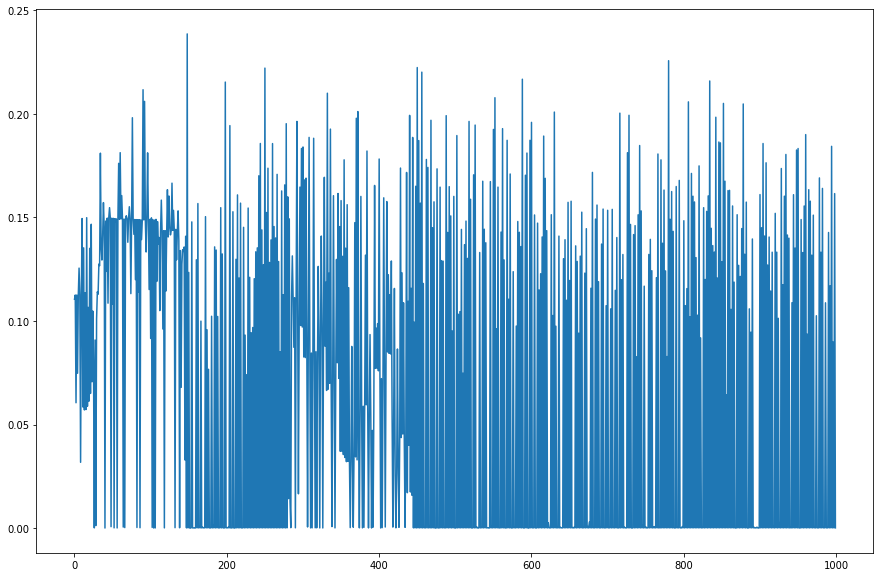

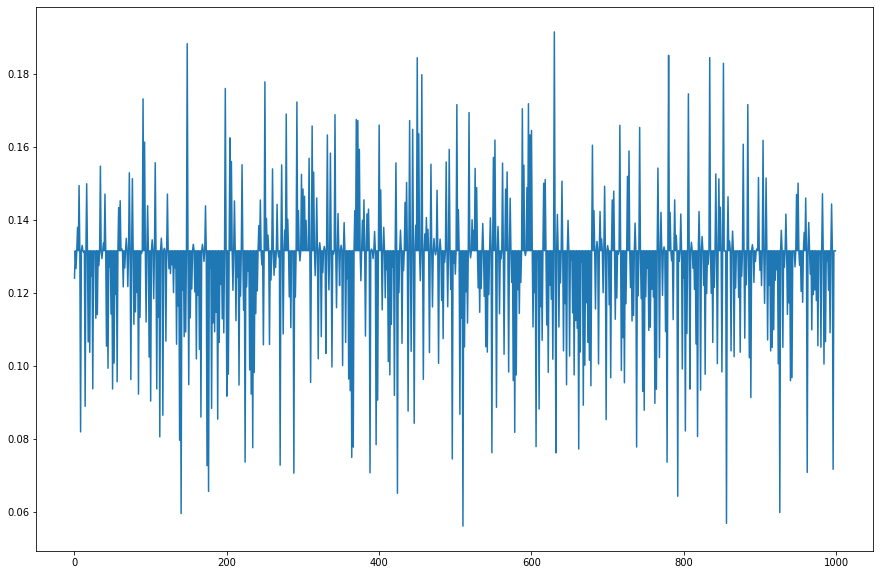

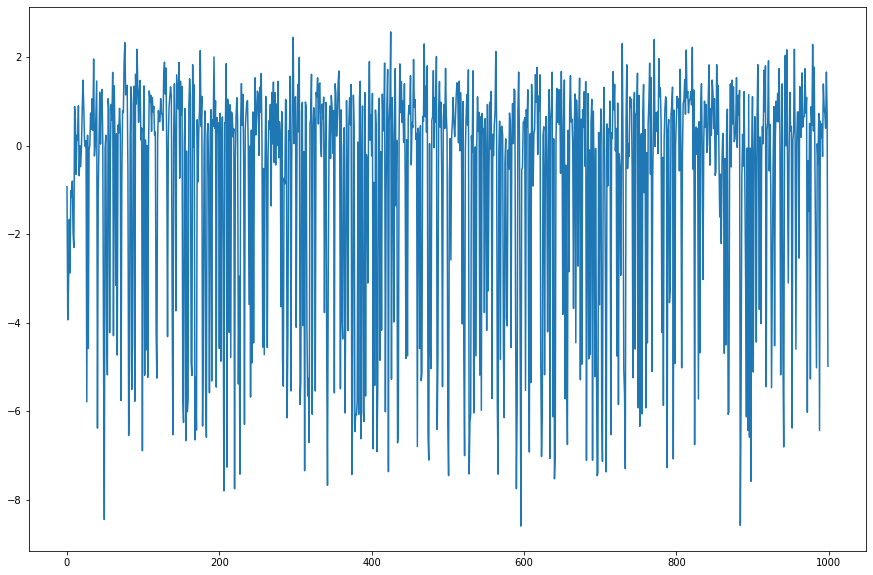

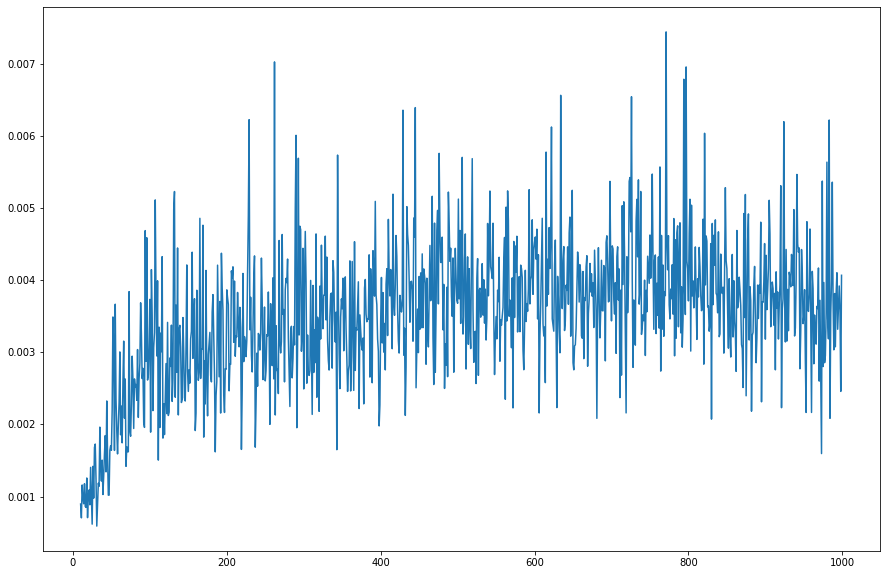

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=10e-10)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

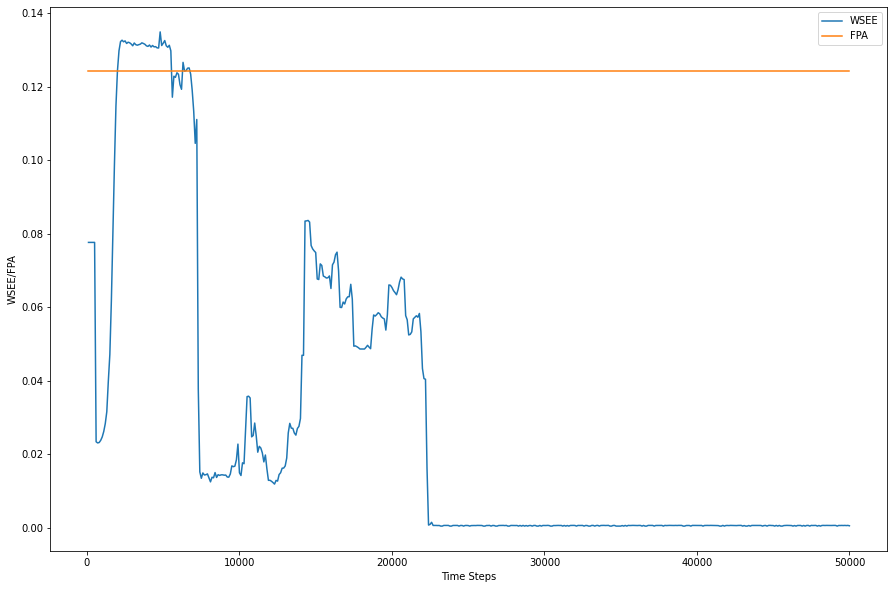

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

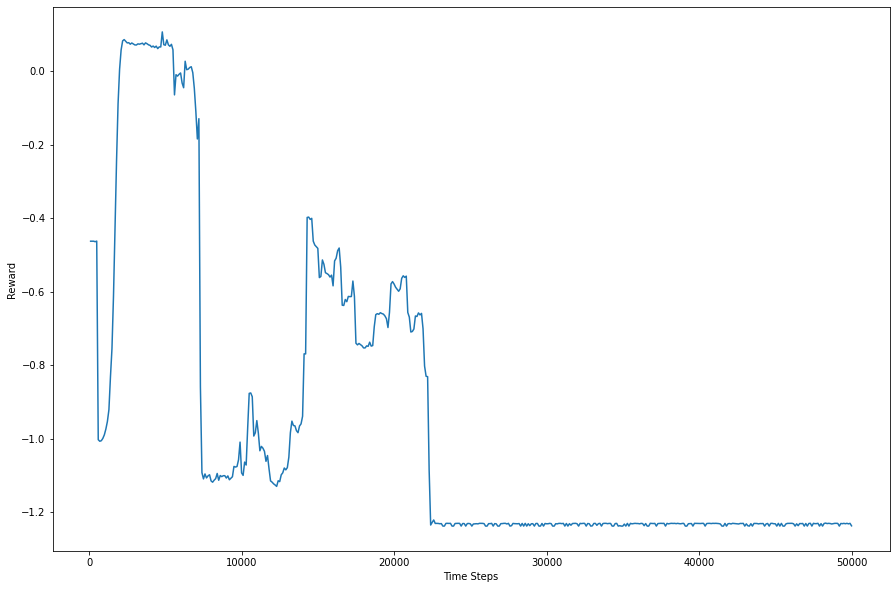

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
